# Common


In [ ]:
!pip install grad-cam

from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.8 MB 7.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.5-py3-none-any.whl size=37027 sha256=12c2bfba52a3fa81f30dd992f355819e136d93c954a6887387a18abe7a37f78d
  Stored in directory: /root/.cache/pip/wheels/f7/c1/fd/59384047f1fab2f99d96b224bdfd0d2b198f896bdb107d66fd
Successfully built grad-cam


In [ ]:
!pip install --upgrade gspread #default version contains a bug https://stackoverflow.com/questions/68218090/copy-still-throwing-errors-with-parameter-folder-id

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gspread
    Found existing installation: gspread 3.4.2
    Uninstalling gspread-3.4.2:
      Successfully uninstalled gspread-3.4.2


In [ ]:
import scipy.io
from google.colab import drive, auth
import gspread
from google.auth import default
import os
import itertools
import random
import copy
from tqdm import tqdm
from datetime import datetime
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision

# for evaluating the model
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

from torchvision import transforms
import albumentations
import albumentations.pytorch

import tensorflow as tf
from sklearn import metrics
from sklearn.model_selection import KFold, StratifiedKFold
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split, SubsetRandomSampler, ConcatDataset, Subset
from sklearn.model_selection import GridSearchCV


In [ ]:
print(gspread.__version__)

5.5.0


In [ ]:
# This will prompt for authorization.
drive.mount('/content/drive')

# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive/magisterka22/dane"

Mounted at /content/drive
HeartMasks		HighFatDiett  Version0	Version2
HFD2tyg_N01_T1maps.mat	Kontrolaa     Version1


In [ ]:
#Auth for spreedsheets
auth.authenticate_user()
creds, _ = default()

gc = gspread.authorize(creds)

In [ ]:
DATA_DIR = '/content/drive/My Drive/magisterka22/dane/Version1/Train/'
HEART_DATA_DIR = '/content/drive/My Drive/magisterka22/dane/Version2/Train/'

FAT_DIR0 = DATA_DIR + 'Square/HighFatDiet'
HEALTHY_DIR0 = DATA_DIR + 'Square/Kontrola'
FAT_DIR1 = DATA_DIR + 'Rectangle/HighFatDiet'
HEALTHY_DIR1 = DATA_DIR + 'Rectangle/Kontrola'

HEART_FAT_DIR0 = HEART_DATA_DIR + 'Square/HighFatDiet'
HEART_HEALTHY_DIR0 = HEART_DATA_DIR + 'Square/Kontrola'
HEART_FAT_DIR1 = HEART_DATA_DIR + 'Rectangle/HighFatDiet'
HEART_HEALTHY_DIR1 = HEART_DATA_DIR + 'Rectangle/Kontrola'



# Utils

In [ ]:
def fix_image(im, min_size=192): #it shold be do one and decide the dirrection
  (x, y) = im.shape
  #print("before fix x:",x," y:", y)
  if x < min_size:
    im = np.concatenate((im, np.zeros((min_size-x, y))))
  (x, y) = im.shape
  #print("after first fix x:",x," y:", y)
  if y < min_size:
    im = np.concatenate((im, np.zeros((x, min_size-y))), axis=1)
  return im

def load_image(filepath, label, shape, pre = False, rgb = False):
  maps = scipy.io.loadmat(filepath)
  #print(maps.keys())
  img_pre = np.array(maps['preT1map'], np.double)
  img_pre = fix_image(img_pre)
  img_post = np.array(maps['postT1map'], np.double)
  img_post = fix_image(img_post)
  if rgb:
    img_pre = toRGB(img_pre)
    img_post = toRGB(img_post)
  if pre:
    return (img_pre, label, shape)
  return (img_post, label, shape)


def load_numpy_image(filepath, label, shape, rgb = False):
  with open(filepath, 'rb') as f:
    img_pre = np.load(f)
    # plt.imshow(img_pre)
    # plt.show()
    if rgb:
      img_pre = toRGB(img_pre)
    return (img_pre, label, shape)


def toRGB(image):
  #image = image/2500
  rgb_image = np.stack((image, image, image), axis=2)
  return rgb_image
  
def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]


# Spreedsheet integration

In [ ]:
def create_spreedsheet(name, dest_dir_id):
  sh = gc.create(name, folder_id=dest_dir_id)
  link = 'https://docs.google.com/spreadsheets/d/' + sh.id + '/edit#gid=0'
  print("Created spreedsheet link:", link)

def next_available_row(worksheet):
  str_list = list(filter(None, worksheet.col_values(1)))
  return str(len(str_list)+1)

def update_row(name, values):
  worksheet = gc.open(name).sheet1
  index = next_available_row(worksheet)
  start = 'A' + str(index)
  to = chr(ord('A') + len(values)) + str(index)
  cell_list = worksheet.range(start + ':' + to)
  for cell,val in zip(cell_list, values):
    cell.value = val
  worksheet.update_cells(cell_list)

def print_sheet(name):
  worksheet = gc.open(name).sheet1
  rows = worksheet.get_all_values()
  print(rows)
  pd.DataFrame.from_records(rows)

def create_results_spreedsheet(name, dest_dir_id):
  create_spreedsheet(name, dest_dir_id)
  update_row(name, ['date', 'conf_matrix', 'acc', 'metadata', 'params'])

def append_results_to_spreedsheet(sp_name, params, conf_matrix, metadata={}):
  date = str(datetime.now())
  if type(conf_matrix) == str:
    acc = conf_matrix
  else:
    acc = (conf_matrix[0][0] + conf_matrix[1][1]) / np.sum(conf_matrix)
  values = [date, str(conf_matrix), acc, str(metadata)]
  for p in params.items():
    values.append(str(p))
  update_row(sp_name, values)
   

In [ ]:
DESTINATION_DIR_ID = "1Rl9xqRRWGUCN2T4ju4qTBKRkJGaHjtft"

SPREEDSHEET_NAME_FINAL = "Results Final (multiple runs) 2" + str(datetime.now())
SPREEDSHEET_NAME_INT = "Results Intermediate (multiple runs) 2" + str(datetime.now())

create_results_spreedsheet(SPREEDSHEET_NAME_FINAL, DESTINATION_DIR_ID)
create_results_spreedsheet(SPREEDSHEET_NAME_INT, DESTINATION_DIR_ID)

Created spreedsheet link: https://docs.google.com/spreadsheets/d/1p5crcGc0yi2CxQhgSnTlSZoWqjs87PMeYZ_Rk9P_GKs/edit#gid=0
Created spreedsheet link: https://docs.google.com/spreadsheets/d/1gMMyvwNXLjnoqaMXo8ifViK68Ym14_DVWoNFcQNTORo/edit#gid=0


In [ ]:
DESTINATION_DIR_ID = "1Rl9xqRRWGUCN2T4ju4qTBKRkJGaHjtft"

SPREEDSHEET_NAME_FINAL = "Results Final (multiple runs) 2022-09-15 21:33:48.728393"
SPREEDSHEET_NAME_INT = "Results Intermediate (multiple runs) 2022-09-15 21:33:48.728451"

In [ ]:
DESTINATION_DIR_ID = "1Rl9xqRRWGUCN2T4ju4qTBKRkJGaHjtft"

SPREEDSHEET_NAME_FINAL = "Results Final (multiple runs) 22022-09-24 12:04:06.061946"
SPREEDSHEET_NAME_INT = "Results Intermediate (multiple runs) 22022-09-24 12:04:06.062012"

# Dataset

In [ ]:
# PyTorch image augmentation module
class PyTorchImageDataset(Dataset):
    def __init__(self, fat_dir_square, fat_dir_rectangle, healthy_dir_square, healthy_dir_rectangle, transforms=None, rgb=False, pre=True):
        fat_square = [load_image(os.path.join(fat_dir_square, filename), 1, 0, pre, rgb) for filename in os.listdir(fat_dir_square)]
        fat_rectangle = [load_image(os.path.join(fat_dir_rectangle, filename), 1, 1, pre, rgb) for filename in os.listdir(fat_dir_rectangle)]
        healthy_square = [load_image(os.path.join(healthy_dir_square, filename), 0, 0, pre, rgb) for filename in os.listdir(healthy_dir_square)]
        healthy_rectangle = [load_image(os.path.join(healthy_dir_rectangle, filename), 0, 1, pre, rgb) for filename in os.listdir(healthy_dir_rectangle)]
        all = np.array(fat_square + fat_rectangle + healthy_square + healthy_rectangle)
        #np.random.shuffle(all)
        self.image_list = [x[0] for x in all]
        self.labels = [x[1] for x in all]
        self.sh = [x[2] for x in all]
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.image_list))
    
    def __getitem__(self, i):
        image = self.image_list[i]    
        image = np.array(image/10).astype(np.uint8)
        if self.transforms is not None:
            image = self.transforms(image) 
        return (image, self.labels[i], self.sh[i])

In [ ]:

class HeartDataset(Dataset):
    def __init__(self, fat_dir_square, fat_dir_rectangle, healthy_dir_square, healthy_dir_rectangle, transforms=None, rgb=False, pre=True):
        fat_square = [load_numpy_image(os.path.join(fat_dir_square, filename), 1, 0, rgb) for filename in os.listdir(fat_dir_square)]
        fat_rectangle = [load_numpy_image(os.path.join(fat_dir_rectangle, filename), 1, 1, rgb) for filename in os.listdir(fat_dir_rectangle)]
        healthy_square = [load_numpy_image(os.path.join(healthy_dir_square, filename), 0, 0, rgb) for filename in os.listdir(healthy_dir_square)]
        healthy_rectangle = [load_numpy_image(os.path.join(healthy_dir_rectangle, filename), 0, 1, rgb) for filename in os.listdir(healthy_dir_rectangle)]
        all = np.array(fat_square + fat_rectangle + healthy_square + healthy_rectangle)
        #np.random.shuffle(all)
        self.image_list = [x[0] for x in all]
        self.labels = [x[1] for x in all]
        self.sh = [x[2] for x in all]
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.image_list))
    
    def __getitem__(self, i):
        image = self.image_list[i]
        if self.transforms is not None:
            image = self.transforms(image)  
        return (image, self.labels[i], self.sh[i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Train dataset size: 43  img shape: (192, 192, 3)
Image shape: (192, 192, 3) min: 0.0  max: 2498.6437381880596


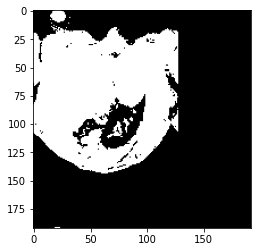

From getter shape: (3, 192, 192) min: 0.0  max: 0.9764706


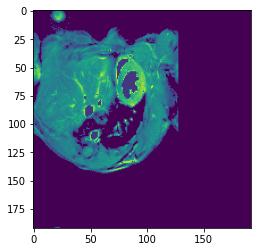

In [ ]:
#temp test

train_transform = transforms.Compose([
    #transforms.ToPILImage(),
    transforms.ToTensor()
])

#dataset = HeartDataset(HEART_FAT_DIR0, HEART_FAT_DIR1, HEART_HEALTHY_DIR0, HEART_HEALTHY_DIR1, train_transform, True)
dataset = PyTorchImageDataset(FAT_DIR0, FAT_DIR1, HEALTHY_DIR0, HEALTHY_DIR1, train_transform, True)
print("Train dataset size:", len(dataset), " img shape:", dataset.image_list[0].shape)

img = dataset.image_list[0]
#img = img.transpose((-1, 0, 1))
print("Image shape:", img.shape, "min:", np.min(img), " max:", np.max(img))
#img = img[0]
plt.imshow(img)
plt.show()

item = dataset.__getitem__(0)
img = item[0].numpy()
print("From getter shape:", img.shape, "min:", np.min(img), " max:", np.max(img))
plt.imshow(img[0])
plt.show()

# Networks defs

In [ ]:
class Net(Module):   
    def __init__(self, params={}, number_of_channels=1, image_size=192):
        super(Net, self).__init__()

        self.model_params = params
        self.input_ll_size = params['number_of_filers'] * image_size * image_size
        print("self.input_ll_size:",self.input_ll_size)
        if params['pooling']:
          #self.input_ll_size = int(self.input_ll_size/(4 ** params['number_of_conv_layers']))
          self.input_ll_size = params['number_of_filers'] * int( image_size /(2 ** params['number_of_conv_layers'])) * int( image_size /(2 ** params['number_of_conv_layers']))
          print(" self.input_ll_size:",self.input_ll_size)
        if params['shape_info']:
          self.input_ll_size = self.input_ll_size + 1

        self.cnn_layers = self._make_conv_layers(params['number_of_conv_layers'])

        self.linear_layers = [Sequential(
            Linear(self.input_ll_size, 2)
        ), 
        Sequential(
            Linear(self.input_ll_size, self.model_params['number_of_filers'] * 12 * 12),
            Dropout(self.model_params['dropout']),
            Linear(self.model_params['number_of_filers'] * 12 * 12, 2)
        ),
        Sequential(
            Linear(self.input_ll_size, self.model_params['number_of_filers'] * 12 * 12),
            Dropout(self.model_params['dropout']),
            Linear(self.model_params['number_of_filers'] * 12 * 12, self.model_params['number_of_filers'] * 4 * 4),
            Dropout(self.model_params['dropout']),
            Linear(self.model_params['number_of_filers'] * 4 * 4, 2)
        )]

    def _make_conv_layers(self, number):
      elements = self._make_conv_block(1, self.model_params['number_of_filers'])
      for _ in range(number-1):
        elements = elements + self._make_conv_block(self.model_params['number_of_filers'], self.model_params['number_of_filers'])
      return Sequential(*elements)
      
    def _make_conv_block(self, ins, outs):
      elements = []
      elements.append(Conv2d(ins, outs, kernel_size=3, stride=1, padding=1))
      if self.model_params['batch_norm']:
        elements.append(BatchNorm2d(outs))
      elements.append(ReLU(inplace=True))
      if self.model_params['pooling']:
        elements.append(MaxPool2d(kernel_size=2, stride=2))
      return elements
 
    def forward(self, x, shape=None):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        if self.model_params['shape_info'] and shape != None:
          shape = shape.view(-1, 1)
          x = torch.cat((x, shape), 1)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
        ll = self.linear_layers[self.model_params['number_of_linear_layers']-1].to(device)
        x = ll(x)
        return x


In [ ]:
def prepare_resnet_model(pretrained=False, dropout=0.0):
  #finetune_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained)
  finetune_model = torchvision.models.resnet18(pretrained=pretrained, progress=True,)
  num_ftrs = finetune_model.fc.out_features
  for param in finetune_model.parameters():
    param.requires_grad = False
  finetune_model.fc.weight.requires_grad = True
  finetune_model.fc.bias.requires_grad = True
  finetune_model = nn.Sequential(
      finetune_model, 
      nn.Dropout(dropout),
      nn.Linear(num_ftrs, 2))
  #print(finetune_model)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  finetune_model = finetune_model.to(device)
  return finetune_model


test pretrained

# Training functions

In [ ]:
def regularalize(model, loss, net_params):
  l1_norm = sum(abs(p).sum() for p in model.parameters())
  loss = loss + net_params['l1_regularization_lambda'] * l1_norm
  l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
  loss = loss + net_params['l2_regularization_lambda'] * l2_norm  
  return loss

def update_loss(general_loss, general_correct, loss, images, labels, output):
  general_loss += loss.item() * images.size(0)
  scores, predictions = torch.max(output.data, 1)
  general_correct += (predictions == labels).sum().item()
  return general_loss, general_correct

In [ ]:
def train_epoch(model, device, dataloader, loss_fn, optimizer, net_params, resnet=False):
    train_loss, train_correct = 0.0, 0
    model.train()
    for batch_ndx,(images, labels, sh) in enumerate(dataloader):
        images, labels, sh = images.to(device), labels.to(device), sh.to(device)
        optimizer.zero_grad()
        if resnet:
          output = model(images)
        else:
          output = model(images, sh) 
        loss = loss_fn(output, labels)
        if resnet == False:
          loss = regularalize(model, loss, net_params)
        loss.backward()
        optimizer.step()
        train_loss, train_correct = update_loss(train_loss, train_correct, loss, images, labels, output)
    return train_loss, train_correct
  
def valid_epoch(model, device, dataloader, loss_fn, net_params, resnet=False):
    val_loss, val_correct = 0.0, 0
    conf_matrix = [[0.0, 0.0], [0.0, 0.0]]
    model.eval()
    for batch_ndx,(images, labels, sh) in enumerate(dataloader):
        images, labels, sh = images.to(device), labels.to(device), sh.to(device)
        if resnet:
          output = model(images)
        else:
          output = model(images, sh) 
        loss = loss_fn(output, labels)
        val_loss, val_correct = update_loss(val_loss, val_correct, loss, images, labels, output)
        _, predictions = torch.max(output.data, 1)
        cf_matrix = confusion_matrix(labels.cpu(), predictions.cpu()) 
        conf_matrix += cf_matrix
    return val_loss, val_correct, conf_matrix


In [ ]:
def train_loop(model, device, net_params, train_loader, test_loader, criterion, optimizer, scheduler, resnet=False):
    # Early stopping
    last_loss = 100
    patience = 5
    trigger_times = 0
    
    for epoch in range(net_params['num_epochs']):
        train_loss, train_correct = train_epoch(model, device, train_loader, criterion, optimizer, net_params, resnet)
        test_loss, test_correct, cf_matrix = valid_epoch(model, device, test_loader, criterion, net_params, resnet)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100

        #scheduler.step(test_loss)

        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1, net_params['num_epochs'], train_loss, test_loss, train_acc, test_acc))

        # Early stopping
        if train_loss >= last_loss:
            #print("trt:", trigger_times, " patience:", patience)
            trigger_times += 1
            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                return cf_matrix
        else:
            trigger_times = 0
        last_loss = train_loss
    return cf_matrix

def prepare_model(get_model, learning_rate):
  model = get_model()
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model.to(device)  
  optimizer = Adam(model.parameters(), lr=learning_rate)
  scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
  return model, optimizer, device, scheduler

#to be changed
# def folds_loop_seq(get_model, dataset0, dataset1, criterion, net_params, splits0, splits1):
#   results, results1 = {}, {}
#   for fold, ((train_idx, val_idx), (train_idx1, val_idx1)) in enumerate(zip(splits0, splits1)):
#     print('Fold {}. train_idx:{} val_idx:{} train_idx1:{} val_idx1:{}'.format(fold + 1, train_idx, val_idx, train_idx1, val_idx1))

#     model, optimizer, device = prepare_model(get_model, net_params['learning_rate'])
#     test_loader, shapes_test = prepare_test_loader(val_idx, val_idx1, net_params['batch_size'], len(train_idx)+len(val_idx), joined_dataset)

#     shapes_train = np.zeros((len(train_idx), 1))
#     train_loader = DataLoader(dataset0, batch_size=net_params['batch_size']) #, sampler=SubsetRandomSampler(train_idx))
#     results[fold] = train_loop(model, device, net_params, train_loader, test_loader, criterion, optimizer, shapes_train, shapes_test)
    
#     shapes_train1 = np.ones((len(train_idx1), 1))
#     train_loader1 = DataLoader(dataset1, batch_size=net_params['batch_size']) #, sampler=SubsetRandomSampler(train_idx1))
#     results1[fold] = train_loop(model, device, net_params, train_loader1, test_loader, criterion, optimizer, shapes_train1, shapes_test)
#   return results, results1

def folds_loop(get_model, dataset, criterion, net_params, splits, resnet=False):
  results = {}
  for fold, (train_idx, val_idx) in enumerate(splits):
      print('Fold {}. train_idx:{} val_idx:{}'.format(fold + 1, train_idx, val_idx))
      model, optimizer, device, scheduler = prepare_model(get_model, net_params['learning_rate'])
      test_loader = DataLoader(Subset(dataset, val_idx), batch_size=net_params['batch_size'])
      train_loader = DataLoader(Subset(dataset, train_idx), batch_size=net_params['batch_size'])
      results[fold] = train_loop(model, device, net_params, train_loader, test_loader, criterion, optimizer, scheduler, resnet)
  return results


In [ ]:
def print_and_save_folds_results(conf_matrixes, params, sp_name, agums = None):
  sum = 0.0
  print("--- FOLDS RESULTS ---")
  for key, conf_matrix in conf_matrixes.items():
    metadata = {'fold': str(key+1)+'/'+str(len(conf_matrixes.items()))}
    if agums != None:
      metadata = dict(**metadata, **agums)
    append_results_to_spreedsheet(sp_name, params, conf_matrix, metadata)
    v = (conf_matrix[0][0] + conf_matrix[1][1]) / np.sum(conf_matrix)
    print(f'Fold {key} acc: {v*100} %')
    sum += v
  result = sum/len(conf_matrixes.items())
  print(f' Average acc: {result*100} %')
  metadata = {'FINAL': 1}
  if agums != None:
    metadata = dict(**metadata, **agums)
  append_results_to_spreedsheet(sp_name, params, str(result), metadata)
  return result

def find_best_params_ndim(grid_param, grid):
  print("grid_param:", grid_param, " grid:", grid)
  keys = list(grid_param.keys())
  shape = tuple(len(grid_param[keys[i]]) for i in range(len(keys)))
  best, best_idx = 0, 0
  for idx in itertools.product(*[range(s) for s in shape]):
    current = grid[idx]
    if current > best:
      best = current
      best_idx = idx
  print("best:", best, "best_idx:", best_idx)
  best_params = {k: grid_param[k][best_idx[e]] for e,k in enumerate(keys)}
  print("best params:", best_params)
  return best_params

In [ ]:
def search_for_best_params(train_idx, dataset, grid_param, resnet=False):
  keys = list(grid_param.keys())
  shape = tuple(len(grid_param[keys[i]]) for i in range(len(keys)))
  grid = np.zeros((shape))
  inner_splitter = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

  for idx in itertools.product(*[range(s) for s in shape]):
    current_params = {k: grid_param[k][idx[e]] for e,k in enumerate(keys)}
    print("current p:", current_params)
    def model_getter():
      return Net(current_params, 1, dataset.image_list[0].shape[0] )
    def model_getter_resnet():
      return copy.deepcopy(resnet_model)

    inner_splits = inner_splitter.split(train_idx, np.array(dataset.labels)[train_idx])

    results = {}
    for inner_fold, (inner_train_idxx, inner_val_idxx) in enumerate(inner_splits):
      inner_train_idx, inner_val_idx = train_idx[inner_train_idxx], train_idx[inner_val_idxx]

      if resnet:    
        model, optimizer, device, scheduler = prepare_model(model_getter_resnet, current_params['learning_rate'])
      else:
        model, optimizer, device, scheduler = prepare_model(model_getter, current_params['learning_rate'])
      test_loader = DataLoader(Subset(dataset, inner_val_idx), batch_size=current_params['batch_size']) 
      train_loader = DataLoader(Subset(dataset, inner_train_idx), batch_size=current_params['batch_size']) 
      results[inner_fold] = train_loop(model, device, current_params, train_loader, test_loader, criterion, optimizer, scheduler, resnet)  

    grid[idx] = print_and_save_folds_results(results, current_params, SPREEDSHEET_NAME_INT)
  best_params = find_best_params_ndim(grid_param, grid)
  return best_params


def folds_loop_double(dataset, criterion, grid_param, splits, resnet=False):
  out_results = {}
  out_best_params = {}
  trained_models = {}
  for fold, (train_idx, val_idx) in enumerate(splits):
      print('Fold(outher) {}. train_idx:{} val_idx:{}'.format(fold + 1, train_idx, val_idx))

      best_params = search_for_best_params(train_idx, dataset, grid_param, resnet)

      def model_getter():
        return Net(best_params, 1, dataset.image_list[0].shape[0])
      def model_getter_resnet():
        return copy.deepcopy(resnet_model)

      print("Running final learning session for Fold(outher):", fold+1, " with best_params:", best_params)
      if resnet:
        model, optimizer, device, scheduler = prepare_model(model_getter_resnet, best_params['learning_rate'])
      else:
        model, optimizer, device, scheduler = prepare_model(model_getter, best_params['learning_rate'])
      test_loader = DataLoader(dataset, batch_size=best_params['batch_size'], sampler=SubsetRandomSampler(val_idx))
      train_loader = DataLoader(dataset, batch_size=best_params['batch_size'], sampler=SubsetRandomSampler(train_idx))
      
      out_results[fold] = train_loop(model, device, best_params, train_loader, test_loader, criterion, optimizer, scheduler, resnet)
      out_best_params[fold] = best_params
      trained_models[fold] = model
  return out_results, out_best_params, trained_models

In [ ]:
def grid_on_agumentations(model_type, dataset_type, grid_agumentations, grid_param):
  torch.manual_seed(42)
  criterion = nn.CrossEntropyLoss()

  keys = list(grid_agumentations.keys())
  shape = tuple(len(grid_agumentations[keys[i]]) for i in range(len(keys)))
  grid = np.zeros((shape))

  for idx in itertools.product(*[range(s) for s in shape]):
    current_agumentations = {k: grid_agumentations[k][idx[e]] for e,k in enumerate(keys)}
    print("  current_agumentations:", current_agumentations)

    train_transform = transforms.Compose([
      transforms.ToPILImage(),                                  
      transforms.RandomHorizontalFlip(p=current_agumentations['RandomHorizontalFlipProb']),
      transforms.RandomRotation(degrees=(-1*current_agumentations['RandomRotation'], current_agumentations['RandomRotation'])),
      transforms.RandomAffine(degrees=0, scale=(1.0-current_agumentations['RandomAffineScale'], 1.0+current_agumentations['RandomAffineScale']), shear=0),
      #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
      transforms.RandomVerticalFlip(p=current_agumentations['RandomVerticalFlipProb']),
      transforms.ToTensor()
    ])

    rgb = True
    if '.Net' in str(model_type):
      rgb = False
    if 'HeartDataset' in str(dataset_type):
      dataset = dataset_type(HEART_FAT_DIR0, HEART_FAT_DIR1, HEART_HEALTHY_DIR0, HEART_HEALTHY_DIR1, train_transform, rgb)
    else:
      dataset = dataset_type(FAT_DIR0, FAT_DIR1, HEALTHY_DIR0, HEALTHY_DIR1, train_transform, rgb)


    splitter = StratifiedKFold(n_splits=4, shuffle=True, random_state=42) 
    splits = splitter.split(dataset, dataset.labels)

    current_params = {k: grid_param[k][0] for k in list(grid_param.keys())}

    def model_getter():
      return model_type(current_params, 1, dataset.image_list[0].shape[0])
    def model_getter_resnet():
      return copy.deepcopy(model_type)

    if '.Net' in str(model_type):
      results = folds_loop(model_getter, dataset, criterion, current_params, splits)
    else: #resnet
      results = folds_loop(model_getter_resnet, dataset, criterion, current_params, splits, True)

    grid[idx] = print_and_save_folds_results(results, current_params, SPREEDSHEET_NAME_FINAL, current_agumentations)

  best_params = find_best_params_ndim(grid_agumentations, grid)
  print("best params:", best_params)





# Network with cross validation

CNN

In [ ]:
torch.manual_seed(42)
criterion = nn.CrossEntropyLoss()

grid_param = {
    'learning_rate': [0.001],
    'batch_size': [4], 
    'dropout': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'num_epochs': [30],
    'number_of_linear_layers': [2], 
    'l1_regularization_lambda': [0.0, 0.01, 0.001], 
    'l2_regularization_lambda': [0.0, 0.01, 0.001],
    'number_of_conv_layers': [2], 
    'number_of_filers': [3], 
    'pooling': [True],
    'batch_norm': [True],
    'shape_info': [False],
}


k = 4
pre = False

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

In [ ]:
#trianing (without grid search)

dataset = PyTorchImageDataset(FAT_DIR0, FAT_DIR1, HEALTHY_DIR0, HEALTHY_DIR1, train_transform, False, pre)
print("Train dataset size:", len(dataset))

splitter = StratifiedKFold(n_splits=k, shuffle=True, random_state=42) 
splits = splitter.split(dataset, dataset.labels)

current_params = {k: grid_param[k][0] for k in list(grid_param.keys())}

def model_getter():
  return Net(current_params, 1)

results = folds_loop(model_getter, dataset, criterion, current_params, splits)
print_and_save_folds_results(results, current_params, SPREEDSHEET_NAME_FINAL)

In [ ]:
#trianing (without grid search) a lot of times

# train_transform = transforms.Compose([
#       transforms.ToPILImage(),                                  
#       transforms.RandomHorizontalFlip(p=0.5),
#       transforms.RandomRotation(degrees=(-1*30, 30)),
#       transforms.RandomAffine(degrees=0, scale=(1.0-0.2, 1.0+0.2), shear=0),
#       #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
#       transforms.RandomVerticalFlip(p=0),
#       transforms.ToTensor()
#     ])

dataset = PyTorchImageDataset(FAT_DIR0, FAT_DIR1, HEALTHY_DIR0, HEALTHY_DIR1, train_transform, False, pre)
print("Train dataset size:", len(dataset))

times = 10
final_acc = []

for _ in range(times):

  splitter = StratifiedKFold(n_splits=k, shuffle=True, random_state=42) 
  splits = splitter.split(dataset, dataset.labels)

  current_params = {k: grid_param[k][0] for k in list(grid_param.keys())}

  def model_getter():
    return Net(current_params, 1)

  results = folds_loop(model_getter, dataset, criterion, current_params, splits)
  acc = print_and_save_folds_results(results, current_params, SPREEDSHEET_NAME_FINAL)
  final_acc.append(acc)
print("Runed ", times, " times. Results:", final_acc, " avg:", np.mean(final_acc), " std:", np.std(final_acc))

In [ ]:
#grid search (single cross validation)

dataset = PyTorchImageDataset(FAT_DIR0, FAT_DIR1, HEALTHY_DIR0, HEALTHY_DIR1, train_transform, False, pre)
splitter = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

keys = list(grid_param.keys())
print("grid_param:", grid_param)
shape = tuple(len(grid_param[keys[i]]) for i in range(len(keys)))
gread = np.zeros((shape))

for idx in itertools.product(*[range(s) for s in shape]):
    current_params = {k: grid_param[k][idx[e]] for e,k in enumerate(keys)}
    print(" idx:", idx, " current_params:", current_params)

    def model_getter():
      return Net(current_params, 1)
      
    splits = splitter.split(dataset, dataset.labels)
    
    results = folds_loop(model_getter, dataset, criterion, current_params, splits)

    avg_result = print_and_save_folds_results(results, current_params, SPREEDSHEET_NAME_FINAL)
    print("result for idx:", idx, " res:", avg_result)
    gread[idx] = avg_result

print("----------------")
find_best_params_ndim(grid_param, gread)

In [ ]:
#grid search (double cross validation)

dataset = PyTorchImageDataset(FAT_DIR0, FAT_DIR1, HEALTHY_DIR0, HEALTHY_DIR1, train_transform, False, pre)

splitter = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
splits = splitter.split(dataset, dataset.labels)

out_results, out_best_params, trained_models = folds_loop_double(dataset, criterion, grid_param, splits)
print_and_save_folds_results(out_results, out_best_params, SPREEDSHEET_NAME_FINAL)
print("Final best params:", out_best_params)

RESNET

In [ ]:
torch.manual_seed(42)
criterion = nn.CrossEntropyLoss()

grid_param = {
    'learning_rate': [0.001],
    'batch_size': [6], 
    'num_epochs': [20]
}

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

In [ ]:
#trianing (without grid search) RESNET 

finetune_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
num_ftrs = finetune_model.fc.in_features
finetune_model.fc = nn.Linear(num_ftrs, 2)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
finetune_model = finetune_model.to(device)
#print(finetune_model)

dataset = PyTorchImageDataset(FAT_DIR0, FAT_DIR1, HEALTHY_DIR0, HEALTHY_DIR1, train_transform, True)
print("Train dataset shape:", dataset[0][0].shape)

splitter = StratifiedKFold(n_splits=4, shuffle=True, random_state=42) 
splits = splitter.split(dataset, dataset.labels)

current_params = {k: grid_param[k][0] for k in list(grid_param.keys())}


def model_getter():
  return copy.deepcopy(finetune_model)

results = folds_loop(model_getter, dataset, criterion, current_params, splits, resnet=True)
print_and_save_folds_results(results, grid_param, SPREEDSHEET_NAME_FINAL)

In [ ]:
#trianing resnet (without grid search) a lot of times

train_transform = transforms.Compose([
      transforms.ToPILImage(),                                  
      # transforms.RandomHorizontalFlip(p=0.5),
      # transforms.RandomRotation(degrees=(-1*90, 90)),
      # transforms.RandomAffine(degrees=0, scale=(1.0-0.4, 1.0+0.4), shear=0),
      # #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
      # transforms.RandomVerticalFlip(p=0.5),
      transforms.ToTensor()
    ])

times = 10
final_acc = []

for _ in range(times):
  finetune_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
  num_ftrs = finetune_model.fc.in_features
  finetune_model.fc = nn.Linear(num_ftrs, 2)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  finetune_model = finetune_model.to(device)
  #print(finetune_model)

  dataset = PyTorchImageDataset(FAT_DIR0, FAT_DIR1, HEALTHY_DIR0, HEALTHY_DIR1, train_transform, True)
  print("Train dataset shape:", dataset[0][0].shape)

  splitter = StratifiedKFold(n_splits=4, shuffle=True, random_state=42) 
  splits = splitter.split(dataset, dataset.labels)

  current_params = {k: grid_param[k][0] for k in list(grid_param.keys())}


  def model_getter():
    return copy.deepcopy(finetune_model)

  results = folds_loop(model_getter, dataset, criterion, current_params, splits, resnet=True)
  acc = print_and_save_folds_results(results, grid_param, SPREEDSHEET_NAME_FINAL)
  final_acc.append(acc)
print("Runed ", times, " times. Results:", final_acc, " avg:", np.mean(final_acc), " std:", np.std(final_acc))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Train dataset shape: torch.Size([3, 192, 192])
Fold 1. train_idx:[ 0  1  3  4  5  6  8 11 12 15 16 17 18 19 20 21 22 23 25 26 27 29 31 33
 35 36 37 38 39 40 41 42] val_idx:[ 2  7  9 10 13 14 24 28 30 32 34]
Epoch:1/20 AVG Training Loss:1.839 AVG Test Loss:0.730 AVG Training Acc 56.25 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.215 AVG Test Loss:0.749 AVG Training Acc 28.12 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:0.936 AVG Test Loss:0.715 AVG Training Acc 31.25 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.735 AVG Test Loss:0.694 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:5/20 AVG Training Loss:0.610 AVG Test Loss:0.699 AVG Training Acc 75.00 % AVG Test Acc 54.55 %
Epoch:6/20 AVG Training Loss:0.546 AVG Test Loss:0.692 AVG Training Acc 93.75 % AVG Test Acc 45.45 %
Epoch:7/20 AVG Training Loss:0.444 AVG Test Loss:0.699 AVG Training Acc 100.00 % AVG Test Acc 54.55 %
Epoch:8/20 AVG Training Loss:0.341 AVG Test Loss:0.699 AVG Training Acc 100.00 % AVG 

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Train dataset shape: torch.Size([3, 192, 192])
Fold 1. train_idx:[ 0  1  3  4  5  6  8 11 12 15 16 17 18 19 20 21 22 23 25 26 27 29 31 33
 35 36 37 38 39 40 41 42] val_idx:[ 2  7  9 10 13 14 24 28 30 32 34]
Epoch:1/20 AVG Training Loss:1.871 AVG Test Loss:0.877 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.235 AVG Test Loss:1.702 AVG Training Acc 25.00 % AVG Test Acc 54.55 %
Epoch:3/20 AVG Training Loss:1.106 AVG Test Loss:2.666 AVG Training Acc 21.88 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.989 AVG Test Loss:1.024 AVG Training Acc 21.88 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:0.955 AVG Test Loss:1.801 AVG Training Acc 21.88 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:0.761 AVG Test Loss:0.634 AVG Training Acc 40.62 % AVG Test Acc 72.73 %
Epoch:7/20 AVG Training Loss:0.891 AVG Test Loss:0.777 AVG Training Acc 25.00 % AVG Test Acc 36.36 %
Epoch:8/20 AVG Training Loss:0.866 AVG Test Loss:1.330 AVG Training Acc 3.12 % AVG Tes

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Train dataset shape: torch.Size([3, 192, 192])
Fold 1. train_idx:[ 0  1  3  4  5  6  8 11 12 15 16 17 18 19 20 21 22 23 25 26 27 29 31 33
 35 36 37 38 39 40 41 42] val_idx:[ 2  7  9 10 13 14 24 28 30 32 34]
Epoch:1/20 AVG Training Loss:1.734 AVG Test Loss:0.978 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.412 AVG Test Loss:1.819 AVG Training Acc 25.00 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:1.008 AVG Test Loss:9.006 AVG Training Acc 12.50 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:0.740 AVG Test Loss:1.030 AVG Training Acc 40.62 % AVG Test Acc 27.27 %
Epoch:5/20 AVG Training Loss:0.650 AVG Test Loss:3.075 AVG Training Acc 68.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:0.591 AVG Test Loss:1.300 AVG Training Acc 78.12 % AVG Test Acc 36.36 %
Epoch:7/20 AVG Training Loss:0.496 AVG Test Loss:0.926 AVG Training Acc 96.88 % AVG Test Acc 36.36 %
Epoch:8/20 AVG Training Loss:0.394 AVG Test Loss:1.833 AVG Training Acc 100.00 % AVG T

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Train dataset shape: torch.Size([3, 192, 192])
Fold 1. train_idx:[ 0  1  3  4  5  6  8 11 12 15 16 17 18 19 20 21 22 23 25 26 27 29 31 33
 35 36 37 38 39 40 41 42] val_idx:[ 2  7  9 10 13 14 24 28 30 32 34]
Epoch:1/20 AVG Training Loss:1.725 AVG Test Loss:0.712 AVG Training Acc 40.62 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.194 AVG Test Loss:3.888 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:3/20 AVG Training Loss:1.155 AVG Test Loss:10.937 AVG Training Acc 9.38 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:0.816 AVG Test Loss:2.952 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:5/20 AVG Training Loss:0.706 AVG Test Loss:3.667 AVG Training Acc 43.75 % AVG Test Acc 54.55 %
Epoch:6/20 AVG Training Loss:0.605 AVG Test Loss:0.718 AVG Training Acc 71.88 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.530 AVG Test Loss:0.695 AVG Training Acc 90.62 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.422 AVG Test Loss:0.675 AVG Training Acc 100.00 % AVG T

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Train dataset shape: torch.Size([3, 192, 192])
Fold 1. train_idx:[ 0  1  3  4  5  6  8 11 12 15 16 17 18 19 20 21 22 23 25 26 27 29 31 33
 35 36 37 38 39 40 41 42] val_idx:[ 2  7  9 10 13 14 24 28 30 32 34]
Epoch:1/20 AVG Training Loss:1.818 AVG Test Loss:0.770 AVG Training Acc 40.62 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.232 AVG Test Loss:2.861 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:3/20 AVG Training Loss:1.091 AVG Test Loss:4.245 AVG Training Acc 12.50 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.980 AVG Test Loss:1.558 AVG Training Acc 21.88 % AVG Test Acc 54.55 %
Epoch:5/20 AVG Training Loss:0.947 AVG Test Loss:1.247 AVG Training Acc 9.38 % AVG Test Acc 54.55 %
Epoch:6/20 AVG Training Loss:0.858 AVG Test Loss:1.160 AVG Training Acc 9.38 % AVG Test Acc 45.45 %
Epoch:7/20 AVG Training Loss:0.892 AVG Test Loss:2.100 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:8/20 AVG Training Loss:0.859 AVG Test Loss:1.203 AVG Training Acc 0.00 % AVG Test A

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Train dataset shape: torch.Size([3, 192, 192])
Fold 1. train_idx:[ 0  1  3  4  5  6  8 11 12 15 16 17 18 19 20 21 22 23 25 26 27 29 31 33
 35 36 37 38 39 40 41 42] val_idx:[ 2  7  9 10 13 14 24 28 30 32 34]
Epoch:1/20 AVG Training Loss:1.754 AVG Test Loss:0.953 AVG Training Acc 34.38 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.275 AVG Test Loss:5.807 AVG Training Acc 34.38 % AVG Test Acc 54.55 %
Epoch:3/20 AVG Training Loss:1.053 AVG Test Loss:1.444 AVG Training Acc 15.62 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.993 AVG Test Loss:0.618 AVG Training Acc 18.75 % AVG Test Acc 72.73 %
Epoch:5/20 AVG Training Loss:0.832 AVG Test Loss:0.705 AVG Training Acc 15.62 % AVG Test Acc 54.55 %
Epoch:6/20 AVG Training Loss:0.771 AVG Test Loss:0.712 AVG Training Acc 28.12 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.721 AVG Test Loss:0.698 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:8/20 AVG Training Loss:0.629 AVG Test Loss:0.697 AVG Training Acc 68.75 % AVG Te

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Train dataset shape: torch.Size([3, 192, 192])
Fold 1. train_idx:[ 0  1  3  4  5  6  8 11 12 15 16 17 18 19 20 21 22 23 25 26 27 29 31 33
 35 36 37 38 39 40 41 42] val_idx:[ 2  7  9 10 13 14 24 28 30 32 34]
Epoch:1/20 AVG Training Loss:2.023 AVG Test Loss:0.692 AVG Training Acc 56.25 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.036 AVG Test Loss:2.118 AVG Training Acc 9.38 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:0.804 AVG Test Loss:0.743 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.721 AVG Test Loss:0.691 AVG Training Acc 34.38 % AVG Test Acc 54.55 %
Epoch:5/20 AVG Training Loss:0.590 AVG Test Loss:0.710 AVG Training Acc 87.50 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:0.521 AVG Test Loss:0.723 AVG Training Acc 87.50 % AVG Test Acc 45.45 %
Epoch:7/20 AVG Training Loss:0.425 AVG Test Loss:0.714 AVG Training Acc 96.88 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.316 AVG Test Loss:0.689 AVG Training Acc 100.00 % AVG Te

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Train dataset shape: torch.Size([3, 192, 192])
Fold 1. train_idx:[ 0  1  3  4  5  6  8 11 12 15 16 17 18 19 20 21 22 23 25 26 27 29 31 33
 35 36 37 38 39 40 41 42] val_idx:[ 2  7  9 10 13 14 24 28 30 32 34]
Epoch:1/20 AVG Training Loss:2.032 AVG Test Loss:0.735 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:2/20 AVG Training Loss:1.193 AVG Test Loss:0.708 AVG Training Acc 25.00 % AVG Test Acc 54.55 %
Epoch:3/20 AVG Training Loss:0.846 AVG Test Loss:0.774 AVG Training Acc 40.62 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:0.735 AVG Test Loss:0.686 AVG Training Acc 31.25 % AVG Test Acc 54.55 %
Epoch:5/20 AVG Training Loss:0.610 AVG Test Loss:0.688 AVG Training Acc 78.12 % AVG Test Acc 54.55 %
Epoch:6/20 AVG Training Loss:0.484 AVG Test Loss:0.685 AVG Training Acc 100.00 % AVG Test Acc 81.82 %
Epoch:7/20 AVG Training Loss:0.434 AVG Test Loss:0.677 AVG Training Acc 100.00 % AVG Test Acc 54.55 %
Epoch:8/20 AVG Training Loss:0.336 AVG Test Loss:0.690 AVG Training Acc 100.00 % AVG

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Train dataset shape: torch.Size([3, 192, 192])
Fold 1. train_idx:[ 0  1  3  4  5  6  8 11 12 15 16 17 18 19 20 21 22 23 25 26 27 29 31 33
 35 36 37 38 39 40 41 42] val_idx:[ 2  7  9 10 13 14 24 28 30 32 34]
Epoch:1/20 AVG Training Loss:1.711 AVG Test Loss:0.876 AVG Training Acc 40.62 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.322 AVG Test Loss:0.675 AVG Training Acc 21.88 % AVG Test Acc 54.55 %
Epoch:3/20 AVG Training Loss:0.962 AVG Test Loss:0.897 AVG Training Acc 21.88 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.906 AVG Test Loss:0.854 AVG Training Acc 21.88 % AVG Test Acc 54.55 %
Epoch:5/20 AVG Training Loss:0.902 AVG Test Loss:0.906 AVG Training Acc 12.50 % AVG Test Acc 54.55 %
Epoch:6/20 AVG Training Loss:0.873 AVG Test Loss:0.967 AVG Training Acc 6.25 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.728 AVG Test Loss:0.805 AVG Training Acc 34.38 % AVG Test Acc 18.18 %
Epoch:8/20 AVG Training Loss:0.658 AVG Test Loss:0.751 AVG Training Acc 62.50 % AVG Tes

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Train dataset shape: torch.Size([3, 192, 192])
Fold 1. train_idx:[ 0  1  3  4  5  6  8 11 12 15 16 17 18 19 20 21 22 23 25 26 27 29 31 33
 35 36 37 38 39 40 41 42] val_idx:[ 2  7  9 10 13 14 24 28 30 32 34]
Epoch:1/20 AVG Training Loss:1.877 AVG Test Loss:0.699 AVG Training Acc 56.25 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.193 AVG Test Loss:1.443 AVG Training Acc 31.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:1.023 AVG Test Loss:0.763 AVG Training Acc 18.75 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:0.936 AVG Test Loss:0.777 AVG Training Acc 21.88 % AVG Test Acc 54.55 %
Epoch:5/20 AVG Training Loss:0.723 AVG Test Loss:0.749 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:0.645 AVG Test Loss:0.738 AVG Training Acc 65.62 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.526 AVG Test Loss:0.708 AVG Training Acc 90.62 % AVG Test Acc 54.55 %
Epoch:8/20 AVG Training Loss:0.414 AVG Test Loss:0.691 AVG Training Acc 100.00 % AVG T

In [ ]:
#grid search (double cross validation)

pretrained = False
dropout = 0.0

resnet_model = prepare_resnet_model(pretrained, dropout)

dataset = PyTorchImageDataset(FAT_DIR0, FAT_DIR1, HEALTHY_DIR0, HEALTHY_DIR1, train_transform, True)
print("Train dataset size:", len(dataset), " img shape:", dataset.image_list[0].shape)

splitter = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
splits = splitter.split(dataset, dataset.labels)

out_results, out_best_params, trained_models = folds_loop_double(dataset, criterion, grid_param, splits, True)
print_and_save_folds_results(out_results, out_best_params, SPREEDSHEET_NAME_FINAL, {'resnet': True, 'pretrained': pretrained, 'dropout': dropout})
print("Final best params:", out_best_params)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
Epoch:4/8 AVG Training Loss:2.035 AVG Test Loss:0.866 AVG Training Acc 28.57 % AVG Test Acc 54.55 %
Epoch:5/8 AVG Training Loss:1.086 AVG Test Loss:0.690 AVG Training Acc 57.14 % AVG Test Acc 54.55 %
Epoch:6/8 AVG Training Loss:0.561 AVG Test Loss:0.884 AVG Training Acc 71.43 % AVG Test Acc 45.45 %
Epoch:7/8 AVG Training Loss:1.261 AVG Test Loss:0.748 AVG Training Acc 42.86 % AVG Test Acc 45.45 %
Epoch:8/8 AVG Training Loss:0.988 AVG Test Loss:0.694 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:1/8 AVG Training Loss:6.571 AVG Test Loss:0.756 AVG Training Acc 54.55 % AVG Test Acc 60.00 %
Epoch:2/8 AVG Training Loss:0.120 AVG Test Loss:1.485 AVG Training Acc 100.00 % AVG Test Acc 40.00 %
Epoch:3/8 AVG Training Loss:3.604 AVG Test Loss:0.888 AVG Training Acc 45.45 % AVG Test Acc 40.00 %
Epoch:4/8 AVG Training Loss:2.093 AVG Test Loss:0.789 AVG Training Acc 27.27 % AVG Test Acc 60.00 %
Epoch:5/8 AVG Training Loss:1.130 A

# [Heart images] Network with cross validation
(network on hearts only)
[Notebook used from heart extraction](https://colab.research.google.com/drive/1PtqREGfe-oRDVahObBPgkDkY7rt2Q08j?authuser=1#scrollTo=Lp-Yfm5tJHB-)

CNN

In [ ]:
torch.manual_seed(42)
criterion = nn.CrossEntropyLoss()

grid_param = {
    'learning_rate': [0.001],
    'batch_size': [4], 
    'dropout': [0.0],
    'num_epochs': [30],
    'number_of_linear_layers': [2], 
    'l1_regularization_lambda': [0.0], 
    'l2_regularization_lambda': [0.0],
    'number_of_conv_layers': [2], 
    'number_of_filers': [3], 
    'pooling': [True],
    'batch_norm': [True],
    'shape_info': [False]
}

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

In [ ]:
#trianing (without grid search)

dataset = HeartDataset(HEART_FAT_DIR0, HEART_FAT_DIR1, HEART_HEALTHY_DIR0, HEART_HEALTHY_DIR1, train_transform, False)
print("Train dataset size:", len(dataset), " img shape:", dataset.image_list[0].shape)

splitter = StratifiedKFold(n_splits=4, shuffle=True, random_state=42) 
splits = splitter.split(dataset, dataset.labels)

current_params = {k: grid_param[k][0] for k in list(grid_param.keys())}

def model_getter():
  return Net(current_params, 1, dataset.image_list[0].shape[0])

results = folds_loop(model_getter, dataset, criterion, current_params, splits)
print_and_save_folds_results(results, current_params, SPREEDSHEET_NAME_FINAL)

In [ ]:
#trianing (without grid search) a lot of times

train_transform = transforms.Compose([
      transforms.ToPILImage(),                                  
      #transforms.RandomHorizontalFlip(p=0.0),
      #transforms.RandomRotation(degrees=(-1*30, 30)),
      #transforms.RandomAffine(degrees=0, scale=(1.0-0.1, 1.0+0.1), shear=0),
      #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
      #transforms.RandomVerticalFlip(p=0),
      transforms.ToTensor()
    ])

times = 10
final_acc = []

for _ in range(times):
  #trianing (without grid search)

  dataset = HeartDataset(HEART_FAT_DIR0, HEART_FAT_DIR1, HEART_HEALTHY_DIR0, HEART_HEALTHY_DIR1, train_transform, False)
  print("Train dataset size:", len(dataset), " img shape:", dataset.image_list[0].shape)

  splitter = StratifiedKFold(n_splits=4, shuffle=True, random_state=42) 
  splits = splitter.split(dataset, dataset.labels)

  current_params = {k: grid_param[k][0] for k in list(grid_param.keys())}

  def model_getter():
    return Net(current_params, 1, dataset.image_list[0].shape[0])

  results = folds_loop(model_getter, dataset, criterion, current_params, splits)
  acc = print_and_save_folds_results(results, current_params, SPREEDSHEET_NAME_FINAL)
  final_acc.append(acc)
print("Runed ", times, " times. Results:", final_acc, " avg:", np.mean(final_acc), " std:", np.std(final_acc))

In [ ]:
#grid search (double cross validation)

dataset = HeartDataset(HEART_FAT_DIR0, HEART_FAT_DIR1, HEART_HEALTHY_DIR0, HEART_HEALTHY_DIR1, train_transform, False)

splitter = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
splits = splitter.split(dataset, dataset.labels)

out_results, out_best_params, trained_models = folds_loop_double(dataset, criterion, grid_param, splits)
print_and_save_folds_results(out_results, out_best_params, SPREEDSHEET_NAME_FINAL)
print("Final best params:", out_best_params)



RESNET

In [ ]:
torch.manual_seed(42)
criterion = nn.CrossEntropyLoss()

grid_param = {
    'learning_rate': [0.000001],
    'batch_size': [6], 
    'num_epochs': [20]
}

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

In [ ]:
#trianing resnet (without grid search)

dropout = 0.0
pretrained = True
resnet_model = prepare_resnet_model(pretrained, dropout)

dataset = HeartDataset(HEART_FAT_DIR0, HEART_FAT_DIR1, HEART_HEALTHY_DIR0, HEART_HEALTHY_DIR1, train_transform, True)
print("Train dataset size:", len(dataset), " img shape:", dataset.image_list[0].shape)

splitter = StratifiedKFold(n_splits=4)#, shuffle=True, random_state=42) 
splits = splitter.split(dataset, dataset.labels)

current_params = {k: grid_param[k][0] for k in list(grid_param.keys())}

def model_getter():
  return copy.deepcopy(resnet_model)

results = folds_loop(model_getter, dataset, criterion, current_params, splits, True)
print_and_save_folds_results(results, current_params, SPREEDSHEET_NAME_FINAL, {'resnet': True, 'pretrained': pretrained, 'dropout': dropout})

In [ ]:
#trianing (without grid search) a lot of times

train_transform = transforms.Compose([
      transforms.ToPILImage(),                                  
      #transforms.RandomHorizontalFlip(p=0.0),
      #transforms.RandomRotation(degrees=(-1*30, 30)),
      #transforms.RandomAffine(degrees=0, scale=(1.0-0.4, 1.0+0.4), shear=0),
      #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
      #transforms.RandomVerticalFlip(p=0),
      transforms.ToTensor()
    ])

times = 10
final_acc = []

dropout = 0.0
pretrained = False
resnet_model = prepare_resnet_model(pretrained, dropout)

dataset = HeartDataset(HEART_FAT_DIR0, HEART_FAT_DIR1, HEART_HEALTHY_DIR0, HEART_HEALTHY_DIR1, train_transform, True)
print("Train dataset size:", len(dataset), " img shape:", dataset.image_list[0].shape)
splitter = StratifiedKFold(n_splits=4, shuffle=True, random_state=42) 
current_params = {k: grid_param[k][0] for k in list(grid_param.keys())}

def model_getter():
  return copy.deepcopy(resnet_model)

for _ in range(times):
  splits = splitter.split(dataset, dataset.labels)

  results = folds_loop(model_getter, dataset, criterion, current_params, splits, True)
  acc = print_and_save_folds_results(results, current_params, SPREEDSHEET_NAME_FINAL)
  final_acc.append(acc)
print("Runed ", times, " times. Results:", final_acc, " avg:", np.mean(final_acc), " std:", np.std(final_acc))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Train dataset size: 43  img shape: (50, 50, 3)
Fold 1. train_idx:[ 0  1  3  4  5  6  8 11 12 15 16 17 18 19 20 21 22 23 25 26 27 29 31 33
 35 36 37 38 39 40 41 42] val_idx:[ 2  7  9 10 13 14 24 28 30 32 34]
Epoch:1/20 AVG Training Loss:0.708 AVG Test Loss:0.696 AVG Training Acc 40.62 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.702 AVG Test Loss:0.701 AVG Training Acc 40.62 % AVG Test Acc 27.27 %
Epoch:3/20 AVG Training Loss:0.701 AVG Test Loss:0.701 AVG Training Acc 40.62 % AVG Test Acc 27.27 %
Epoch:4/20 AVG Training Loss:0.700 AVG Test Loss:0.706 AVG Training Acc 40.62 % AVG Test Acc 27.27 %
Epoch:5/20 AVG Training Loss:0.699 AVG Test Loss:0.683 AVG Training Acc 37.50 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:0.699 AVG Test Loss:0.672 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.698 AVG Test Loss:0.682 AVG Training Acc 37.50 % AVG Test Acc 63.64 %
Epoch:8/20 AVG Training Loss:0.698 AVG Test Loss:0.639 AVG Training Acc 37.50 % AVG Te

In [ ]:
#grid search resnet (double cross validation)
dropout = 0.0
pretrained=False
resnet_model = prepare_resnet_model(pretrained, dropout)

dataset = HeartDataset(HEART_FAT_DIR0, HEART_FAT_DIR1, HEART_HEALTHY_DIR0, HEART_HEALTHY_DIR1, train_transform, True)
print("Train dataset size:", len(dataset), " img shape:", dataset.image_list[0].shape)

splitter = StratifiedKFold(n_splits=4) #, shuffle=True, random_state=42)
splits = splitter.split(dataset, dataset.labels)

out_results, out_best_params, trained_models = folds_loop_double(dataset, criterion, grid_param, splits, True)
print_and_save_folds_results(out_results, out_best_params, SPREEDSHEET_NAME_FINAL, {'resnet': True, 'pretrained': pretrained, 'dropout': dropout})
print("Final best params:", out_best_params)

# 'Grid' on agumentations

CNN

In [ ]:
grid_param = {
   'learning_rate': [0.0001],
   'batch_size': [6],
   'dropout': [0.2],
   'num_epochs': [50],
   'number_of_linear_layers': [2],
   'l1_regularization_lambda': [0.001],
   'l2_regularization_lambda': [0.0001],
   'number_of_conv_layers': [3],
   'number_of_filers': [4],
   'pooling': [False],
   'batch_norm': [True],
   'shape_info': [False]
}


grid_agumentations = {
      'RandomHorizontalFlipProb': [0.0, 0.5],
      'RandomRotation': [0, 30, 90],
      'RandomAffineScale': [0.0, 0.1, 0.2],
      #'GaussianBlurProb': [0.0, 0.5],
      'RandomVerticalFlipProb': [0.0, 0.5]
  }

In [ ]:
# cnn, all

model_type = Net
dataset_type = PyTorchImageDataset
print("model ", model_type)

grid_on_agumentations(model_type, dataset_type, grid_agumentations, grid_param)

In [ ]:
# cnn, hearts

model_type = Net
dataset_type = HeartDataset

grid_on_agumentations(model_type, dataset_type, grid_agumentations, grid_param)

RESNET

In [ ]:
grid_param = {
    'learning_rate': [0.001],
    'batch_size': [6], 
    'num_epochs': [20]
}

grid_agumentations = {
      'RandomHorizontalFlipProb': [0.0, 0.5],
      'RandomRotation': [0, 30, 90],
      'RandomAffineScale': [0.0, 0.1, 0.2, 0.3, 0.4],
      'RandomVerticalFlipProb': [0.0, 0.5]
  }

In [ ]:
# resnet, all

resnet_model = prepare_resnet_model(False, 0.0)

model_type = resnet_model
dataset_type = PyTorchImageDataset

grid_on_agumentations(model_type, dataset_type, grid_agumentations, grid_param)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


  current_agumentations: {'RandomHorizontalFlipProb': 0.0, 'RandomRotation': 0, 'RandomAffineScale': 0.0, 'RandomVerticalFlipProb': 0.0}
Fold 1. train_idx:[ 0  1  3  4  5  6  8 11 12 15 16 17 18 19 20 21 22 23 25 26 27 29 31 33
 35 36 37 38 39 40 41 42] val_idx:[ 2  7  9 10 13 14 24 28 30 32 34]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Epoch:1/20 AVG Training Loss:7.664 AVG Test Loss:0.824 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.603 AVG Test Loss:1.200 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.612 AVG Test Loss:0.752 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.618 AVG Test Loss:0.842 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.172 AVG Test Loss:0.749 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.059 AVG Test Loss:0.688 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.661 AVG Test Loss:0.725 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.814 AVG Test Loss:0.728 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.860 AVG Test Loss:0.694 AVG Training Acc 0.00 % AVG Test Acc 45.45 %
Epoch:10/20 AVG Training Loss:0.750 AVG Test Loss:0.700 AVG Training Acc 56.25 % AVG Test Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Fold 1. train_idx:[ 0  1  3  4  5  6  8 11 12 15 16 17 18 19 20 21 22 23 25 26 27 29 31 33
 35 36 37 38 39 40 41 42] val_idx:[ 2  7  9 10 13 14 24 28 30 32 34]
Epoch:1/20 AVG Training Loss:7.655 AVG Test Loss:0.821 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.601 AVG Test Loss:1.203 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.615 AVG Test Loss:0.756 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.630 AVG Test Loss:0.837 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.161 AVG Test Loss:0.754 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.068 AVG Test Loss:0.689 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.671 AVG Test Loss:0.724 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.807 AVG Test Loss:0.732 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.86

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Epoch:1/20 AVG Training Loss:7.688 AVG Test Loss:0.825 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.603 AVG Test Loss:1.195 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.613 AVG Test Loss:0.750 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.615 AVG Test Loss:0.847 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.186 AVG Test Loss:0.749 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.063 AVG Test Loss:0.688 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.668 AVG Test Loss:0.731 AVG Training Acc 59.38 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.825 AVG Test Loss:0.730 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.868 AVG Test Loss:0.690 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:10/20 AVG Training Loss:0.760 AVG Test Loss:0.696 AVG Training Acc 56.25 % AVG Test Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Fold 1. train_idx:[ 0  1  3  4  5  6  8 11 12 15 16 17 18 19 20 21 22 23 25 26 27 29 31 33
 35 36 37 38 39 40 41 42] val_idx:[ 2  7  9 10 13 14 24 28 30 32 34]
Epoch:1/20 AVG Training Loss:7.648 AVG Test Loss:0.824 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.600 AVG Test Loss:1.193 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.611 AVG Test Loss:0.754 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.627 AVG Test Loss:0.842 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.180 AVG Test Loss:0.756 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.070 AVG Test Loss:0.686 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.669 AVG Test Loss:0.729 AVG Training Acc 59.38 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.818 AVG Test Loss:0.729 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.86

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Epoch:1/20 AVG Training Loss:7.679 AVG Test Loss:0.826 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.605 AVG Test Loss:1.191 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.622 AVG Test Loss:0.754 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.622 AVG Test Loss:0.841 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.179 AVG Test Loss:0.749 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.066 AVG Test Loss:0.688 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.669 AVG Test Loss:0.725 AVG Training Acc 59.38 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.822 AVG Test Loss:0.727 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.871 AVG Test Loss:0.689 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:10/20 AVG Training Loss:0.759 AVG Test Loss:0.698 AVG Training Acc 56.25 % AVG Test Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Fold 1. train_idx:[ 0  1  3  4  5  6  8 11 12 15 16 17 18 19 20 21 22 23 25 26 27 29 31 33
 35 36 37 38 39 40 41 42] val_idx:[ 2  7  9 10 13 14 24 28 30 32 34]
Epoch:1/20 AVG Training Loss:7.642 AVG Test Loss:0.826 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.595 AVG Test Loss:1.192 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.595 AVG Test Loss:0.747 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.632 AVG Test Loss:0.834 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.159 AVG Test Loss:0.755 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.065 AVG Test Loss:0.686 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.674 AVG Test Loss:0.727 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.817 AVG Test Loss:0.729 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.86

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Fold 1. train_idx:[ 0  1  3  4  5  6  8 11 12 15 16 17 18 19 20 21 22 23 25 26 27 29 31 33
 35 36 37 38 39 40 41 42] val_idx:[ 2  7  9 10 13 14 24 28 30 32 34]
Epoch:1/20 AVG Training Loss:7.692 AVG Test Loss:0.824 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.602 AVG Test Loss:1.196 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.615 AVG Test Loss:0.755 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.625 AVG Test Loss:0.845 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.182 AVG Test Loss:0.754 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.070 AVG Test Loss:0.692 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.670 AVG Test Loss:0.729 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.820 AVG Test Loss:0.729 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.86

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Fold 1. train_idx:[ 0  1  3  4  5  6  8 11 12 15 16 17 18 19 20 21 22 23 25 26 27 29 31 33
 35 36 37 38 39 40 41 42] val_idx:[ 2  7  9 10 13 14 24 28 30 32 34]
Epoch:1/20 AVG Training Loss:7.660 AVG Test Loss:0.821 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.600 AVG Test Loss:1.163 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.621 AVG Test Loss:0.755 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.632 AVG Test Loss:0.836 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.169 AVG Test Loss:0.753 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.071 AVG Test Loss:0.689 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.670 AVG Test Loss:0.725 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.815 AVG Test Loss:0.729 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.86

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Epoch:1/20 AVG Training Loss:7.649 AVG Test Loss:0.818 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.617 AVG Test Loss:1.182 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.601 AVG Test Loss:0.755 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.617 AVG Test Loss:0.832 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.190 AVG Test Loss:0.742 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.067 AVG Test Loss:0.691 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.668 AVG Test Loss:0.730 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.823 AVG Test Loss:0.727 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.875 AVG Test Loss:0.690 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:10/20 AVG Training Loss:0.761 AVG Test Loss:0.696 AVG Training Acc 53.12 % AVG Test Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Epoch:1/20 AVG Training Loss:7.614 AVG Test Loss:0.816 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.590 AVG Test Loss:1.181 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.568 AVG Test Loss:0.738 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.628 AVG Test Loss:0.830 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.170 AVG Test Loss:0.744 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.053 AVG Test Loss:0.685 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.669 AVG Test Loss:0.727 AVG Training Acc 59.38 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.831 AVG Test Loss:0.727 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.876 AVG Test Loss:0.689 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:10/20 AVG Training Loss:0.759 AVG Test Loss:0.697 AVG Training Acc 53.12 % AVG Test Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Fold 1. train_idx:[ 0  1  3  4  5  6  8 11 12 15 16 17 18 19 20 21 22 23 25 26 27 29 31 33
 35 36 37 38 39 40 41 42] val_idx:[ 2  7  9 10 13 14 24 28 30 32 34]
Epoch:1/20 AVG Training Loss:7.690 AVG Test Loss:0.824 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.608 AVG Test Loss:1.196 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.622 AVG Test Loss:0.755 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.618 AVG Test Loss:0.844 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.184 AVG Test Loss:0.747 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.068 AVG Test Loss:0.684 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.667 AVG Test Loss:0.730 AVG Training Acc 59.38 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.822 AVG Test Loss:0.730 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.87

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Fold 1. train_idx:[ 0  1  3  4  5  6  8 11 12 15 16 17 18 19 20 21 22 23 25 26 27 29 31 33
 35 36 37 38 39 40 41 42] val_idx:[ 2  7  9 10 13 14 24 28 30 32 34]
Epoch:1/20 AVG Training Loss:7.657 AVG Test Loss:0.822 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.606 AVG Test Loss:1.196 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.605 AVG Test Loss:0.753 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.622 AVG Test Loss:0.844 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.171 AVG Test Loss:0.755 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.063 AVG Test Loss:0.685 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.670 AVG Test Loss:0.727 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.827 AVG Test Loss:0.725 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.86

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Fold 1. train_idx:[ 0  1  3  4  5  6  8 11 12 15 16 17 18 19 20 21 22 23 25 26 27 29 31 33
 35 36 37 38 39 40 41 42] val_idx:[ 2  7  9 10 13 14 24 28 30 32 34]
Epoch:1/20 AVG Training Loss:7.691 AVG Test Loss:0.822 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.614 AVG Test Loss:1.190 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.600 AVG Test Loss:0.750 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.617 AVG Test Loss:0.842 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.188 AVG Test Loss:0.747 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.076 AVG Test Loss:0.687 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.666 AVG Test Loss:0.733 AVG Training Acc 59.38 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.824 AVG Test Loss:0.726 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.87

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Epoch:1/20 AVG Training Loss:7.661 AVG Test Loss:0.820 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.618 AVG Test Loss:1.191 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.585 AVG Test Loss:0.758 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.625 AVG Test Loss:0.848 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.183 AVG Test Loss:0.752 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.064 AVG Test Loss:0.691 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.671 AVG Test Loss:0.728 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.816 AVG Test Loss:0.737 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.870 AVG Test Loss:0.690 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:10/20 AVG Training Loss:0.764 AVG Test Loss:0.693 AVG Training Acc 56.25 % AVG Test Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Fold 1. train_idx:[ 0  1  3  4  5  6  8 11 12 15 16 17 18 19 20 21 22 23 25 26 27 29 31 33
 35 36 37 38 39 40 41 42] val_idx:[ 2  7  9 10 13 14 24 28 30 32 34]
Epoch:1/20 AVG Training Loss:7.674 AVG Test Loss:0.820 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.609 AVG Test Loss:1.190 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.627 AVG Test Loss:0.757 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.620 AVG Test Loss:0.844 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.182 AVG Test Loss:0.752 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.074 AVG Test Loss:0.685 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.669 AVG Test Loss:0.724 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.824 AVG Test Loss:0.728 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.86

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Fold 1. train_idx:[ 0  1  3  4  5  6  8 11 12 15 16 17 18 19 20 21 22 23 25 26 27 29 31 33
 35 36 37 38 39 40 41 42] val_idx:[ 2  7  9 10 13 14 24 28 30 32 34]
Epoch:1/20 AVG Training Loss:7.602 AVG Test Loss:0.822 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.604 AVG Test Loss:1.182 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.614 AVG Test Loss:0.753 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.616 AVG Test Loss:0.831 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.190 AVG Test Loss:0.744 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.056 AVG Test Loss:0.688 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.667 AVG Test Loss:0.724 AVG Training Acc 59.38 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.823 AVG Test Loss:0.720 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.87

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Fold 1. train_idx:[ 0  1  3  4  5  6  8 11 12 15 16 17 18 19 20 21 22 23 25 26 27 29 31 33
 35 36 37 38 39 40 41 42] val_idx:[ 2  7  9 10 13 14 24 28 30 32 34]
Epoch:1/20 AVG Training Loss:7.684 AVG Test Loss:0.821 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.618 AVG Test Loss:1.159 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.582 AVG Test Loss:0.747 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.614 AVG Test Loss:0.844 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.191 AVG Test Loss:0.749 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.068 AVG Test Loss:0.681 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.667 AVG Test Loss:0.727 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.827 AVG Test Loss:0.726 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.86

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Epoch:1/20 AVG Training Loss:7.623 AVG Test Loss:0.820 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.603 AVG Test Loss:1.177 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.606 AVG Test Loss:0.754 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.623 AVG Test Loss:0.830 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.167 AVG Test Loss:0.746 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.065 AVG Test Loss:0.686 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.673 AVG Test Loss:0.722 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.813 AVG Test Loss:0.734 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.869 AVG Test Loss:0.689 AVG Training Acc 0.00 % AVG Test Acc 63.64 %
Epoch:10/20 AVG Training Loss:0.769 AVG Test Loss:0.694 AVG Training Acc 53.12 % AVG Test Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Epoch:1/20 AVG Training Loss:7.624 AVG Test Loss:0.821 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.607 AVG Test Loss:1.156 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.606 AVG Test Loss:0.747 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.617 AVG Test Loss:0.833 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.188 AVG Test Loss:0.739 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.065 AVG Test Loss:0.689 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.670 AVG Test Loss:0.727 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.820 AVG Test Loss:0.731 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.865 AVG Test Loss:0.692 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:10/20 AVG Training Loss:0.761 AVG Test Loss:0.688 AVG Training Acc 56.25 % AVG Test Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Epoch:1/20 AVG Training Loss:7.601 AVG Test Loss:0.818 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.593 AVG Test Loss:1.150 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.612 AVG Test Loss:0.752 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.634 AVG Test Loss:0.825 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.170 AVG Test Loss:0.746 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.077 AVG Test Loss:0.685 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.672 AVG Test Loss:0.721 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.805 AVG Test Loss:0.732 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.875 AVG Test Loss:0.692 AVG Training Acc 0.00 % AVG Test Acc 45.45 %
Epoch:10/20 AVG Training Loss:0.766 AVG Test Loss:0.689 AVG Training Acc 56.25 % AVG Test Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Epoch:1/20 AVG Training Loss:7.639 AVG Test Loss:0.823 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.605 AVG Test Loss:1.182 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.599 AVG Test Loss:0.752 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.617 AVG Test Loss:0.850 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.190 AVG Test Loss:0.748 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.071 AVG Test Loss:0.689 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.667 AVG Test Loss:0.730 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.825 AVG Test Loss:0.728 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.869 AVG Test Loss:0.689 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:10/20 AVG Training Loss:0.759 AVG Test Loss:0.695 AVG Training Acc 56.25 % AVG Test Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Epoch:1/20 AVG Training Loss:7.666 AVG Test Loss:0.822 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.599 AVG Test Loss:1.188 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.597 AVG Test Loss:0.755 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.623 AVG Test Loss:0.843 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.175 AVG Test Loss:0.754 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.065 AVG Test Loss:0.689 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.673 AVG Test Loss:0.725 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.813 AVG Test Loss:0.731 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.866 AVG Test Loss:0.695 AVG Training Acc 0.00 % AVG Test Acc 45.45 %
Epoch:10/20 AVG Training Loss:0.767 AVG Test Loss:0.699 AVG Training Acc 56.25 % AVG Test Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Fold 1. train_idx:[ 0  1  3  4  5  6  8 11 12 15 16 17 18 19 20 21 22 23 25 26 27 29 31 33
 35 36 37 38 39 40 41 42] val_idx:[ 2  7  9 10 13 14 24 28 30 32 34]
Epoch:1/20 AVG Training Loss:7.666 AVG Test Loss:0.828 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.610 AVG Test Loss:1.179 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.594 AVG Test Loss:0.752 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.616 AVG Test Loss:0.839 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.191 AVG Test Loss:0.746 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.066 AVG Test Loss:0.689 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.669 AVG Test Loss:0.732 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.823 AVG Test Loss:0.723 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.86

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Fold 1. train_idx:[ 0  1  3  4  5  6  8 11 12 15 16 17 18 19 20 21 22 23 25 26 27 29 31 33
 35 36 37 38 39 40 41 42] val_idx:[ 2  7  9 10 13 14 24 28 30 32 34]
Epoch:1/20 AVG Training Loss:7.650 AVG Test Loss:0.824 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.597 AVG Test Loss:1.194 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.599 AVG Test Loss:0.748 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.622 AVG Test Loss:0.840 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.174 AVG Test Loss:0.752 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.067 AVG Test Loss:0.686 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.671 AVG Test Loss:0.728 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.820 AVG Test Loss:0.729 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.87

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Epoch:1/20 AVG Training Loss:7.681 AVG Test Loss:0.821 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.620 AVG Test Loss:1.178 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.606 AVG Test Loss:0.753 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.619 AVG Test Loss:0.838 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.189 AVG Test Loss:0.747 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.070 AVG Test Loss:0.687 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.668 AVG Test Loss:0.730 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.820 AVG Test Loss:0.727 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.868 AVG Test Loss:0.695 AVG Training Acc 0.00 % AVG Test Acc 36.36 %
Epoch:10/20 AVG Training Loss:0.759 AVG Test Loss:0.696 AVG Training Acc 56.25 % AVG Test Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Epoch:1/20 AVG Training Loss:7.641 AVG Test Loss:0.819 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.620 AVG Test Loss:1.167 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.583 AVG Test Loss:0.758 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.606 AVG Test Loss:0.847 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.197 AVG Test Loss:0.744 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.066 AVG Test Loss:0.685 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.669 AVG Test Loss:0.723 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.820 AVG Test Loss:0.724 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.868 AVG Test Loss:0.687 AVG Training Acc 0.00 % AVG Test Acc 81.82 %
Epoch:10/20 AVG Training Loss:0.764 AVG Test Loss:0.691 AVG Training Acc 56.25 % AVG Test Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Epoch:1/20 AVG Training Loss:7.667 AVG Test Loss:0.826 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.609 AVG Test Loss:1.183 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.613 AVG Test Loss:0.749 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.624 AVG Test Loss:0.833 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.184 AVG Test Loss:0.751 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.073 AVG Test Loss:0.688 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.669 AVG Test Loss:0.725 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.820 AVG Test Loss:0.733 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.873 AVG Test Loss:0.691 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:10/20 AVG Training Loss:0.762 AVG Test Loss:0.693 AVG Training Acc 56.25 % AVG Test Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Fold 1. train_idx:[ 0  1  3  4  5  6  8 11 12 15 16 17 18 19 20 21 22 23 25 26 27 29 31 33
 35 36 37 38 39 40 41 42] val_idx:[ 2  7  9 10 13 14 24 28 30 32 34]
Epoch:1/20 AVG Training Loss:7.623 AVG Test Loss:0.820 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.619 AVG Test Loss:1.180 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.580 AVG Test Loss:0.751 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.618 AVG Test Loss:0.841 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.195 AVG Test Loss:0.748 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.071 AVG Test Loss:0.688 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.670 AVG Test Loss:0.720 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.819 AVG Test Loss:0.725 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.86

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Epoch:1/20 AVG Training Loss:7.615 AVG Test Loss:0.815 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.608 AVG Test Loss:1.181 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.626 AVG Test Loss:0.754 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.619 AVG Test Loss:0.847 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.187 AVG Test Loss:0.755 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.069 AVG Test Loss:0.691 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.673 AVG Test Loss:0.722 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.810 AVG Test Loss:0.730 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.871 AVG Test Loss:0.692 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:10/20 AVG Training Loss:0.765 AVG Test Loss:0.688 AVG Training Acc 56.25 % AVG Test Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Fold 1. train_idx:[ 0  1  3  4  5  6  8 11 12 15 16 17 18 19 20 21 22 23 25 26 27 29 31 33
 35 36 37 38 39 40 41 42] val_idx:[ 2  7  9 10 13 14 24 28 30 32 34]
Epoch:1/20 AVG Training Loss:7.554 AVG Test Loss:0.816 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.604 AVG Test Loss:1.154 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.590 AVG Test Loss:0.748 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.621 AVG Test Loss:0.826 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.179 AVG Test Loss:0.742 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.053 AVG Test Loss:0.686 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.673 AVG Test Loss:0.719 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.810 AVG Test Loss:0.725 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.86

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Epoch:1/20 AVG Training Loss:7.665 AVG Test Loss:0.823 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.615 AVG Test Loss:1.183 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.616 AVG Test Loss:0.755 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.614 AVG Test Loss:0.842 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.194 AVG Test Loss:0.746 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.060 AVG Test Loss:0.687 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.664 AVG Test Loss:0.726 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.823 AVG Test Loss:0.729 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.866 AVG Test Loss:0.692 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:10/20 AVG Training Loss:0.754 AVG Test Loss:0.704 AVG Training Acc 56.25 % AVG Test Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Fold 1. train_idx:[ 0  1  3  4  5  6  8 11 12 15 16 17 18 19 20 21 22 23 25 26 27 29 31 33
 35 36 37 38 39 40 41 42] val_idx:[ 2  7  9 10 13 14 24 28 30 32 34]
Epoch:1/20 AVG Training Loss:7.619 AVG Test Loss:0.818 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.609 AVG Test Loss:1.182 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.592 AVG Test Loss:0.756 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.620 AVG Test Loss:0.839 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.179 AVG Test Loss:0.746 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.066 AVG Test Loss:0.684 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.665 AVG Test Loss:0.729 AVG Training Acc 59.38 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.822 AVG Test Loss:0.737 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.86

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Epoch:1/20 AVG Training Loss:7.657 AVG Test Loss:0.827 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.606 AVG Test Loss:1.181 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.609 AVG Test Loss:0.753 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.617 AVG Test Loss:0.839 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.188 AVG Test Loss:0.744 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.066 AVG Test Loss:0.689 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.665 AVG Test Loss:0.730 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.825 AVG Test Loss:0.726 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.868 AVG Test Loss:0.689 AVG Training Acc 0.00 % AVG Test Acc 63.64 %
Epoch:10/20 AVG Training Loss:0.760 AVG Test Loss:0.693 AVG Training Acc 56.25 % AVG Test Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Fold 1. train_idx:[ 0  1  3  4  5  6  8 11 12 15 16 17 18 19 20 21 22 23 25 26 27 29 31 33
 35 36 37 38 39 40 41 42] val_idx:[ 2  7  9 10 13 14 24 28 30 32 34]
Epoch:1/20 AVG Training Loss:7.654 AVG Test Loss:0.822 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.621 AVG Test Loss:1.176 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.590 AVG Test Loss:0.752 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.611 AVG Test Loss:0.844 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.184 AVG Test Loss:0.750 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.063 AVG Test Loss:0.685 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.671 AVG Test Loss:0.726 AVG Training Acc 59.38 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.818 AVG Test Loss:0.733 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.87

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Fold 1. train_idx:[ 0  1  3  4  5  6  8 11 12 15 16 17 18 19 20 21 22 23 25 26 27 29 31 33
 35 36 37 38 39 40 41 42] val_idx:[ 2  7  9 10 13 14 24 28 30 32 34]
Epoch:1/20 AVG Training Loss:7.683 AVG Test Loss:0.825 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.624 AVG Test Loss:1.178 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.590 AVG Test Loss:0.750 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.612 AVG Test Loss:0.842 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.185 AVG Test Loss:0.749 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.060 AVG Test Loss:0.689 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.669 AVG Test Loss:0.735 AVG Training Acc 59.38 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.822 AVG Test Loss:0.730 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.86

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Fold 1. train_idx:[ 0  1  3  4  5  6  8 11 12 15 16 17 18 19 20 21 22 23 25 26 27 29 31 33
 35 36 37 38 39 40 41 42] val_idx:[ 2  7  9 10 13 14 24 28 30 32 34]
Epoch:1/20 AVG Training Loss:7.588 AVG Test Loss:0.818 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.602 AVG Test Loss:1.171 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.585 AVG Test Loss:0.750 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.613 AVG Test Loss:0.841 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.182 AVG Test Loss:0.751 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.050 AVG Test Loss:0.683 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.675 AVG Test Loss:0.724 AVG Training Acc 59.38 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.822 AVG Test Loss:0.727 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.86

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Epoch:1/20 AVG Training Loss:7.628 AVG Test Loss:0.819 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.615 AVG Test Loss:1.188 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.603 AVG Test Loss:0.750 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.619 AVG Test Loss:0.850 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.200 AVG Test Loss:0.750 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.059 AVG Test Loss:0.689 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.675 AVG Test Loss:0.721 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.814 AVG Test Loss:0.727 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.869 AVG Test Loss:0.693 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:10/20 AVG Training Loss:0.763 AVG Test Loss:0.695 AVG Training Acc 56.25 % AVG Test Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Fold 1. train_idx:[ 0  1  3  4  5  6  8 11 12 15 16 17 18 19 20 21 22 23 25 26 27 29 31 33
 35 36 37 38 39 40 41 42] val_idx:[ 2  7  9 10 13 14 24 28 30 32 34]
Epoch:1/20 AVG Training Loss:7.638 AVG Test Loss:0.815 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.606 AVG Test Loss:1.170 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.601 AVG Test Loss:0.747 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.614 AVG Test Loss:0.830 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.176 AVG Test Loss:0.750 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.062 AVG Test Loss:0.685 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.670 AVG Test Loss:0.728 AVG Training Acc 59.38 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.820 AVG Test Loss:0.725 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.86

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Epoch:1/20 AVG Training Loss:7.628 AVG Test Loss:0.823 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.631 AVG Test Loss:1.171 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.594 AVG Test Loss:0.752 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.619 AVG Test Loss:0.831 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.188 AVG Test Loss:0.746 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.066 AVG Test Loss:0.687 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.667 AVG Test Loss:0.726 AVG Training Acc 59.38 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.824 AVG Test Loss:0.726 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.870 AVG Test Loss:0.693 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:10/20 AVG Training Loss:0.762 AVG Test Loss:0.693 AVG Training Acc 56.25 % AVG Test Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Epoch:1/20 AVG Training Loss:7.636 AVG Test Loss:0.823 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.598 AVG Test Loss:1.167 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.583 AVG Test Loss:0.745 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.625 AVG Test Loss:0.832 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.158 AVG Test Loss:0.748 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.065 AVG Test Loss:0.686 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.670 AVG Test Loss:0.722 AVG Training Acc 59.38 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.825 AVG Test Loss:0.729 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.867 AVG Test Loss:0.685 AVG Training Acc 0.00 % AVG Test Acc 63.64 %
Epoch:10/20 AVG Training Loss:0.761 AVG Test Loss:0.697 AVG Training Acc 53.12 % AVG Test Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Fold 1. train_idx:[ 0  1  3  4  5  6  8 11 12 15 16 17 18 19 20 21 22 23 25 26 27 29 31 33
 35 36 37 38 39 40 41 42] val_idx:[ 2  7  9 10 13 14 24 28 30 32 34]
Epoch:1/20 AVG Training Loss:7.683 AVG Test Loss:0.826 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.618 AVG Test Loss:1.176 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.608 AVG Test Loss:0.750 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.612 AVG Test Loss:0.842 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.188 AVG Test Loss:0.745 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.070 AVG Test Loss:0.688 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.667 AVG Test Loss:0.725 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.820 AVG Test Loss:0.730 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.86

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Epoch:1/20 AVG Training Loss:7.582 AVG Test Loss:0.822 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.599 AVG Test Loss:1.189 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.592 AVG Test Loss:0.757 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.619 AVG Test Loss:0.849 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.189 AVG Test Loss:0.750 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.066 AVG Test Loss:0.693 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.670 AVG Test Loss:0.729 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.808 AVG Test Loss:0.729 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.865 AVG Test Loss:0.693 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:10/20 AVG Training Loss:0.766 AVG Test Loss:0.697 AVG Training Acc 50.00 % AVG Test Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Epoch:1/20 AVG Training Loss:7.685 AVG Test Loss:0.825 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.614 AVG Test Loss:1.190 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.612 AVG Test Loss:0.748 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.623 AVG Test Loss:0.838 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.175 AVG Test Loss:0.749 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.064 AVG Test Loss:0.687 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.672 AVG Test Loss:0.725 AVG Training Acc 59.38 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.819 AVG Test Loss:0.722 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.870 AVG Test Loss:0.692 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:10/20 AVG Training Loss:0.761 AVG Test Loss:0.696 AVG Training Acc 53.12 % AVG Test Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Epoch:1/20 AVG Training Loss:7.645 AVG Test Loss:0.822 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.610 AVG Test Loss:1.170 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.563 AVG Test Loss:0.746 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.615 AVG Test Loss:0.851 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.189 AVG Test Loss:0.752 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.069 AVG Test Loss:0.684 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.672 AVG Test Loss:0.728 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.822 AVG Test Loss:0.732 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.873 AVG Test Loss:0.687 AVG Training Acc 0.00 % AVG Test Acc 63.64 %
Epoch:10/20 AVG Training Loss:0.764 AVG Test Loss:0.693 AVG Training Acc 53.12 % AVG Test Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Fold 1. train_idx:[ 0  1  3  4  5  6  8 11 12 15 16 17 18 19 20 21 22 23 25 26 27 29 31 33
 35 36 37 38 39 40 41 42] val_idx:[ 2  7  9 10 13 14 24 28 30 32 34]
Epoch:1/20 AVG Training Loss:7.642 AVG Test Loss:0.823 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.635 AVG Test Loss:1.169 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.579 AVG Test Loss:0.753 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.605 AVG Test Loss:0.854 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.193 AVG Test Loss:0.748 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.063 AVG Test Loss:0.690 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.670 AVG Test Loss:0.725 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.819 AVG Test Loss:0.730 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.86

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Fold 1. train_idx:[ 0  1  3  4  5  6  8 11 12 15 16 17 18 19 20 21 22 23 25 26 27 29 31 33
 35 36 37 38 39 40 41 42] val_idx:[ 2  7  9 10 13 14 24 28 30 32 34]
Epoch:1/20 AVG Training Loss:7.600 AVG Test Loss:0.815 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.615 AVG Test Loss:1.170 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.588 AVG Test Loss:0.748 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.624 AVG Test Loss:0.841 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.184 AVG Test Loss:0.746 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.062 AVG Test Loss:0.689 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.673 AVG Test Loss:0.721 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.810 AVG Test Loss:0.728 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.86

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Epoch:1/20 AVG Training Loss:7.650 AVG Test Loss:0.820 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.625 AVG Test Loss:1.192 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.584 AVG Test Loss:0.745 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.609 AVG Test Loss:0.846 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.198 AVG Test Loss:0.748 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.058 AVG Test Loss:0.682 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.665 AVG Test Loss:0.731 AVG Training Acc 59.38 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.831 AVG Test Loss:0.729 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.869 AVG Test Loss:0.687 AVG Training Acc 0.00 % AVG Test Acc 63.64 %
Epoch:10/20 AVG Training Loss:0.758 AVG Test Loss:0.693 AVG Training Acc 56.25 % AVG Test Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Epoch:1/20 AVG Training Loss:7.666 AVG Test Loss:0.822 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.599 AVG Test Loss:1.171 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.572 AVG Test Loss:0.746 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.633 AVG Test Loss:0.834 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.173 AVG Test Loss:0.744 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.058 AVG Test Loss:0.688 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.672 AVG Test Loss:0.725 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.826 AVG Test Loss:0.729 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.873 AVG Test Loss:0.680 AVG Training Acc 0.00 % AVG Test Acc 72.73 %
Epoch:10/20 AVG Training Loss:0.757 AVG Test Loss:0.697 AVG Training Acc 56.25 % AVG Test Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Fold 1. train_idx:[ 0  1  3  4  5  6  8 11 12 15 16 17 18 19 20 21 22 23 25 26 27 29 31 33
 35 36 37 38 39 40 41 42] val_idx:[ 2  7  9 10 13 14 24 28 30 32 34]
Epoch:1/20 AVG Training Loss:7.657 AVG Test Loss:0.818 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.623 AVG Test Loss:1.167 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.595 AVG Test Loss:0.753 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.607 AVG Test Loss:0.850 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.197 AVG Test Loss:0.745 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.058 AVG Test Loss:0.684 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.667 AVG Test Loss:0.724 AVG Training Acc 59.38 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.829 AVG Test Loss:0.727 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.86

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Epoch:1/20 AVG Training Loss:7.613 AVG Test Loss:0.819 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.618 AVG Test Loss:1.172 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.557 AVG Test Loss:0.749 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.617 AVG Test Loss:0.829 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.181 AVG Test Loss:0.735 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.068 AVG Test Loss:0.685 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.666 AVG Test Loss:0.727 AVG Training Acc 59.38 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.824 AVG Test Loss:0.729 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.868 AVG Test Loss:0.686 AVG Training Acc 0.00 % AVG Test Acc 45.45 %
Epoch:10/20 AVG Training Loss:0.761 AVG Test Loss:0.695 AVG Training Acc 53.12 % AVG Test Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Fold 1. train_idx:[ 0  1  3  4  5  6  8 11 12 15 16 17 18 19 20 21 22 23 25 26 27 29 31 33
 35 36 37 38 39 40 41 42] val_idx:[ 2  7  9 10 13 14 24 28 30 32 34]
Epoch:1/20 AVG Training Loss:7.631 AVG Test Loss:0.826 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.601 AVG Test Loss:1.172 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.588 AVG Test Loss:0.753 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.614 AVG Test Loss:0.835 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.187 AVG Test Loss:0.744 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.057 AVG Test Loss:0.693 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.672 AVG Test Loss:0.724 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.827 AVG Test Loss:0.726 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.86

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Epoch:1/20 AVG Training Loss:7.632 AVG Test Loss:0.816 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.627 AVG Test Loss:1.173 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.589 AVG Test Loss:0.757 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.614 AVG Test Loss:0.832 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.178 AVG Test Loss:0.746 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.066 AVG Test Loss:0.693 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.671 AVG Test Loss:0.725 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.816 AVG Test Loss:0.727 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.869 AVG Test Loss:0.692 AVG Training Acc 0.00 % AVG Test Acc 45.45 %
Epoch:10/20 AVG Training Loss:0.764 AVG Test Loss:0.694 AVG Training Acc 53.12 % AVG Test Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Fold 1. train_idx:[ 0  1  3  4  5  6  8 11 12 15 16 17 18 19 20 21 22 23 25 26 27 29 31 33
 35 36 37 38 39 40 41 42] val_idx:[ 2  7  9 10 13 14 24 28 30 32 34]
Epoch:1/20 AVG Training Loss:7.645 AVG Test Loss:0.822 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.621 AVG Test Loss:1.157 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.575 AVG Test Loss:0.752 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.605 AVG Test Loss:0.837 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.197 AVG Test Loss:0.742 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.062 AVG Test Loss:0.690 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.669 AVG Test Loss:0.728 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.825 AVG Test Loss:0.725 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.86

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Epoch:1/20 AVG Training Loss:7.614 AVG Test Loss:0.820 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.616 AVG Test Loss:1.175 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.597 AVG Test Loss:0.756 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.618 AVG Test Loss:0.836 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.198 AVG Test Loss:0.746 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.067 AVG Test Loss:0.690 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.669 AVG Test Loss:0.724 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.821 AVG Test Loss:0.725 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.871 AVG Test Loss:0.688 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:10/20 AVG Training Loss:0.761 AVG Test Loss:0.693 AVG Training Acc 56.25 % AVG Test Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Epoch:1/20 AVG Training Loss:7.638 AVG Test Loss:0.825 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.617 AVG Test Loss:1.166 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.598 AVG Test Loss:0.755 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.623 AVG Test Loss:0.837 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.184 AVG Test Loss:0.749 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.070 AVG Test Loss:0.692 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.670 AVG Test Loss:0.724 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.814 AVG Test Loss:0.725 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.870 AVG Test Loss:0.689 AVG Training Acc 0.00 % AVG Test Acc 63.64 %
Epoch:10/20 AVG Training Loss:0.764 AVG Test Loss:0.692 AVG Training Acc 56.25 % AVG Test Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Fold 1. train_idx:[ 0  1  3  4  5  6  8 11 12 15 16 17 18 19 20 21 22 23 25 26 27 29 31 33
 35 36 37 38 39 40 41 42] val_idx:[ 2  7  9 10 13 14 24 28 30 32 34]
Epoch:1/20 AVG Training Loss:7.663 AVG Test Loss:0.820 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.623 AVG Test Loss:1.156 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.594 AVG Test Loss:0.759 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.625 AVG Test Loss:0.844 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.182 AVG Test Loss:0.749 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.068 AVG Test Loss:0.690 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.675 AVG Test Loss:0.725 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.807 AVG Test Loss:0.730 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.87

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Epoch:1/20 AVG Training Loss:7.642 AVG Test Loss:0.823 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.613 AVG Test Loss:1.172 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.572 AVG Test Loss:0.750 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.608 AVG Test Loss:0.844 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.186 AVG Test Loss:0.749 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.062 AVG Test Loss:0.690 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.670 AVG Test Loss:0.725 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.825 AVG Test Loss:0.729 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.871 AVG Test Loss:0.687 AVG Training Acc 0.00 % AVG Test Acc 72.73 %
Epoch:10/20 AVG Training Loss:0.762 AVG Test Loss:0.692 AVG Training Acc 53.12 % AVG Test Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Fold 1. train_idx:[ 0  1  3  4  5  6  8 11 12 15 16 17 18 19 20 21 22 23 25 26 27 29 31 33
 35 36 37 38 39 40 41 42] val_idx:[ 2  7  9 10 13 14 24 28 30 32 34]
Epoch:1/20 AVG Training Loss:7.618 AVG Test Loss:0.819 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.611 AVG Test Loss:1.172 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.553 AVG Test Loss:0.744 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.625 AVG Test Loss:0.827 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.174 AVG Test Loss:0.742 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.061 AVG Test Loss:0.684 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.671 AVG Test Loss:0.725 AVG Training Acc 59.38 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.827 AVG Test Loss:0.725 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.86

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Epoch:1/20 AVG Training Loss:7.642 AVG Test Loss:0.821 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.619 AVG Test Loss:1.170 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.615 AVG Test Loss:0.755 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.619 AVG Test Loss:0.843 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.190 AVG Test Loss:0.756 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.074 AVG Test Loss:0.681 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.669 AVG Test Loss:0.727 AVG Training Acc 59.38 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.819 AVG Test Loss:0.731 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.870 AVG Test Loss:0.686 AVG Training Acc 0.00 % AVG Test Acc 72.73 %
Epoch:10/20 AVG Training Loss:0.762 AVG Test Loss:0.695 AVG Training Acc 53.12 % AVG Test Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Epoch:1/20 AVG Training Loss:7.582 AVG Test Loss:0.814 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.605 AVG Test Loss:1.173 AVG Training Acc 81.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:2.592 AVG Test Loss:0.742 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.625 AVG Test Loss:0.837 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.179 AVG Test Loss:0.748 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.074 AVG Test Loss:0.686 AVG Training Acc 18.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.669 AVG Test Loss:0.725 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.817 AVG Test Loss:0.740 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.871 AVG Test Loss:0.691 AVG Training Acc 0.00 % AVG Test Acc 54.55 %
Epoch:10/20 AVG Training Loss:0.760 AVG Test Loss:0.695 AVG Training Acc 50.00 % AVG Test Acc

In [ ]:
#resnet, hearts

resnet_model = prepare_resnet_model(False, 0.0)

model_type = resnet_model
dataset_type = HeartDataset

grid_on_agumentations(model_type, dataset_type, grid_agumentations, grid_param)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  current_agumentations: {'RandomHorizontalFlipProb': 0.0, 'RandomRotation': 0, 'RandomAffineScale': 0.0, 'GaussianBlurProb': 0.0, 'RandomVerticalFlipProb': 0.0}
Fold 1. train_idx:[ 0  1  3  4  5  6  8 11 12 15 16 17 18 19 20 21 22 23 25 26 27 29 31 33
 35 36 37 38 39 40 41 42] val_idx:[ 2  7  9 10 13 14 24 28 30 32 34]
Epoch:1/20 AVG Training Loss:1.037 AVG Test Loss:1.512 AVG Training Acc 65.62 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.031 AVG Test Loss:1.224 AVG Training Acc 65.62 % AVG Test Acc 54.55 %


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.028 AVG Test Loss:1.052 AVG Training Acc 65.62 % AVG Test Acc 36.36 %
Epoch:4/20 AVG Training Loss:1.026 AVG Test Loss:0.998 AVG Training Acc 65.62 % AVG Test Acc 27.27 %
Epoch:5/20 AVG Training Loss:1.025 AVG Test Loss:0.819 AVG Training Acc 65.62 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.023 AVG Test Loss:0.624 AVG Training Acc 65.62 % AVG Test Acc 63.64 %
Epoch:7/20 AVG Training Loss:1.021 AVG Test Loss:0.651 AVG Training Acc 65.62 % AVG Test Acc 54.55 %
Epoch:8/20 AVG Training Loss:1.019 AVG Test Loss:0.874 AVG Training Acc 65.62 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:1.018 AVG Test Loss:1.245 AVG Training Acc 65.62 % AVG Test Acc 36.36 %
Epoch:10/20 AVG Training Loss:1.016 AVG Test Loss:1.701 AVG Training Acc 65.62 % AVG Test Acc 27.27 %
Epoch:11/20 AVG Training Loss:1.014 AVG Test Loss:1.689 AVG Training Acc 62.50 % AVG Test Acc 27.27 %
Epoch:12/20 AVG Training Loss:1.013 AVG Test Loss:1.621 AVG Training Acc 62.50 % AVG Test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.023 AVG Test Loss:1.332 AVG Training Acc 40.62 % AVG Test Acc 18.18 %
Epoch:4/20 AVG Training Loss:1.034 AVG Test Loss:1.125 AVG Training Acc 46.88 % AVG Test Acc 27.27 %
Epoch:5/20 AVG Training Loss:1.090 AVG Test Loss:1.678 AVG Training Acc 46.88 % AVG Test Acc 36.36 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.070 AVG Test Loss:0.882 AVG Training Acc 59.38 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.162 AVG Test Loss:1.214 AVG Training Acc 46.88 % AVG Test Acc 36.36 %
Epoch:3/20 AVG Training Loss:1.165 AVG Test Loss:0.928 AVG Training Acc 59.38 % AVG Test Acc 45.45 %
Early stopping!
Start to test process.
Fold 3. train_idx:[ 0  2  3  4  5  7  8  9 10 13 14 15 17 18 19 20 22 23 24 26 27 28 30 31
 32 33 34 36 37 38 40 41] val_idx:[ 1  6 11 12 16 21 25 29 35 39 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.028 AVG Test Loss:1.052 AVG Training Acc 65.62 % AVG Test Acc 36.36 %
Epoch:4/20 AVG Training Loss:1.026 AVG Test Loss:0.998 AVG Training Acc 65.62 % AVG Test Acc 27.27 %
Epoch:5/20 AVG Training Loss:1.025 AVG Test Loss:0.819 AVG Training Acc 65.62 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.023 AVG Test Loss:0.624 AVG Training Acc 65.62 % AVG Test Acc 63.64 %
Epoch:7/20 AVG Training Loss:1.021 AVG Test Loss:0.651 AVG Training Acc 65.62 % AVG Test Acc 54.55 %
Epoch:8/20 AVG Training Loss:1.019 AVG Test Loss:0.874 AVG Training Acc 65.62 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:1.018 AVG Test Loss:1.245 AVG Training Acc 65.62 % AVG Test Acc 36.36 %
Epoch:10/20 AVG Training Loss:1.016 AVG Test Loss:1.701 AVG Training Acc 65.62 % AVG Test Acc 27.27 %
Epoch:11/20 AVG Training Loss:1.014 AVG Test Loss:1.689 AVG Training Acc 62.50 % AVG Test Acc 27.27 %
Epoch:12/20 AVG Training Loss:1.013 AVG Test Loss:1.621 AVG Training Acc 62.50 % AVG Test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.301 AVG Test Loss:1.039 AVG Training Acc 50.00 % AVG Test Acc 27.27 %
Epoch:4/20 AVG Training Loss:1.073 AVG Test Loss:1.287 AVG Training Acc 37.50 % AVG Test Acc 27.27 %
Epoch:5/20 AVG Training Loss:1.054 AVG Test Loss:0.915 AVG Training Acc 40.62 % AVG Test Acc 36.36 %
Epoch:6/20 AVG Training Loss:1.117 AVG Test Loss:0.939 AVG Training Acc 50.00 % AVG Test Acc 45.45 %
Epoch:7/20 AVG Training Loss:1.001 AVG Test Loss:1.359 AVG Training Acc 43.75 % AVG Test Acc 36.36 %
Epoch:8/20 AVG Training Loss:0.968 AVG Test Loss:1.174 AVG Training Acc 43.75 % AVG Test Acc 36.36 %
Epoch:9/20 AVG Training Loss:0.998 AVG Test Loss:1.621 AVG Training Acc 46.88 % AVG Test Acc 18.18 %
Epoch:10/20 AVG Training Loss:1.202 AVG Test Loss:1.565 AVG Training Acc 53.12 % AVG Test Acc 27.27 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.167 AVG Test Loss:1.222 AVG Training Acc 53.12 % AVG Test Acc 27.27 %
Epoch:4/20 AVG Training Loss:0.959 AVG Test Loss:1.085 AVG Training Acc 59.38 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.071 AVG Test Loss:0.940 AVG Training Acc 53.12 % AVG Test Acc 72.73 %
Epoch:6/20 AVG Training Loss:1.200 AVG Test Loss:0.639 AVG Training Acc 50.00 % AVG Test Acc 72.73 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.089 AVG Test Loss:1.127 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.149 AVG Test Loss:1.412 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:1.142 AVG Test Loss:1.380 AVG Training Acc 56.25 % AVG Test Acc 36.36 %
Epoch:4/20 AVG Training Loss:1.007 AVG Test Loss:1.696 AVG Training Acc 59.38 % AVG Test Acc 3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.022 AVG Test Loss:1.109 AVG Training Acc 53.12 % AVG Test Acc 27.27 %
Epoch:4/20 AVG Training Loss:0.927 AVG Test Loss:0.474 AVG Training Acc 62.50 % AVG Test Acc 72.73 %
Epoch:5/20 AVG Training Loss:1.075 AVG Test Loss:1.154 AVG Training Acc 56.25 % AVG Test Acc 36.36 %
Epoch:6/20 AVG Training Loss:1.060 AVG Test Loss:1.144 AVG Training Acc 43.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.957 AVG Test Loss:1.231 AVG Training Acc 59.38 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:1.026 AVG Test Loss:1.164 AVG Training Acc 46.88 % AVG Test Acc 27.27 %
Epoch:9/20 AVG Training Loss:1.111 AVG Test Loss:0.799 AVG Training Acc 53.12 % AVG Test Acc 63.64 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.210 AVG Test Loss:0.826 AVG Training Acc 53.12 % AVG Test Acc 4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.249 AVG Test Loss:1.096 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:1.088 AVG Test Loss:0.971 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:5/20 AVG Training Loss:0.944 AVG Test Loss:0.637 AVG Training Acc 53.12 % AVG Test Acc 72.73 %
Epoch:6/20 AVG Training Loss:0.950 AVG Test Loss:0.832 AVG Training Acc 59.38 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:1.078 AVG Test Loss:0.591 AVG Training Acc 50.00 % AVG Test Acc 72.73 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.059 AVG Test Loss:1.532 AVG Training Acc 56.25 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.934 AVG Test Loss:1.106 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:3/20 AVG Training Loss:0.946 AVG Test Loss:1.121 AVG Training Acc 59.38 % AVG Test Acc 5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.032 AVG Test Loss:1.010 AVG Training Acc 43.75 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.936 AVG Test Loss:1.573 AVG Training Acc 56.25 % AVG Test Acc 36.36 %
Epoch:5/20 AVG Training Loss:1.101 AVG Test Loss:1.072 AVG Training Acc 50.00 % AVG Test Acc 63.64 %
Epoch:6/20 AVG Training Loss:1.084 AVG Test Loss:1.029 AVG Training Acc 56.25 % AVG Test Acc 63.64 %
Epoch:7/20 AVG Training Loss:1.094 AVG Test Loss:0.736 AVG Training Acc 50.00 % AVG Test Acc 63.64 %
Epoch:8/20 AVG Training Loss:1.003 AVG Test Loss:0.770 AVG Training Acc 56.25 % AVG Test Acc 63.64 %
Epoch:9/20 AVG Training Loss:1.059 AVG Test Loss:1.093 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Epoch:10/20 AVG Training Loss:1.054 AVG Test Loss:1.316 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Epoch:11/20 AVG Training Loss:0.917 AVG Test Loss:0.974 AVG Training Acc 50.00 % AVG Test Acc 63.64 %
Epoch:12/20 AVG Training Loss:1.150 AVG Test Loss:1.039 AVG Training Acc 50.00 % AVG Test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:0.990 AVG Test Loss:0.855 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:0.927 AVG Test Loss:0.855 AVG Training Acc 40.62 % AVG Test Acc 54.55 %
Epoch:5/20 AVG Training Loss:1.016 AVG Test Loss:0.856 AVG Training Acc 43.75 % AVG Test Acc 72.73 %
Epoch:6/20 AVG Training Loss:1.150 AVG Test Loss:0.729 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.090 AVG Test Loss:1.207 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:2/20 AVG Training Loss:1.069 AVG Test Loss:0.569 AVG Training Acc 46.88 % AVG Test Acc 81.82 %
Epoch:3/20 AVG Training Loss:1.053 AVG Test Loss:1.670 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:1.004 AVG Test Loss:1.042 AVG Training Acc 40.62 % AVG Test Acc 3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:0.905 AVG Test Loss:1.126 AVG Training Acc 59.38 % AVG Test Acc 18.18 %
Epoch:4/20 AVG Training Loss:1.037 AVG Test Loss:1.013 AVG Training Acc 53.12 % AVG Test Acc 36.36 %
Epoch:5/20 AVG Training Loss:0.958 AVG Test Loss:1.061 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Epoch:6/20 AVG Training Loss:1.193 AVG Test Loss:1.907 AVG Training Acc 56.25 % AVG Test Acc 18.18 %
Epoch:7/20 AVG Training Loss:1.022 AVG Test Loss:0.736 AVG Training Acc 53.12 % AVG Test Acc 72.73 %
Epoch:8/20 AVG Training Loss:1.050 AVG Test Loss:1.476 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:9/20 AVG Training Loss:0.952 AVG Test Loss:1.615 AVG Training Acc 46.88 % AVG Test Acc 36.36 %
Epoch:10/20 AVG Training Loss:1.115 AVG Test Loss:1.754 AVG Training Acc 53.12 % AVG Test Acc 27.27 %
Epoch:11/20 AVG Training Loss:1.454 AVG Test Loss:1.907 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:0.901 AVG Test Loss:0.754 AVG Training Acc 46.88 % AVG Test Acc 63.64 %
Epoch:4/20 AVG Training Loss:0.969 AVG Test Loss:0.977 AVG Training Acc 46.88 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.121 AVG Test Loss:0.565 AVG Training Acc 46.88 % AVG Test Acc 72.73 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:0.987 AVG Test Loss:1.158 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:2/20 AVG Training Loss:0.974 AVG Test Loss:1.639 AVG Training Acc 46.88 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:0.826 AVG Test Loss:1.238 AVG Training Acc 53.12 % AVG Test Acc 18.18 %
Epoch:4/20 AVG Training Loss:1.138 AVG Test Loss:1.489 AVG Training Acc 56.25 % AVG Test Acc 36.36 %
Epoch:5/20 AVG Training Loss:1.012 AVG Test Loss:0.477 AVG Training Acc 43.75 % AVG Test Acc 6

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.041 AVG Test Loss:0.954 AVG Training Acc 59.38 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:1.028 AVG Test Loss:0.855 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:0.922 AVG Test Loss:1.058 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Epoch:6/20 AVG Training Loss:0.866 AVG Test Loss:0.666 AVG Training Acc 56.25 % AVG Test Acc 72.73 %
Epoch:7/20 AVG Training Loss:0.918 AVG Test Loss:1.218 AVG Training Acc 62.50 % AVG Test Acc 72.73 %
Epoch:8/20 AVG Training Loss:0.871 AVG Test Loss:1.414 AVG Training Acc 43.75 % AVG Test Acc 36.36 %
Epoch:9/20 AVG Training Loss:1.107 AVG Test Loss:1.059 AVG Training Acc 53.12 % AVG Test Acc 72.73 %
Epoch:10/20 AVG Training Loss:1.112 AVG Test Loss:0.584 AVG Training Acc 53.12 % AVG Test Acc 72.73 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.060 AVG Test Loss:0.771 AVG Training Acc 43.75 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:1.044 AVG Test Loss:0.995 AVG Training Acc 50.00 % AVG Test Acc 63.64 %
Epoch:5/20 AVG Training Loss:1.132 AVG Test Loss:1.645 AVG Training Acc 53.12 % AVG Test Acc 18.18 %
Epoch:6/20 AVG Training Loss:1.047 AVG Test Loss:0.933 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:1.005 AVG Test Loss:1.058 AVG Training Acc 56.25 % AVG Test Acc 36.36 %
Epoch:8/20 AVG Training Loss:1.202 AVG Test Loss:0.744 AVG Training Acc 50.00 % AVG Test Acc 72.73 %
Epoch:9/20 AVG Training Loss:1.081 AVG Test Loss:0.759 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:10/20 AVG Training Loss:1.000 AVG Test Loss:1.490 AVG Training Acc 40.62 % AVG Test Acc 36.36 %
Epoch:11/20 AVG Training Loss:1.006 AVG Test Loss:1.491 AVG Training Acc 53.12 % AVG Test Acc 36.36 %
Epoch:12/20 AVG Training Loss:1.258 AVG Test Loss:1.035 AVG Training Acc 59.38 % AVG Test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.084 AVG Test Loss:0.921 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.102 AVG Test Loss:1.352 AVG Training Acc 50.00 % AVG Test Acc 45.45 %
Epoch:2/20 AVG Training Loss:0.924 AVG Test Loss:1.208 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:3/20 AVG Training Loss:1.057 AVG Test Loss:1.120 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:1.024 AVG Test Loss:2.055 AVG Training Acc 59.38 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.221 AVG Test Loss:1.102 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Epoch:6/20 AVG Training Loss:1.085 AVG Test Loss:1.295 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:7/20 AVG Training Loss:1.201 AVG Test Loss:1.366 AVG Training Acc 53.12 % AVG Test Acc 5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.198 AVG Test Loss:0.701 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:1.051 AVG Test Loss:0.830 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.115 AVG Test Loss:0.723 AVG Training Acc 59.38 % AVG Test Acc 63.64 %
Epoch:6/20 AVG Training Loss:1.008 AVG Test Loss:1.738 AVG Training Acc 50.00 % AVG Test Acc 36.36 %
Epoch:7/20 AVG Training Loss:1.084 AVG Test Loss:0.947 AVG Training Acc 43.75 % AVG Test Acc 63.64 %
Epoch:8/20 AVG Training Loss:1.106 AVG Test Loss:1.860 AVG Training Acc 59.38 % AVG Test Acc 45.45 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.003 AVG Test Loss:1.561 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.088 AVG Test Loss:1.064 AVG Training Acc 56.25 % AVG Test Acc 4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:0.957 AVG Test Loss:0.654 AVG Training Acc 50.00 % AVG Test Acc 72.73 %
Epoch:4/20 AVG Training Loss:1.139 AVG Test Loss:0.396 AVG Training Acc 50.00 % AVG Test Acc 72.73 %
Epoch:5/20 AVG Training Loss:1.009 AVG Test Loss:0.509 AVG Training Acc 53.12 % AVG Test Acc 72.73 %
Epoch:6/20 AVG Training Loss:1.063 AVG Test Loss:1.180 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:7/20 AVG Training Loss:1.127 AVG Test Loss:1.553 AVG Training Acc 43.75 % AVG Test Acc 27.27 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.064 AVG Test Loss:1.160 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.969 AVG Test Loss:1.072 AVG Training Acc 46.88 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:0.933 AVG Test Loss:1.813 AVG Training Acc 43.75 % AVG Test Acc 3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.052 AVG Test Loss:0.861 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:1.083 AVG Test Loss:1.031 AVG Training Acc 46.88 % AVG Test Acc 63.64 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:0.998 AVG Test Loss:1.280 AVG Training Acc 46.88 % AVG Test Acc 45.45 %
Epoch:2/20 AVG Training Loss:1.273 AVG Test Loss:1.044 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:3/20 AVG Training Loss:0.977 AVG Test Loss:0.469 AVG Training Acc 56.25 % AVG Test Acc 63.64 %
Epoch:4/20 AVG Training Loss:0.995 AVG Test Loss:1.627 AVG Training Acc 46.88 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.080 AVG Test Loss:1.611 AVG Training Acc 50.00 % AVG Test Acc 63.64 %
Early stopping!
Start to test process.
Fold 3. train_idx:[ 0  2  3  4  5  7  8  9 10 13 14 15 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.120 AVG Test Loss:1.437 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.977 AVG Test Loss:0.809 AVG Training Acc 50.00 % AVG Test Acc 63.64 %
Epoch:5/20 AVG Training Loss:0.952 AVG Test Loss:0.717 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:6/20 AVG Training Loss:1.163 AVG Test Loss:0.679 AVG Training Acc 50.00 % AVG Test Acc 81.82 %
Epoch:7/20 AVG Training Loss:1.127 AVG Test Loss:1.330 AVG Training Acc 59.38 % AVG Test Acc 54.55 %
Epoch:8/20 AVG Training Loss:1.001 AVG Test Loss:0.650 AVG Training Acc 46.88 % AVG Test Acc 72.73 %
Epoch:9/20 AVG Training Loss:0.929 AVG Test Loss:1.265 AVG Training Acc 50.00 % AVG Test Acc 63.64 %
Epoch:10/20 AVG Training Loss:0.964 AVG Test Loss:1.259 AVG Training Acc 59.38 % AVG Test Acc 45.45 %
Epoch:11/20 AVG Training Loss:0.999 AVG Test Loss:2.313 AVG Training Acc 50.00 % AVG Test Acc 36.36 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.020 AVG Test Loss:1.198 AVG Training Acc 65.62 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:1.155 AVG Test Loss:1.074 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:5/20 AVG Training Loss:1.211 AVG Test Loss:0.666 AVG Training Acc 53.12 % AVG Test Acc 72.73 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.113 AVG Test Loss:1.415 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.112 AVG Test Loss:2.000 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:3/20 AVG Training Loss:0.950 AVG Test Loss:0.801 AVG Training Acc 62.50 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.977 AVG Test Loss:1.271 AVG Training Acc 50.00 % AVG Test Acc 63.64 %
Epoch:5/20 AVG Training Loss:1.005 AVG Test Loss:0.908 AVG Training Acc 59.38 % AVG Test Acc 4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.142 AVG Test Loss:0.981 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:1.049 AVG Test Loss:0.999 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Epoch:5/20 AVG Training Loss:1.136 AVG Test Loss:1.310 AVG Training Acc 46.88 % AVG Test Acc 27.27 %
Epoch:6/20 AVG Training Loss:1.123 AVG Test Loss:0.532 AVG Training Acc 50.00 % AVG Test Acc 81.82 %
Epoch:7/20 AVG Training Loss:0.928 AVG Test Loss:1.979 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:1.127 AVG Test Loss:1.104 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:1.011 AVG Test Loss:0.686 AVG Training Acc 50.00 % AVG Test Acc 45.45 %
Epoch:10/20 AVG Training Loss:0.967 AVG Test Loss:1.257 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:11/20 AVG Training Loss:1.115 AVG Test Loss:1.577 AVG Training Acc 56.25 % AVG Test Acc 54.55 %
Epoch:12/20 AVG Training Loss:0.944 AVG Test Loss:2.943 AVG Training Acc 53.12 % AVG Test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.115 AVG Test Loss:0.733 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.013 AVG Test Loss:0.916 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:2/20 AVG Training Loss:1.047 AVG Test Loss:0.921 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:1.060 AVG Test Loss:1.320 AVG Training Acc 59.38 % AVG Test Acc 45.45 %
Early stopping!
Start to test process.
Fold 3. train_idx:[ 0  2  3  4  5  7  8  9 10 13 14 15 17 18 19 20 22 23 24 26 27 28 30 31
 32 33 34 36 37 38 40 41] val_idx:[ 1  6 11 12 16 21 25 29 35 39 42]
Epoch:1/20 AVG Training Loss:0.996 AVG Test Loss:0.941 AVG Training Acc 43.75 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.024 AVG Test Loss:0.899 AVG Training Acc 56.25 % AVG Test Acc 54.5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.153 AVG Test Loss:1.549 AVG Training Acc 68.75 % AVG Test Acc 45.45 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.011 AVG Test Loss:1.053 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.989 AVG Test Loss:1.023 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:3/20 AVG Training Loss:1.090 AVG Test Loss:1.350 AVG Training Acc 50.00 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:1.008 AVG Test Loss:1.144 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:5/20 AVG Training Loss:1.168 AVG Test Loss:1.290 AVG Training Acc 53.12 % AVG Test Acc 36.36 %
Epoch:6/20 AVG Training Loss:0.975 AVG Test Loss:0.791 AVG Training Acc 59.38 % AVG Test Acc 63.64 %
Epoch:7/20 AVG Training Loss:1.081 AVG Test Loss:0.971 AVG Training Acc 43.75 % AVG Test Acc 6

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.215 AVG Test Loss:1.004 AVG Training Acc 50.00 % AVG Test Acc 27.27 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.048 AVG Test Loss:1.112 AVG Training Acc 50.00 % AVG Test Acc 45.45 %
Epoch:2/20 AVG Training Loss:1.369 AVG Test Loss:0.950 AVG Training Acc 59.38 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:1.112 AVG Test Loss:0.831 AVG Training Acc 46.88 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:1.167 AVG Test Loss:0.756 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.058 AVG Test Loss:1.217 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:6/20 AVG Training Loss:1.053 AVG Test Loss:1.396 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:1.063 AVG Test Loss:1.253 AVG Training Acc 43.75 % AVG Test Acc 5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.122 AVG Test Loss:0.572 AVG Training Acc 59.38 % AVG Test Acc 81.82 %
Epoch:4/20 AVG Training Loss:1.107 AVG Test Loss:0.697 AVG Training Acc 46.88 % AVG Test Acc 63.64 %
Epoch:5/20 AVG Training Loss:1.114 AVG Test Loss:0.681 AVG Training Acc 46.88 % AVG Test Acc 63.64 %
Epoch:6/20 AVG Training Loss:1.017 AVG Test Loss:1.316 AVG Training Acc 56.25 % AVG Test Acc 72.73 %
Epoch:7/20 AVG Training Loss:1.066 AVG Test Loss:1.218 AVG Training Acc 46.88 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:1.097 AVG Test Loss:1.316 AVG Training Acc 46.88 % AVG Test Acc 45.45 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.069 AVG Test Loss:1.040 AVG Training Acc 56.25 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.037 AVG Test Loss:1.364 AVG Training Acc 46.88 % AVG Test Acc 2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.204 AVG Test Loss:1.087 AVG Training Acc 40.62 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:1.193 AVG Test Loss:0.488 AVG Training Acc 53.12 % AVG Test Acc 72.73 %
Epoch:5/20 AVG Training Loss:0.923 AVG Test Loss:1.033 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:6/20 AVG Training Loss:1.011 AVG Test Loss:0.794 AVG Training Acc 59.38 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:1.046 AVG Test Loss:0.505 AVG Training Acc 62.50 % AVG Test Acc 63.64 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.072 AVG Test Loss:1.595 AVG Training Acc 59.38 % AVG Test Acc 45.45 %
Epoch:2/20 AVG Training Loss:1.077 AVG Test Loss:0.964 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:1.079 AVG Test Loss:1.438 AVG Training Acc 46.88 % AVG Test Acc 5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.108 AVG Test Loss:1.261 AVG Training Acc 53.12 % AVG Test Acc 36.36 %
Epoch:4/20 AVG Training Loss:0.927 AVG Test Loss:0.982 AVG Training Acc 59.38 % AVG Test Acc 63.64 %
Epoch:5/20 AVG Training Loss:1.044 AVG Test Loss:0.968 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.122 AVG Test Loss:0.563 AVG Training Acc 56.25 % AVG Test Acc 54.55 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.018 AVG Test Loss:1.309 AVG Training Acc 43.75 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.091 AVG Test Loss:1.288 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:0.953 AVG Test Loss:1.182 AVG Training Acc 62.50 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.982 AVG Test Loss:1.271 AVG Training Acc 53.12 % AVG Test Acc 3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.056 AVG Test Loss:1.337 AVG Training Acc 50.00 % AVG Test Acc 36.36 %
Epoch:4/20 AVG Training Loss:1.054 AVG Test Loss:1.014 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.076 AVG Test Loss:0.551 AVG Training Acc 40.62 % AVG Test Acc 63.64 %
Epoch:6/20 AVG Training Loss:1.072 AVG Test Loss:1.011 AVG Training Acc 50.00 % AVG Test Acc 45.45 %
Epoch:7/20 AVG Training Loss:1.071 AVG Test Loss:0.736 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:8/20 AVG Training Loss:0.994 AVG Test Loss:0.493 AVG Training Acc 50.00 % AVG Test Acc 72.73 %
Epoch:9/20 AVG Training Loss:1.094 AVG Test Loss:0.569 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:10/20 AVG Training Loss:1.022 AVG Test Loss:1.287 AVG Training Acc 50.00 % AVG Test Acc 63.64 %
Epoch:11/20 AVG Training Loss:0.992 AVG Test Loss:0.859 AVG Training Acc 46.88 % AVG Test Acc 36.36 %
Epoch:12/20 AVG Training Loss:1.044 AVG Test Loss:1.028 AVG Training Acc 50.00 % AVG Test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.112 AVG Test Loss:0.810 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:1.122 AVG Test Loss:0.853 AVG Training Acc 59.38 % AVG Test Acc 72.73 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.054 AVG Test Loss:1.334 AVG Training Acc 40.62 % AVG Test Acc 36.36 %
Epoch:2/20 AVG Training Loss:1.086 AVG Test Loss:1.143 AVG Training Acc 50.00 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:0.918 AVG Test Loss:1.369 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:1.107 AVG Test Loss:0.898 AVG Training Acc 53.12 % AVG Test Acc 72.73 %
Epoch:5/20 AVG Training Loss:1.032 AVG Test Loss:1.914 AVG Training Acc 50.00 % AVG Test Acc 36.36 %
Epoch:6/20 AVG Training Loss:1.131 AVG Test Loss:1.604 AVG Training Acc 43.75 % AVG Test Acc 3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.022 AVG Test Loss:0.913 AVG Training Acc 53.12 % AVG Test Acc 63.64 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.073 AVG Test Loss:0.991 AVG Training Acc 50.00 % AVG Test Acc 63.64 %
Epoch:2/20 AVG Training Loss:1.088 AVG Test Loss:0.825 AVG Training Acc 50.00 % AVG Test Acc 81.82 %
Epoch:3/20 AVG Training Loss:1.032 AVG Test Loss:1.367 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:1.073 AVG Test Loss:0.768 AVG Training Acc 43.75 % AVG Test Acc 54.55 %
Epoch:5/20 AVG Training Loss:0.972 AVG Test Loss:1.247 AVG Training Acc 56.25 % AVG Test Acc 27.27 %
Epoch:6/20 AVG Training Loss:1.081 AVG Test Loss:1.025 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:1.072 AVG Test Loss:1.033 AVG Training Acc 50.00 % AVG Test Acc 3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:0.962 AVG Test Loss:1.018 AVG Training Acc 46.88 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:1.029 AVG Test Loss:0.655 AVG Training Acc 43.75 % AVG Test Acc 54.55 %
Epoch:5/20 AVG Training Loss:0.837 AVG Test Loss:0.572 AVG Training Acc 56.25 % AVG Test Acc 63.64 %
Epoch:6/20 AVG Training Loss:1.171 AVG Test Loss:1.101 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.935 AVG Test Loss:1.067 AVG Training Acc 50.00 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:1.048 AVG Test Loss:0.836 AVG Training Acc 56.25 % AVG Test Acc 63.64 %
Epoch:9/20 AVG Training Loss:0.904 AVG Test Loss:1.717 AVG Training Acc 59.38 % AVG Test Acc 54.55 %
Epoch:10/20 AVG Training Loss:1.178 AVG Test Loss:2.193 AVG Training Acc 59.38 % AVG Test Acc 27.27 %
Epoch:11/20 AVG Training Loss:1.143 AVG Test Loss:1.762 AVG Training Acc 59.38 % AVG Test Acc 36.36 %
Epoch:12/20 AVG Training Loss:1.030 AVG Test Loss:1.366 AVG Training Acc 56.25 % AVG Test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:0.951 AVG Test Loss:0.434 AVG Training Acc 53.12 % AVG Test Acc 72.73 %
Epoch:4/20 AVG Training Loss:0.992 AVG Test Loss:1.127 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Epoch:5/20 AVG Training Loss:0.995 AVG Test Loss:1.474 AVG Training Acc 56.25 % AVG Test Acc 36.36 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.097 AVG Test Loss:1.214 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.190 AVG Test Loss:1.421 AVG Training Acc 50.00 % AVG Test Acc 36.36 %
Epoch:3/20 AVG Training Loss:0.985 AVG Test Loss:0.767 AVG Training Acc 53.12 % AVG Test Acc 63.64 %
Epoch:4/20 AVG Training Loss:0.967 AVG Test Loss:1.488 AVG Training Acc 56.25 % AVG Test Acc 27.27 %
Epoch:5/20 AVG Training Loss:1.182 AVG Test Loss:0.778 AVG Training Acc 50.00 % AVG Test Acc 3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:0.953 AVG Test Loss:0.707 AVG Training Acc 37.50 % AVG Test Acc 63.64 %
Epoch:4/20 AVG Training Loss:1.162 AVG Test Loss:0.882 AVG Training Acc 50.00 % AVG Test Acc 63.64 %
Epoch:5/20 AVG Training Loss:1.077 AVG Test Loss:1.592 AVG Training Acc 56.25 % AVG Test Acc 54.55 %
Epoch:6/20 AVG Training Loss:1.063 AVG Test Loss:0.885 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.951 AVG Test Loss:0.861 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.988 AVG Test Loss:1.051 AVG Training Acc 50.00 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:1.072 AVG Test Loss:0.781 AVG Training Acc 56.25 % AVG Test Acc 54.55 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.029 AVG Test Loss:0.989 AVG Training Acc 50.00 % AVG Test Acc 5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.091 AVG Test Loss:0.879 AVG Training Acc 59.38 % AVG Test Acc 63.64 %
Epoch:4/20 AVG Training Loss:1.127 AVG Test Loss:0.779 AVG Training Acc 53.12 % AVG Test Acc 63.64 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.147 AVG Test Loss:1.239 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.058 AVG Test Loss:0.825 AVG Training Acc 50.00 % AVG Test Acc 63.64 %
Epoch:3/20 AVG Training Loss:1.077 AVG Test Loss:0.590 AVG Training Acc 43.75 % AVG Test Acc 72.73 %
Epoch:4/20 AVG Training Loss:1.028 AVG Test Loss:0.870 AVG Training Acc 59.38 % AVG Test Acc 63.64 %
Epoch:5/20 AVG Training Loss:0.935 AVG Test Loss:0.928 AVG Training Acc 56.25 % AVG Test Acc 63.64 %
Epoch:6/20 AVG Training Loss:1.162 AVG Test Loss:0.854 AVG Training Acc 56.25 % AVG Test Acc 6

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.100 AVG Test Loss:0.947 AVG Training Acc 59.38 % AVG Test Acc 63.64 %
Epoch:4/20 AVG Training Loss:1.048 AVG Test Loss:0.388 AVG Training Acc 50.00 % AVG Test Acc 81.82 %
Epoch:5/20 AVG Training Loss:1.006 AVG Test Loss:1.232 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:0.889 AVG Test Loss:0.965 AVG Training Acc 56.25 % AVG Test Acc 36.36 %
Epoch:7/20 AVG Training Loss:1.002 AVG Test Loss:0.789 AVG Training Acc 53.12 % AVG Test Acc 63.64 %
Epoch:8/20 AVG Training Loss:0.849 AVG Test Loss:0.646 AVG Training Acc 50.00 % AVG Test Acc 63.64 %
Epoch:9/20 AVG Training Loss:0.974 AVG Test Loss:1.808 AVG Training Acc 46.88 % AVG Test Acc 27.27 %
Epoch:10/20 AVG Training Loss:1.160 AVG Test Loss:0.942 AVG Training Acc 59.38 % AVG Test Acc 54.55 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.053 AVG Test Loss:0.694 AVG Training Acc 46.88 % AVG Test Acc 63.64 %
Epoch:4/20 AVG Training Loss:0.960 AVG Test Loss:0.797 AVG Training Acc 62.50 % AVG Test Acc 63.64 %
Epoch:5/20 AVG Training Loss:1.093 AVG Test Loss:1.183 AVG Training Acc 56.25 % AVG Test Acc 27.27 %
Epoch:6/20 AVG Training Loss:0.924 AVG Test Loss:0.772 AVG Training Acc 53.12 % AVG Test Acc 63.64 %
Epoch:7/20 AVG Training Loss:1.046 AVG Test Loss:0.799 AVG Training Acc 56.25 % AVG Test Acc 54.55 %
Epoch:8/20 AVG Training Loss:0.957 AVG Test Loss:0.953 AVG Training Acc 53.12 % AVG Test Acc 72.73 %
Epoch:9/20 AVG Training Loss:1.062 AVG Test Loss:1.267 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:10/20 AVG Training Loss:1.085 AVG Test Loss:0.580 AVG Training Acc 46.88 % AVG Test Acc 72.73 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.018 AVG Test Loss:0.446 AVG Training Acc 56.25 % AVG Test Acc 72.73 %
Epoch:4/20 AVG Training Loss:1.055 AVG Test Loss:0.819 AVG Training Acc 46.88 % AVG Test Acc 63.64 %
Epoch:5/20 AVG Training Loss:0.939 AVG Test Loss:0.782 AVG Training Acc 62.50 % AVG Test Acc 36.36 %
Epoch:6/20 AVG Training Loss:1.135 AVG Test Loss:0.219 AVG Training Acc 50.00 % AVG Test Acc 90.91 %
Epoch:7/20 AVG Training Loss:1.044 AVG Test Loss:1.988 AVG Training Acc 59.38 % AVG Test Acc 36.36 %
Epoch:8/20 AVG Training Loss:0.945 AVG Test Loss:0.603 AVG Training Acc 53.12 % AVG Test Acc 63.64 %
Epoch:9/20 AVG Training Loss:1.153 AVG Test Loss:2.276 AVG Training Acc 46.88 % AVG Test Acc 45.45 %
Epoch:10/20 AVG Training Loss:1.048 AVG Test Loss:1.609 AVG Training Acc 50.00 % AVG Test Acc 45.45 %
Epoch:11/20 AVG Training Loss:0.953 AVG Test Loss:1.163 AVG Training Acc 50.00 % AVG Test Acc 36.36 %
Epoch:12/20 AVG Training Loss:1.121 AVG Test Loss:2.073 AVG Training Acc 46.88 % AVG Test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.033 AVG Test Loss:1.187 AVG Training Acc 59.38 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:1.052 AVG Test Loss:1.191 AVG Training Acc 46.88 % AVG Test Acc 63.64 %
Epoch:5/20 AVG Training Loss:1.027 AVG Test Loss:0.721 AVG Training Acc 40.62 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.179 AVG Test Loss:1.196 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:1.136 AVG Test Loss:0.867 AVG Training Acc 40.62 % AVG Test Acc 54.55 %
Epoch:8/20 AVG Training Loss:1.057 AVG Test Loss:1.274 AVG Training Acc 50.00 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:1.059 AVG Test Loss:1.676 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:10/20 AVG Training Loss:1.195 AVG Test Loss:1.294 AVG Training Acc 46.88 % AVG Test Acc 45.45 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.077 AVG Test Loss:1.210 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:1.103 AVG Test Loss:0.557 AVG Training Acc 50.00 % AVG Test Acc 72.73 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.063 AVG Test Loss:0.831 AVG Training Acc 53.12 % AVG Test Acc 72.73 %
Epoch:2/20 AVG Training Loss:1.138 AVG Test Loss:0.791 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:3/20 AVG Training Loss:1.002 AVG Test Loss:0.704 AVG Training Acc 37.50 % AVG Test Acc 81.82 %
Epoch:4/20 AVG Training Loss:1.199 AVG Test Loss:0.945 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:5/20 AVG Training Loss:1.060 AVG Test Loss:0.896 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Epoch:6/20 AVG Training Loss:1.091 AVG Test Loss:0.970 AVG Training Acc 50.00 % AVG Test Acc 3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:0.931 AVG Test Loss:0.685 AVG Training Acc 56.25 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:1.057 AVG Test Loss:0.718 AVG Training Acc 53.12 % AVG Test Acc 63.64 %
Epoch:5/20 AVG Training Loss:1.130 AVG Test Loss:1.018 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.111 AVG Test Loss:1.280 AVG Training Acc 43.75 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.015 AVG Test Loss:1.162 AVG Training Acc 53.12 % AVG Test Acc 63.64 %
Epoch:3/20 AVG Training Loss:1.091 AVG Test Loss:1.239 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:1.050 AVG Test Loss:1.328 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:5/20 AVG Training Loss:1.021 AVG Test Loss:1.179 AVG Training Acc 46.88 % AVG Test Acc 3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.101 AVG Test Loss:0.640 AVG Training Acc 53.12 % AVG Test Acc 63.64 %
Epoch:4/20 AVG Training Loss:0.925 AVG Test Loss:1.408 AVG Training Acc 50.00 % AVG Test Acc 36.36 %
Epoch:5/20 AVG Training Loss:1.024 AVG Test Loss:1.686 AVG Training Acc 56.25 % AVG Test Acc 36.36 %
Epoch:6/20 AVG Training Loss:1.063 AVG Test Loss:1.006 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.008 AVG Test Loss:1.211 AVG Training Acc 59.38 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.021 AVG Test Loss:0.965 AVG Training Acc 40.62 % AVG Test Acc 63.64 %
Epoch:3/20 AVG Training Loss:1.014 AVG Test Loss:0.623 AVG Training Acc 34.38 % AVG Test Acc 81.82 %
Epoch:4/20 AVG Training Loss:1.093 AVG Test Loss:0.754 AVG Training Acc 56.25 % AVG Test Acc 5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.093 AVG Test Loss:0.751 AVG Training Acc 53.12 % AVG Test Acc 36.36 %
Epoch:4/20 AVG Training Loss:1.000 AVG Test Loss:0.643 AVG Training Acc 53.12 % AVG Test Acc 63.64 %
Epoch:5/20 AVG Training Loss:0.940 AVG Test Loss:0.430 AVG Training Acc 53.12 % AVG Test Acc 72.73 %
Epoch:6/20 AVG Training Loss:1.080 AVG Test Loss:1.076 AVG Training Acc 53.12 % AVG Test Acc 63.64 %
Epoch:7/20 AVG Training Loss:1.163 AVG Test Loss:1.231 AVG Training Acc 43.75 % AVG Test Acc 63.64 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.164 AVG Test Loss:1.032 AVG Training Acc 56.25 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.174 AVG Test Loss:1.056 AVG Training Acc 59.38 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:1.193 AVG Test Loss:0.993 AVG Training Acc 43.75 % AVG Test Acc 5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:0.977 AVG Test Loss:0.900 AVG Training Acc 50.00 % AVG Test Acc 72.73 %
Epoch:4/20 AVG Training Loss:1.013 AVG Test Loss:0.726 AVG Training Acc 46.88 % AVG Test Acc 36.36 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.102 AVG Test Loss:1.089 AVG Training Acc 56.25 % AVG Test Acc 63.64 %
Epoch:2/20 AVG Training Loss:1.002 AVG Test Loss:1.257 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:1.048 AVG Test Loss:0.848 AVG Training Acc 50.00 % AVG Test Acc 63.64 %
Epoch:4/20 AVG Training Loss:1.026 AVG Test Loss:0.725 AVG Training Acc 59.38 % AVG Test Acc 63.64 %
Epoch:5/20 AVG Training Loss:1.003 AVG Test Loss:0.756 AVG Training Acc 56.25 % AVG Test Acc 63.64 %
Epoch:6/20 AVG Training Loss:1.054 AVG Test Loss:1.730 AVG Training Acc 56.25 % AVG Test Acc 4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.031 AVG Test Loss:0.772 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:1.100 AVG Test Loss:0.496 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Epoch:5/20 AVG Training Loss:1.199 AVG Test Loss:1.004 AVG Training Acc 50.00 % AVG Test Acc 36.36 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.161 AVG Test Loss:1.318 AVG Training Acc 50.00 % AVG Test Acc 45.45 %
Epoch:2/20 AVG Training Loss:0.984 AVG Test Loss:1.102 AVG Training Acc 50.00 % AVG Test Acc 36.36 %
Epoch:3/20 AVG Training Loss:1.174 AVG Test Loss:0.954 AVG Training Acc 59.38 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:1.068 AVG Test Loss:1.302 AVG Training Acc 50.00 % AVG Test Acc 36.36 %
Epoch:5/20 AVG Training Loss:1.127 AVG Test Loss:1.667 AVG Training Acc 50.00 % AVG Test Acc 5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.092 AVG Test Loss:1.082 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:0.974 AVG Test Loss:0.895 AVG Training Acc 50.00 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:0.857 AVG Test Loss:0.932 AVG Training Acc 59.38 % AVG Test Acc 54.55 %
Epoch:6/20 AVG Training Loss:1.108 AVG Test Loss:1.243 AVG Training Acc 50.00 % AVG Test Acc 63.64 %
Epoch:7/20 AVG Training Loss:1.100 AVG Test Loss:0.339 AVG Training Acc 53.12 % AVG Test Acc 72.73 %
Epoch:8/20 AVG Training Loss:1.134 AVG Test Loss:0.969 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Epoch:9/20 AVG Training Loss:1.072 AVG Test Loss:1.597 AVG Training Acc 56.25 % AVG Test Acc 36.36 %
Epoch:10/20 AVG Training Loss:1.135 AVG Test Loss:1.449 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:11/20 AVG Training Loss:0.995 AVG Test Loss:1.676 AVG Training Acc 50.00 % AVG Test Acc 36.36 %
Epoch:12/20 AVG Training Loss:1.098 AVG Test Loss:1.895 AVG Training Acc 50.00 % AVG Test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.072 AVG Test Loss:0.711 AVG Training Acc 50.00 % AVG Test Acc 63.64 %
Epoch:4/20 AVG Training Loss:1.082 AVG Test Loss:0.822 AVG Training Acc 43.75 % AVG Test Acc 63.64 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.002 AVG Test Loss:1.076 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.125 AVG Test Loss:1.242 AVG Training Acc 53.12 % AVG Test Acc 63.64 %
Epoch:3/20 AVG Training Loss:1.120 AVG Test Loss:1.608 AVG Training Acc 50.00 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:1.147 AVG Test Loss:1.331 AVG Training Acc 53.12 % AVG Test Acc 36.36 %
Epoch:5/20 AVG Training Loss:0.988 AVG Test Loss:1.414 AVG Training Acc 43.75 % AVG Test Acc 63.64 %
Epoch:6/20 AVG Training Loss:1.144 AVG Test Loss:1.695 AVG Training Acc 50.00 % AVG Test Acc 4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.241 AVG Test Loss:1.284 AVG Training Acc 53.12 % AVG Test Acc 63.64 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:0.970 AVG Test Loss:1.520 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.906 AVG Test Loss:1.600 AVG Training Acc 59.38 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:0.981 AVG Test Loss:0.684 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.918 AVG Test Loss:1.315 AVG Training Acc 50.00 % AVG Test Acc 36.36 %
Epoch:5/20 AVG Training Loss:1.019 AVG Test Loss:1.466 AVG Training Acc 50.00 % AVG Test Acc 27.27 %
Epoch:6/20 AVG Training Loss:0.969 AVG Test Loss:2.061 AVG Training Acc 46.88 % AVG Test Acc 36.36 %
Epoch:7/20 AVG Training Loss:1.196 AVG Test Loss:1.681 AVG Training Acc 43.75 % AVG Test Acc 2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.127 AVG Test Loss:0.803 AVG Training Acc 56.25 % AVG Test Acc 63.64 %
Epoch:4/20 AVG Training Loss:1.173 AVG Test Loss:1.442 AVG Training Acc 53.12 % AVG Test Acc 36.36 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.157 AVG Test Loss:0.908 AVG Training Acc 53.12 % AVG Test Acc 63.64 %
Epoch:2/20 AVG Training Loss:1.171 AVG Test Loss:1.164 AVG Training Acc 50.00 % AVG Test Acc 63.64 %
Epoch:3/20 AVG Training Loss:0.942 AVG Test Loss:1.248 AVG Training Acc 43.75 % AVG Test Acc 36.36 %
Epoch:4/20 AVG Training Loss:1.084 AVG Test Loss:0.797 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:0.917 AVG Test Loss:1.237 AVG Training Acc 37.50 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.086 AVG Test Loss:1.142 AVG Training Acc 62.50 % AVG Test Acc 5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.043 AVG Test Loss:0.780 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:1.039 AVG Test Loss:0.657 AVG Training Acc 56.25 % AVG Test Acc 72.73 %
Epoch:5/20 AVG Training Loss:0.978 AVG Test Loss:0.746 AVG Training Acc 46.88 % AVG Test Acc 81.82 %
Epoch:6/20 AVG Training Loss:1.068 AVG Test Loss:0.532 AVG Training Acc 50.00 % AVG Test Acc 72.73 %
Epoch:7/20 AVG Training Loss:1.111 AVG Test Loss:0.708 AVG Training Acc 53.12 % AVG Test Acc 63.64 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:0.916 AVG Test Loss:0.762 AVG Training Acc 53.12 % AVG Test Acc 63.64 %
Epoch:2/20 AVG Training Loss:1.005 AVG Test Loss:1.094 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:3/20 AVG Training Loss:1.056 AVG Test Loss:1.187 AVG Training Acc 62.50 % AVG Test Acc 4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:0.967 AVG Test Loss:1.119 AVG Training Acc 56.25 % AVG Test Acc 72.73 %
Epoch:4/20 AVG Training Loss:1.095 AVG Test Loss:1.130 AVG Training Acc 56.25 % AVG Test Acc 54.55 %
Epoch:5/20 AVG Training Loss:1.057 AVG Test Loss:0.830 AVG Training Acc 50.00 % AVG Test Acc 63.64 %
Epoch:6/20 AVG Training Loss:0.943 AVG Test Loss:1.562 AVG Training Acc 46.88 % AVG Test Acc 45.45 %
Epoch:7/20 AVG Training Loss:1.147 AVG Test Loss:1.301 AVG Training Acc 43.75 % AVG Test Acc 27.27 %
Epoch:8/20 AVG Training Loss:0.864 AVG Test Loss:0.780 AVG Training Acc 46.88 % AVG Test Acc 63.64 %
Epoch:9/20 AVG Training Loss:1.016 AVG Test Loss:0.967 AVG Training Acc 46.88 % AVG Test Acc 45.45 %
Epoch:10/20 AVG Training Loss:0.997 AVG Test Loss:1.410 AVG Training Acc 56.25 % AVG Test Acc 36.36 %
Epoch:11/20 AVG Training Loss:1.053 AVG Test Loss:1.337 AVG Training Acc 59.38 % AVG Test Acc 54.55 %
Epoch:12/20 AVG Training Loss:1.062 AVG Test Loss:0.752 AVG Training Acc 56.25 % AVG Test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:0.877 AVG Test Loss:0.764 AVG Training Acc 43.75 % AVG Test Acc 36.36 %
Epoch:4/20 AVG Training Loss:1.120 AVG Test Loss:0.705 AVG Training Acc 59.38 % AVG Test Acc 63.64 %
Epoch:5/20 AVG Training Loss:1.058 AVG Test Loss:0.824 AVG Training Acc 46.88 % AVG Test Acc 63.64 %
Epoch:6/20 AVG Training Loss:1.143 AVG Test Loss:0.792 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:0.947 AVG Test Loss:0.537 AVG Training Acc 53.12 % AVG Test Acc 72.73 %
Epoch:8/20 AVG Training Loss:0.877 AVG Test Loss:1.781 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:0.998 AVG Test Loss:1.153 AVG Training Acc 56.25 % AVG Test Acc 54.55 %
Epoch:10/20 AVG Training Loss:0.982 AVG Test Loss:1.769 AVG Training Acc 62.50 % AVG Test Acc 36.36 %
Epoch:11/20 AVG Training Loss:0.943 AVG Test Loss:0.847 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Epoch:12/20 AVG Training Loss:0.990 AVG Test Loss:1.252 AVG Training Acc 43.75 % AVG Test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.054 AVG Test Loss:0.870 AVG Training Acc 46.88 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:1.029 AVG Test Loss:1.221 AVG Training Acc 46.88 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.129 AVG Test Loss:0.664 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:6/20 AVG Training Loss:1.034 AVG Test Loss:0.848 AVG Training Acc 59.38 % AVG Test Acc 63.64 %
Epoch:7/20 AVG Training Loss:1.000 AVG Test Loss:1.695 AVG Training Acc 59.38 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:1.068 AVG Test Loss:1.313 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:9/20 AVG Training Loss:0.946 AVG Test Loss:0.997 AVG Training Acc 40.62 % AVG Test Acc 45.45 %
Epoch:10/20 AVG Training Loss:1.116 AVG Test Loss:0.832 AVG Training Acc 56.25 % AVG Test Acc 54.55 %
Epoch:11/20 AVG Training Loss:1.118 AVG Test Loss:1.430 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.019 AVG Test Loss:0.663 AVG Training Acc 56.25 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:1.181 AVG Test Loss:0.762 AVG Training Acc 56.25 % AVG Test Acc 72.73 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.326 AVG Test Loss:1.521 AVG Training Acc 62.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.961 AVG Test Loss:1.017 AVG Training Acc 56.25 % AVG Test Acc 54.55 %
Epoch:3/20 AVG Training Loss:0.972 AVG Test Loss:1.159 AVG Training Acc 50.00 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:1.077 AVG Test Loss:1.140 AVG Training Acc 53.12 % AVG Test Acc 27.27 %
Early stopping!
Start to test process.
Fold 3. train_idx:[ 0  2  3  4  5  7  8  9 10 13 14 15 17 18 19 20 22 23 24 26 27 28 30 31
 32 33 34 36 37 38 40 41] val_idx:[ 1  6 11 12 16 21 25 29 35 39 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.150 AVG Test Loss:1.184 AVG Training Acc 46.88 % AVG Test Acc 18.18 %
Epoch:4/20 AVG Training Loss:1.156 AVG Test Loss:0.904 AVG Training Acc 46.88 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:0.940 AVG Test Loss:0.586 AVG Training Acc 46.88 % AVG Test Acc 63.64 %
Epoch:6/20 AVG Training Loss:1.053 AVG Test Loss:0.774 AVG Training Acc 46.88 % AVG Test Acc 63.64 %
Epoch:7/20 AVG Training Loss:1.098 AVG Test Loss:1.367 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.054 AVG Test Loss:1.295 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.835 AVG Test Loss:1.084 AVG Training Acc 43.75 % AVG Test Acc 36.36 %
Epoch:3/20 AVG Training Loss:1.065 AVG Test Loss:1.442 AVG Training Acc 43.75 % AVG Test Acc 5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.102 AVG Test Loss:0.976 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:1.064 AVG Test Loss:1.182 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.034 AVG Test Loss:1.225 AVG Training Acc 46.88 % AVG Test Acc 72.73 %
Epoch:6/20 AVG Training Loss:0.935 AVG Test Loss:1.041 AVG Training Acc 59.38 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:1.018 AVG Test Loss:0.870 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:8/20 AVG Training Loss:0.972 AVG Test Loss:1.800 AVG Training Acc 50.00 % AVG Test Acc 27.27 %
Epoch:9/20 AVG Training Loss:0.908 AVG Test Loss:1.158 AVG Training Acc 50.00 % AVG Test Acc 63.64 %
Epoch:10/20 AVG Training Loss:1.088 AVG Test Loss:2.219 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:11/20 AVG Training Loss:0.998 AVG Test Loss:0.750 AVG Training Acc 37.50 % AVG Test Acc 63.64 %
Epoch:12/20 AVG Training Loss:1.002 AVG Test Loss:1.988 AVG Training Acc 53.12 % AVG Test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.048 AVG Test Loss:0.956 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.179 AVG Test Loss:1.120 AVG Training Acc 50.00 % AVG Test Acc 45.45 %
Epoch:2/20 AVG Training Loss:1.153 AVG Test Loss:0.802 AVG Training Acc 56.25 % AVG Test Acc 63.64 %
Epoch:3/20 AVG Training Loss:1.207 AVG Test Loss:1.379 AVG Training Acc 59.38 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:0.993 AVG Test Loss:0.590 AVG Training Acc 56.25 % AVG Test Acc 63.64 %
Epoch:5/20 AVG Training Loss:1.004 AVG Test Loss:1.400 AVG Training Acc 46.88 % AVG Test Acc 36.36 %
Epoch:6/20 AVG Training Loss:1.186 AVG Test Loss:1.498 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Early stopping!
Start to test process.
Fold 3. train_idx:[ 0  2  3  4  5  7  8  9 10 13 14 15 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.031 AVG Test Loss:0.993 AVG Training Acc 62.50 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.907 AVG Test Loss:1.251 AVG Training Acc 56.25 % AVG Test Acc 63.64 %
Epoch:5/20 AVG Training Loss:1.054 AVG Test Loss:0.462 AVG Training Acc 50.00 % AVG Test Acc 81.82 %
Epoch:6/20 AVG Training Loss:1.020 AVG Test Loss:0.755 AVG Training Acc 59.38 % AVG Test Acc 72.73 %
Epoch:7/20 AVG Training Loss:0.918 AVG Test Loss:1.010 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:8/20 AVG Training Loss:0.877 AVG Test Loss:0.744 AVG Training Acc 43.75 % AVG Test Acc 63.64 %
Epoch:9/20 AVG Training Loss:1.151 AVG Test Loss:1.442 AVG Training Acc 56.25 % AVG Test Acc 54.55 %
Epoch:10/20 AVG Training Loss:1.022 AVG Test Loss:1.456 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:11/20 AVG Training Loss:1.112 AVG Test Loss:1.394 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Epoch:12/20 AVG Training Loss:1.103 AVG Test Loss:1.909 AVG Training Acc 56.25 % AVG Test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:0.951 AVG Test Loss:0.665 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:1.105 AVG Test Loss:0.499 AVG Training Acc 56.25 % AVG Test Acc 81.82 %
Epoch:5/20 AVG Training Loss:1.034 AVG Test Loss:0.772 AVG Training Acc 46.88 % AVG Test Acc 72.73 %
Epoch:6/20 AVG Training Loss:1.002 AVG Test Loss:0.998 AVG Training Acc 50.00 % AVG Test Acc 36.36 %
Epoch:7/20 AVG Training Loss:1.088 AVG Test Loss:0.768 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:8/20 AVG Training Loss:0.993 AVG Test Loss:0.677 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:9/20 AVG Training Loss:1.218 AVG Test Loss:2.684 AVG Training Acc 56.25 % AVG Test Acc 36.36 %
Epoch:10/20 AVG Training Loss:0.982 AVG Test Loss:1.692 AVG Training Acc 56.25 % AVG Test Acc 27.27 %
Epoch:11/20 AVG Training Loss:1.187 AVG Test Loss:0.941 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:12/20 AVG Training Loss:1.090 AVG Test Loss:2.183 AVG Training Acc 40.62 % AVG Test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.050 AVG Test Loss:1.304 AVG Training Acc 46.88 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:1.035 AVG Test Loss:0.728 AVG Training Acc 56.25 % AVG Test Acc 54.55 %
Epoch:5/20 AVG Training Loss:0.924 AVG Test Loss:1.206 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:0.991 AVG Test Loss:0.711 AVG Training Acc 43.75 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:1.050 AVG Test Loss:1.035 AVG Training Acc 56.25 % AVG Test Acc 63.64 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.011 AVG Test Loss:1.783 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.002 AVG Test Loss:1.650 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:1.037 AVG Test Loss:0.832 AVG Training Acc 62.50 % AVG Test Acc 7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.187 AVG Test Loss:0.981 AVG Training Acc 46.88 % AVG Test Acc 63.64 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.138 AVG Test Loss:1.383 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.174 AVG Test Loss:1.174 AVG Training Acc 50.00 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:1.007 AVG Test Loss:1.665 AVG Training Acc 56.25 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:1.045 AVG Test Loss:1.523 AVG Training Acc 50.00 % AVG Test Acc 36.36 %
Epoch:5/20 AVG Training Loss:1.059 AVG Test Loss:0.806 AVG Training Acc 40.62 % AVG Test Acc 54.55 %
Early stopping!
Start to test process.
Fold 3. train_idx:[ 0  2  3  4  5  7  8  9 10 13 14 15 17 18 19 20 22 23 24 26 27 28 30 31
 32 33 34 36 37 38 40 41] val_idx:[ 1  6 11 12 16 21 25 29 35 39 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.014 AVG Test Loss:0.850 AVG Training Acc 46.88 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:1.108 AVG Test Loss:0.659 AVG Training Acc 50.00 % AVG Test Acc 63.64 %
Epoch:5/20 AVG Training Loss:0.934 AVG Test Loss:1.570 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.029 AVG Test Loss:0.864 AVG Training Acc 59.38 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:1.164 AVG Test Loss:1.422 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.022 AVG Test Loss:1.848 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:2/20 AVG Training Loss:1.033 AVG Test Loss:0.816 AVG Training Acc 46.88 % AVG Test Acc 63.64 %
Epoch:3/20 AVG Training Loss:0.921 AVG Test Loss:1.354 AVG Training Acc 56.25 % AVG Test Acc 3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.045 AVG Test Loss:1.119 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:1.053 AVG Test Loss:1.286 AVG Training Acc 53.12 % AVG Test Acc 36.36 %
Epoch:5/20 AVG Training Loss:1.229 AVG Test Loss:0.945 AVG Training Acc 53.12 % AVG Test Acc 63.64 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.005 AVG Test Loss:0.956 AVG Training Acc 56.25 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.105 AVG Test Loss:0.947 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:0.945 AVG Test Loss:1.053 AVG Training Acc 65.62 % AVG Test Acc 27.27 %
Epoch:4/20 AVG Training Loss:0.899 AVG Test Loss:1.203 AVG Training Acc 50.00 % AVG Test Acc 27.27 %
Epoch:5/20 AVG Training Loss:0.955 AVG Test Loss:1.370 AVG Training Acc 46.88 % AVG Test Acc 2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.079 AVG Test Loss:1.155 AVG Training Acc 50.00 % AVG Test Acc 27.27 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.264 AVG Test Loss:1.114 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.071 AVG Test Loss:0.942 AVG Training Acc 56.25 % AVG Test Acc 36.36 %
Epoch:3/20 AVG Training Loss:1.022 AVG Test Loss:0.924 AVG Training Acc 59.38 % AVG Test Acc 36.36 %
Epoch:4/20 AVG Training Loss:1.067 AVG Test Loss:0.990 AVG Training Acc 50.00 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.148 AVG Test Loss:1.791 AVG Training Acc 56.25 % AVG Test Acc 36.36 %
Early stopping!
Start to test process.
Fold 3. train_idx:[ 0  2  3  4  5  7  8  9 10 13 14 15 17 18 19 20 22 23 24 26 27 28 30 31
 32 33 34 36 37 38 40 41] val_idx:[ 1  6 11 12 16 21 25 29 35 39 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.040 AVG Test Loss:1.126 AVG Training Acc 56.25 % AVG Test Acc 54.55 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.077 AVG Test Loss:1.221 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.160 AVG Test Loss:1.052 AVG Training Acc 53.12 % AVG Test Acc 36.36 %
Epoch:3/20 AVG Training Loss:0.923 AVG Test Loss:1.058 AVG Training Acc 50.00 % AVG Test Acc 36.36 %
Epoch:4/20 AVG Training Loss:1.058 AVG Test Loss:1.440 AVG Training Acc 53.12 % AVG Test Acc 27.27 %
Epoch:5/20 AVG Training Loss:1.071 AVG Test Loss:1.606 AVG Training Acc 65.62 % AVG Test Acc 9.09 %
Early stopping!
Start to test process.
Fold 3. train_idx:[ 0  2  3  4  5  7  8  9 10 13 14 15 17 18 19 20 22 23 24 26 27 28 30 31
 32 33 34 36 37 38 40 41] val_idx:[ 1  6 11 12 16 21 25 29 35 39 4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.171 AVG Test Loss:1.229 AVG Training Acc 46.88 % AVG Test Acc 36.36 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.141 AVG Test Loss:1.134 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.129 AVG Test Loss:0.868 AVG Training Acc 59.38 % AVG Test Acc 63.64 %
Epoch:3/20 AVG Training Loss:1.099 AVG Test Loss:1.125 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:0.959 AVG Test Loss:1.647 AVG Training Acc 46.88 % AVG Test Acc 63.64 %
Epoch:5/20 AVG Training Loss:1.027 AVG Test Loss:0.990 AVG Training Acc 56.25 % AVG Test Acc 27.27 %
Epoch:6/20 AVG Training Loss:1.146 AVG Test Loss:0.559 AVG Training Acc 59.38 % AVG Test Acc 63.64 %
Early stopping!
Start to test process.
Fold 3. train_idx:[ 0  2  3  4  5  7  8  9 10 13 14 15 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.041 AVG Test Loss:0.810 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:1.092 AVG Test Loss:0.925 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:0.982 AVG Test Loss:1.377 AVG Training Acc 40.62 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.093 AVG Test Loss:1.200 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Epoch:3/20 AVG Training Loss:1.008 AVG Test Loss:0.882 AVG Training Acc 50.00 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:0.959 AVG Test Loss:1.043 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Epoch:5/20 AVG Training Loss:1.165 AVG Test Loss:1.272 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.084 AVG Test Loss:1.189 AVG Training Acc 53.12 % AVG Test Acc 4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:0.975 AVG Test Loss:1.284 AVG Training Acc 56.25 % AVG Test Acc 36.36 %
Epoch:4/20 AVG Training Loss:1.049 AVG Test Loss:0.792 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.109 AVG Test Loss:1.095 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.934 AVG Test Loss:1.136 AVG Training Acc 46.88 % AVG Test Acc 72.73 %
Epoch:3/20 AVG Training Loss:0.909 AVG Test Loss:1.251 AVG Training Acc 53.12 % AVG Test Acc 27.27 %
Epoch:4/20 AVG Training Loss:0.990 AVG Test Loss:0.984 AVG Training Acc 53.12 % AVG Test Acc 63.64 %
Epoch:5/20 AVG Training Loss:1.055 AVG Test Loss:1.751 AVG Training Acc 43.75 % AVG Test Acc 36.36 %
Early stopping!
Start to test process.
Fold 3. train_idx:[ 0  2  3  4  5  7  8  9 10 13 14 15 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.012 AVG Test Loss:0.837 AVG Training Acc 53.12 % AVG Test Acc 63.64 %
Epoch:4/20 AVG Training Loss:1.132 AVG Test Loss:0.955 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:5/20 AVG Training Loss:0.983 AVG Test Loss:1.083 AVG Training Acc 59.38 % AVG Test Acc 63.64 %
Epoch:6/20 AVG Training Loss:1.066 AVG Test Loss:1.033 AVG Training Acc 50.00 % AVG Test Acc 36.36 %
Epoch:7/20 AVG Training Loss:1.051 AVG Test Loss:0.857 AVG Training Acc 46.88 % AVG Test Acc 63.64 %
Epoch:8/20 AVG Training Loss:1.055 AVG Test Loss:0.848 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:9/20 AVG Training Loss:1.074 AVG Test Loss:1.673 AVG Training Acc 50.00 % AVG Test Acc 36.36 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:0.899 AVG Test Loss:1.248 AVG Training Acc 40.62 % AVG Test Acc 5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.010 AVG Test Loss:1.412 AVG Training Acc 56.25 % AVG Test Acc 27.27 %
Epoch:4/20 AVG Training Loss:0.968 AVG Test Loss:0.777 AVG Training Acc 62.50 % AVG Test Acc 63.64 %
Epoch:5/20 AVG Training Loss:0.978 AVG Test Loss:0.971 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:0.996 AVG Test Loss:1.492 AVG Training Acc 50.00 % AVG Test Acc 45.45 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:0.974 AVG Test Loss:1.051 AVG Training Acc 56.25 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.159 AVG Test Loss:0.837 AVG Training Acc 53.12 % AVG Test Acc 63.64 %
Epoch:3/20 AVG Training Loss:1.062 AVG Test Loss:0.559 AVG Training Acc 50.00 % AVG Test Acc 72.73 %
Epoch:4/20 AVG Training Loss:1.039 AVG Test Loss:0.987 AVG Training Acc 46.88 % AVG Test Acc 4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:0.986 AVG Test Loss:0.927 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.981 AVG Test Loss:0.753 AVG Training Acc 56.25 % AVG Test Acc 63.64 %
Epoch:5/20 AVG Training Loss:1.103 AVG Test Loss:0.395 AVG Training Acc 50.00 % AVG Test Acc 81.82 %
Epoch:6/20 AVG Training Loss:0.925 AVG Test Loss:1.456 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:7/20 AVG Training Loss:1.002 AVG Test Loss:0.999 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Epoch:8/20 AVG Training Loss:0.871 AVG Test Loss:2.221 AVG Training Acc 59.38 % AVG Test Acc 36.36 %
Epoch:9/20 AVG Training Loss:1.058 AVG Test Loss:1.810 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:10/20 AVG Training Loss:1.034 AVG Test Loss:2.112 AVG Training Acc 46.88 % AVG Test Acc 36.36 %
Epoch:11/20 AVG Training Loss:1.268 AVG Test Loss:1.626 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:12/20 AVG Training Loss:1.153 AVG Test Loss:0.658 AVG Training Acc 46.88 % AVG Test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.093 AVG Test Loss:1.398 AVG Training Acc 56.25 % AVG Test Acc 36.36 %
Epoch:4/20 AVG Training Loss:1.050 AVG Test Loss:1.291 AVG Training Acc 50.00 % AVG Test Acc 36.36 %
Epoch:5/20 AVG Training Loss:1.092 AVG Test Loss:0.775 AVG Training Acc 56.25 % AVG Test Acc 81.82 %
Epoch:6/20 AVG Training Loss:0.961 AVG Test Loss:0.621 AVG Training Acc 53.12 % AVG Test Acc 63.64 %
Epoch:7/20 AVG Training Loss:0.964 AVG Test Loss:0.659 AVG Training Acc 40.62 % AVG Test Acc 63.64 %
Epoch:8/20 AVG Training Loss:1.076 AVG Test Loss:1.256 AVG Training Acc 56.25 % AVG Test Acc 54.55 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.019 AVG Test Loss:1.232 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:2/20 AVG Training Loss:1.042 AVG Test Loss:0.780 AVG Training Acc 46.88 % AVG Test Acc 4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:0.903 AVG Test Loss:1.165 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:0.937 AVG Test Loss:1.416 AVG Training Acc 50.00 % AVG Test Acc 36.36 %
Epoch:5/20 AVG Training Loss:1.074 AVG Test Loss:0.991 AVG Training Acc 56.25 % AVG Test Acc 72.73 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.052 AVG Test Loss:1.063 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.100 AVG Test Loss:1.179 AVG Training Acc 46.88 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:1.132 AVG Test Loss:1.887 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Early stopping!
Start to test process.
Fold 3. train_idx:[ 0  2  3  4  5  7  8  9 10 13 14 15 17 18 19 20 22 23 24 26 27 28 30 31
 32 33 34 36 37 38 40 41] val_idx:[ 1  6 11 12 16 21 25 29 35 39 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.047 AVG Test Loss:1.271 AVG Training Acc 53.12 % AVG Test Acc 27.27 %
Epoch:4/20 AVG Training Loss:1.025 AVG Test Loss:0.870 AVG Training Acc 50.00 % AVG Test Acc 63.64 %
Epoch:5/20 AVG Training Loss:1.073 AVG Test Loss:1.077 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Epoch:6/20 AVG Training Loss:1.094 AVG Test Loss:1.626 AVG Training Acc 53.12 % AVG Test Acc 36.36 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.001 AVG Test Loss:1.230 AVG Training Acc 56.25 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.906 AVG Test Loss:1.339 AVG Training Acc 43.75 % AVG Test Acc 18.18 %
Epoch:3/20 AVG Training Loss:1.062 AVG Test Loss:0.607 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:1.039 AVG Test Loss:1.130 AVG Training Acc 50.00 % AVG Test Acc 4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.095 AVG Test Loss:1.099 AVG Training Acc 46.88 % AVG Test Acc 36.36 %
Epoch:4/20 AVG Training Loss:1.042 AVG Test Loss:0.469 AVG Training Acc 56.25 % AVG Test Acc 72.73 %
Epoch:5/20 AVG Training Loss:1.081 AVG Test Loss:0.944 AVG Training Acc 59.38 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.094 AVG Test Loss:1.242 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.085 AVG Test Loss:1.535 AVG Training Acc 46.88 % AVG Test Acc 45.45 %
Epoch:2/20 AVG Training Loss:0.862 AVG Test Loss:0.923 AVG Training Acc 56.25 % AVG Test Acc 54.55 %
Epoch:3/20 AVG Training Loss:1.193 AVG Test Loss:1.837 AVG Training Acc 53.12 % AVG Test Acc 27.27 %
Epoch:4/20 AVG Training Loss:1.095 AVG Test Loss:1.541 AVG Training Acc 53.12 % AVG Test Acc 4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:0.915 AVG Test Loss:1.154 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:1.113 AVG Test Loss:1.302 AVG Training Acc 43.75 % AVG Test Acc 36.36 %
Epoch:5/20 AVG Training Loss:1.238 AVG Test Loss:1.348 AVG Training Acc 43.75 % AVG Test Acc 63.64 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.079 AVG Test Loss:1.348 AVG Training Acc 43.75 % AVG Test Acc 63.64 %
Epoch:2/20 AVG Training Loss:0.948 AVG Test Loss:0.890 AVG Training Acc 56.25 % AVG Test Acc 63.64 %
Epoch:3/20 AVG Training Loss:1.047 AVG Test Loss:1.036 AVG Training Acc 50.00 % AVG Test Acc 63.64 %
Epoch:4/20 AVG Training Loss:1.059 AVG Test Loss:1.230 AVG Training Acc 50.00 % AVG Test Acc 45.45 %
Early stopping!
Start to test process.
Fold 3. train_idx:[ 0  2  3  4  5  7  8  9 10 13 14 15 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:0.870 AVG Test Loss:0.520 AVG Training Acc 53.12 % AVG Test Acc 81.82 %
Epoch:4/20 AVG Training Loss:1.135 AVG Test Loss:1.491 AVG Training Acc 62.50 % AVG Test Acc 54.55 %
Epoch:5/20 AVG Training Loss:1.001 AVG Test Loss:0.770 AVG Training Acc 37.50 % AVG Test Acc 63.64 %
Epoch:6/20 AVG Training Loss:0.940 AVG Test Loss:1.658 AVG Training Acc 46.88 % AVG Test Acc 36.36 %
Epoch:7/20 AVG Training Loss:1.039 AVG Test Loss:1.637 AVG Training Acc 62.50 % AVG Test Acc 54.55 %
Epoch:8/20 AVG Training Loss:0.920 AVG Test Loss:1.217 AVG Training Acc 53.12 % AVG Test Acc 63.64 %
Epoch:9/20 AVG Training Loss:0.979 AVG Test Loss:0.892 AVG Training Acc 43.75 % AVG Test Acc 54.55 %
Epoch:10/20 AVG Training Loss:1.001 AVG Test Loss:1.068 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:0.978 AVG Test Loss:1.263 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:1.149 AVG Test Loss:1.176 AVG Training Acc 46.88 % AVG Test Acc 36.36 %
Epoch:5/20 AVG Training Loss:0.948 AVG Test Loss:1.935 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Epoch:6/20 AVG Training Loss:1.163 AVG Test Loss:1.011 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:1.007 AVG Test Loss:0.999 AVG Training Acc 50.00 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:1.039 AVG Test Loss:0.486 AVG Training Acc 59.38 % AVG Test Acc 81.82 %
Epoch:9/20 AVG Training Loss:1.143 AVG Test Loss:1.755 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:0.926 AVG Test Loss:1.517 AVG Training Acc 53.12 % AVG Test Acc 4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:0.976 AVG Test Loss:0.516 AVG Training Acc 50.00 % AVG Test Acc 63.64 %
Epoch:4/20 AVG Training Loss:1.076 AVG Test Loss:1.296 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:0.912 AVG Test Loss:0.962 AVG Training Acc 56.25 % AVG Test Acc 36.36 %
Epoch:6/20 AVG Training Loss:1.087 AVG Test Loss:1.494 AVG Training Acc 43.75 % AVG Test Acc 36.36 %
Epoch:7/20 AVG Training Loss:0.953 AVG Test Loss:2.179 AVG Training Acc 62.50 % AVG Test Acc 27.27 %
Epoch:8/20 AVG Training Loss:0.918 AVG Test Loss:1.417 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:1.046 AVG Test Loss:2.605 AVG Training Acc 53.12 % AVG Test Acc 27.27 %
Epoch:10/20 AVG Training Loss:0.962 AVG Test Loss:1.496 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Epoch:11/20 AVG Training Loss:1.120 AVG Test Loss:1.621 AVG Training Acc 59.38 % AVG Test Acc 36.36 %
Epoch:12/20 AVG Training Loss:1.067 AVG Test Loss:1.379 AVG Training Acc 50.00 % AVG Test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.067 AVG Test Loss:0.959 AVG Training Acc 59.38 % AVG Test Acc 63.64 %
Epoch:4/20 AVG Training Loss:1.208 AVG Test Loss:0.911 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.030 AVG Test Loss:1.060 AVG Training Acc 50.00 % AVG Test Acc 45.45 %
Epoch:2/20 AVG Training Loss:1.008 AVG Test Loss:0.820 AVG Training Acc 50.00 % AVG Test Acc 72.73 %
Epoch:3/20 AVG Training Loss:0.982 AVG Test Loss:0.983 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:0.934 AVG Test Loss:1.015 AVG Training Acc 46.88 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.075 AVG Test Loss:2.403 AVG Training Acc 62.50 % AVG Test Acc 18.18 %
Epoch:6/20 AVG Training Loss:1.107 AVG Test Loss:1.712 AVG Training Acc 62.50 % AVG Test Acc 2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.022 AVG Test Loss:1.278 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:1.020 AVG Test Loss:0.840 AVG Training Acc 40.62 % AVG Test Acc 63.64 %
Epoch:5/20 AVG Training Loss:0.964 AVG Test Loss:1.385 AVG Training Acc 46.88 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:0.977 AVG Test Loss:0.731 AVG Training Acc 53.12 % AVG Test Acc 63.64 %
Epoch:7/20 AVG Training Loss:1.030 AVG Test Loss:1.723 AVG Training Acc 53.12 % AVG Test Acc 27.27 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:0.929 AVG Test Loss:1.372 AVG Training Acc 59.38 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.010 AVG Test Loss:1.457 AVG Training Acc 59.38 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:1.064 AVG Test Loss:0.989 AVG Training Acc 59.38 % AVG Test Acc 7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.031 AVG Test Loss:1.016 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:1.190 AVG Test Loss:0.830 AVG Training Acc 37.50 % AVG Test Acc 36.36 %
Epoch:5/20 AVG Training Loss:1.087 AVG Test Loss:1.878 AVG Training Acc 59.38 % AVG Test Acc 63.64 %
Epoch:6/20 AVG Training Loss:0.952 AVG Test Loss:0.963 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:1.105 AVG Test Loss:1.336 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.984 AVG Test Loss:1.014 AVG Training Acc 56.25 % AVG Test Acc 63.64 %
Epoch:9/20 AVG Training Loss:1.164 AVG Test Loss:0.925 AVG Training Acc 56.25 % AVG Test Acc 81.82 %
Epoch:10/20 AVG Training Loss:0.964 AVG Test Loss:1.457 AVG Training Acc 56.25 % AVG Test Acc 36.36 %
Epoch:11/20 AVG Training Loss:0.906 AVG Test Loss:0.779 AVG Training Acc 46.88 % AVG Test Acc 72.73 %
Epoch:12/20 AVG Training Loss:1.063 AVG Test Loss:1.273 AVG Training Acc 59.38 % AVG Test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.030 AVG Test Loss:1.183 AVG Training Acc 53.12 % AVG Test Acc 36.36 %
Epoch:4/20 AVG Training Loss:1.036 AVG Test Loss:0.849 AVG Training Acc 43.75 % AVG Test Acc 54.55 %
Epoch:5/20 AVG Training Loss:1.275 AVG Test Loss:0.520 AVG Training Acc 50.00 % AVG Test Acc 72.73 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.094 AVG Test Loss:1.285 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:2/20 AVG Training Loss:1.133 AVG Test Loss:1.534 AVG Training Acc 56.25 % AVG Test Acc 36.36 %
Epoch:3/20 AVG Training Loss:0.931 AVG Test Loss:0.718 AVG Training Acc 59.38 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:1.171 AVG Test Loss:1.177 AVG Training Acc 50.00 % AVG Test Acc 36.36 %
Epoch:5/20 AVG Training Loss:1.231 AVG Test Loss:1.228 AVG Training Acc 59.38 % AVG Test Acc 3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.008 AVG Test Loss:1.455 AVG Training Acc 43.75 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:1.065 AVG Test Loss:0.765 AVG Training Acc 53.12 % AVG Test Acc 72.73 %
Epoch:5/20 AVG Training Loss:0.990 AVG Test Loss:1.201 AVG Training Acc 46.88 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.092 AVG Test Loss:1.346 AVG Training Acc 62.50 % AVG Test Acc 36.36 %
Epoch:7/20 AVG Training Loss:1.146 AVG Test Loss:1.271 AVG Training Acc 46.88 % AVG Test Acc 36.36 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.146 AVG Test Loss:1.111 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.174 AVG Test Loss:1.233 AVG Training Acc 59.38 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:0.991 AVG Test Loss:0.892 AVG Training Acc 46.88 % AVG Test Acc 4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.067 AVG Test Loss:0.932 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:0.997 AVG Test Loss:1.342 AVG Training Acc 40.62 % AVG Test Acc 18.18 %
Epoch:5/20 AVG Training Loss:1.088 AVG Test Loss:0.777 AVG Training Acc 56.25 % AVG Test Acc 72.73 %
Epoch:6/20 AVG Training Loss:0.903 AVG Test Loss:1.438 AVG Training Acc 50.00 % AVG Test Acc 27.27 %
Epoch:7/20 AVG Training Loss:1.124 AVG Test Loss:0.979 AVG Training Acc 46.88 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:1.019 AVG Test Loss:0.748 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:9/20 AVG Training Loss:1.037 AVG Test Loss:1.557 AVG Training Acc 50.00 % AVG Test Acc 27.27 %
Epoch:10/20 AVG Training Loss:1.139 AVG Test Loss:1.028 AVG Training Acc 53.12 % AVG Test Acc 63.64 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.117 AVG Test Loss:1.031 AVG Training Acc 59.38 % AVG Test Acc 45.45 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:0.972 AVG Test Loss:1.124 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.092 AVG Test Loss:1.047 AVG Training Acc 46.88 % AVG Test Acc 63.64 %
Epoch:3/20 AVG Training Loss:0.989 AVG Test Loss:1.003 AVG Training Acc 46.88 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:0.989 AVG Test Loss:1.194 AVG Training Acc 43.75 % AVG Test Acc 54.55 %
Epoch:5/20 AVG Training Loss:1.010 AVG Test Loss:1.282 AVG Training Acc 59.38 % AVG Test Acc 36.36 %
Epoch:6/20 AVG Training Loss:1.038 AVG Test Loss:1.483 AVG Training Acc 59.38 % AVG Test Acc 54.55 %
Early stopping!
Start to test process.
Fold 3. train_idx:[ 0  2  3  4  5  7  8  9 10 13 14 15 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.216 AVG Test Loss:1.617 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:1.078 AVG Test Loss:0.781 AVG Training Acc 50.00 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:0.991 AVG Test Loss:0.766 AVG Training Acc 43.75 % AVG Test Acc 63.64 %
Epoch:6/20 AVG Training Loss:1.065 AVG Test Loss:2.357 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:7/20 AVG Training Loss:0.949 AVG Test Loss:0.824 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Epoch:8/20 AVG Training Loss:1.051 AVG Test Loss:0.865 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:9/20 AVG Training Loss:1.025 AVG Test Loss:0.847 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Epoch:10/20 AVG Training Loss:1.046 AVG Test Loss:1.147 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:11/20 AVG Training Loss:0.990 AVG Test Loss:0.650 AVG Training Acc 50.00 % AVG Test Acc 63.64 %
Epoch:12/20 AVG Training Loss:1.064 AVG Test Loss:0.838 AVG Training Acc 53.12 % AVG Test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.153 AVG Test Loss:0.759 AVG Training Acc 43.75 % AVG Test Acc 63.64 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.094 AVG Test Loss:1.442 AVG Training Acc 59.38 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.942 AVG Test Loss:1.126 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Epoch:3/20 AVG Training Loss:0.995 AVG Test Loss:0.964 AVG Training Acc 46.88 % AVG Test Acc 63.64 %
Epoch:4/20 AVG Training Loss:1.108 AVG Test Loss:1.456 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Early stopping!
Start to test process.
Fold 3. train_idx:[ 0  2  3  4  5  7  8  9 10 13 14 15 17 18 19 20 22 23 24 26 27 28 30 31
 32 33 34 36 37 38 40 41] val_idx:[ 1  6 11 12 16 21 25 29 35 39 42]
Epoch:1/20 AVG Training Loss:1.176 AVG Test Loss:1.605 AVG Training Acc 56.25 % AVG Test Acc 54.5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.012 AVG Test Loss:1.138 AVG Training Acc 50.00 % AVG Test Acc 36.36 %
Epoch:4/20 AVG Training Loss:1.078 AVG Test Loss:0.993 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:5/20 AVG Training Loss:1.109 AVG Test Loss:0.621 AVG Training Acc 56.25 % AVG Test Acc 72.73 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:0.950 AVG Test Loss:1.160 AVG Training Acc 37.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.985 AVG Test Loss:0.841 AVG Training Acc 46.88 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:0.955 AVG Test Loss:1.456 AVG Training Acc 53.12 % AVG Test Acc 27.27 %
Epoch:4/20 AVG Training Loss:1.026 AVG Test Loss:0.875 AVG Training Acc 53.12 % AVG Test Acc 63.64 %
Epoch:5/20 AVG Training Loss:1.118 AVG Test Loss:0.949 AVG Training Acc 50.00 % AVG Test Acc 4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:0.996 AVG Test Loss:0.871 AVG Training Acc 50.00 % AVG Test Acc 63.64 %
Epoch:4/20 AVG Training Loss:1.217 AVG Test Loss:1.322 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.098 AVG Test Loss:1.207 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:0.926 AVG Test Loss:1.257 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:7/20 AVG Training Loss:0.917 AVG Test Loss:1.486 AVG Training Acc 56.25 % AVG Test Acc 27.27 %
Epoch:8/20 AVG Training Loss:0.888 AVG Test Loss:1.294 AVG Training Acc 50.00 % AVG Test Acc 36.36 %
Epoch:9/20 AVG Training Loss:1.016 AVG Test Loss:1.190 AVG Training Acc 56.25 % AVG Test Acc 36.36 %
Epoch:10/20 AVG Training Loss:1.055 AVG Test Loss:1.427 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.000 AVG Test Loss:0.917 AVG Training Acc 59.38 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:1.015 AVG Test Loss:1.723 AVG Training Acc 50.00 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.047 AVG Test Loss:1.242 AVG Training Acc 46.88 % AVG Test Acc 72.73 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.036 AVG Test Loss:1.565 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:2/20 AVG Training Loss:1.223 AVG Test Loss:1.076 AVG Training Acc 59.38 % AVG Test Acc 54.55 %
Epoch:3/20 AVG Training Loss:1.050 AVG Test Loss:1.341 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:1.109 AVG Test Loss:1.193 AVG Training Acc 53.12 % AVG Test Acc 27.27 %
Epoch:5/20 AVG Training Loss:0.988 AVG Test Loss:1.348 AVG Training Acc 46.88 % AVG Test Acc 3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.130 AVG Test Loss:0.999 AVG Training Acc 56.25 % AVG Test Acc 36.36 %
Epoch:4/20 AVG Training Loss:1.049 AVG Test Loss:1.928 AVG Training Acc 43.75 % AVG Test Acc 27.27 %
Epoch:5/20 AVG Training Loss:0.984 AVG Test Loss:0.735 AVG Training Acc 43.75 % AVG Test Acc 72.73 %
Epoch:6/20 AVG Training Loss:1.142 AVG Test Loss:1.204 AVG Training Acc 43.75 % AVG Test Acc 27.27 %
Epoch:7/20 AVG Training Loss:0.979 AVG Test Loss:0.811 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:8/20 AVG Training Loss:1.036 AVG Test Loss:0.895 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:1.102 AVG Test Loss:2.017 AVG Training Acc 56.25 % AVG Test Acc 36.36 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.132 AVG Test Loss:1.237 AVG Training Acc 56.25 % AVG Test Acc 5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.029 AVG Test Loss:0.880 AVG Training Acc 46.88 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:1.087 AVG Test Loss:1.088 AVG Training Acc 53.12 % AVG Test Acc 36.36 %
Epoch:5/20 AVG Training Loss:1.077 AVG Test Loss:1.456 AVG Training Acc 53.12 % AVG Test Acc 36.36 %
Epoch:6/20 AVG Training Loss:1.172 AVG Test Loss:0.714 AVG Training Acc 46.88 % AVG Test Acc 63.64 %
Epoch:7/20 AVG Training Loss:0.982 AVG Test Loss:1.937 AVG Training Acc 50.00 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:0.995 AVG Test Loss:1.102 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Epoch:9/20 AVG Training Loss:1.094 AVG Test Loss:1.348 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.114 AVG Test Loss:0.726 AVG Training Acc 56.25 % AVG Test Acc 6

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.025 AVG Test Loss:0.755 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:1.042 AVG Test Loss:1.107 AVG Training Acc 53.12 % AVG Test Acc 72.73 %
Epoch:5/20 AVG Training Loss:0.994 AVG Test Loss:1.741 AVG Training Acc 53.12 % AVG Test Acc 36.36 %
Epoch:6/20 AVG Training Loss:1.025 AVG Test Loss:0.755 AVG Training Acc 56.25 % AVG Test Acc 63.64 %
Epoch:7/20 AVG Training Loss:1.059 AVG Test Loss:2.004 AVG Training Acc 50.00 % AVG Test Acc 45.45 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:0.997 AVG Test Loss:1.055 AVG Training Acc 59.38 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.001 AVG Test Loss:0.875 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Epoch:3/20 AVG Training Loss:1.148 AVG Test Loss:1.250 AVG Training Acc 53.12 % AVG Test Acc 2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:0.954 AVG Test Loss:1.553 AVG Training Acc 46.88 % AVG Test Acc 18.18 %
Epoch:4/20 AVG Training Loss:1.002 AVG Test Loss:0.626 AVG Training Acc 53.12 % AVG Test Acc 63.64 %
Epoch:5/20 AVG Training Loss:1.202 AVG Test Loss:1.576 AVG Training Acc 59.38 % AVG Test Acc 45.45 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:0.933 AVG Test Loss:0.590 AVG Training Acc 56.25 % AVG Test Acc 72.73 %
Epoch:2/20 AVG Training Loss:1.182 AVG Test Loss:1.354 AVG Training Acc 50.00 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:1.064 AVG Test Loss:1.298 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:1.255 AVG Test Loss:0.849 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.005 AVG Test Loss:2.281 AVG Training Acc 37.50 % AVG Test Acc 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:0.983 AVG Test Loss:0.881 AVG Training Acc 43.75 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.972 AVG Test Loss:0.361 AVG Training Acc 56.25 % AVG Test Acc 72.73 %
Epoch:5/20 AVG Training Loss:1.015 AVG Test Loss:0.683 AVG Training Acc 46.88 % AVG Test Acc 63.64 %
Epoch:6/20 AVG Training Loss:0.949 AVG Test Loss:0.396 AVG Training Acc 50.00 % AVG Test Acc 72.73 %
Epoch:7/20 AVG Training Loss:0.976 AVG Test Loss:0.637 AVG Training Acc 62.50 % AVG Test Acc 81.82 %
Epoch:8/20 AVG Training Loss:1.241 AVG Test Loss:0.903 AVG Training Acc 50.00 % AVG Test Acc 63.64 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:0.992 AVG Test Loss:0.779 AVG Training Acc 56.25 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.887 AVG Test Loss:0.825 AVG Training Acc 50.00 % AVG Test Acc 4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.073 AVG Test Loss:1.086 AVG Training Acc 56.25 % AVG Test Acc 36.36 %
Epoch:4/20 AVG Training Loss:1.113 AVG Test Loss:1.057 AVG Training Acc 50.00 % AVG Test Acc 36.36 %
Epoch:5/20 AVG Training Loss:0.970 AVG Test Loss:0.638 AVG Training Acc 43.75 % AVG Test Acc 54.55 %
Epoch:6/20 AVG Training Loss:1.023 AVG Test Loss:1.276 AVG Training Acc 50.00 % AVG Test Acc 45.45 %
Epoch:7/20 AVG Training Loss:0.904 AVG Test Loss:1.365 AVG Training Acc 40.62 % AVG Test Acc 54.55 %
Epoch:8/20 AVG Training Loss:1.084 AVG Test Loss:1.548 AVG Training Acc 53.12 % AVG Test Acc 27.27 %
Epoch:9/20 AVG Training Loss:1.028 AVG Test Loss:1.595 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Epoch:10/20 AVG Training Loss:1.086 AVG Test Loss:1.334 AVG Training Acc 50.00 % AVG Test Acc 36.36 %
Epoch:11/20 AVG Training Loss:0.928 AVG Test Loss:1.390 AVG Training Acc 43.75 % AVG Test Acc 54.55 %
Epoch:12/20 AVG Training Loss:1.104 AVG Test Loss:1.464 AVG Training Acc 59.38 % AVG Test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.181 AVG Test Loss:0.984 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:0.877 AVG Test Loss:1.381 AVG Training Acc 65.62 % AVG Test Acc 63.64 %
Epoch:5/20 AVG Training Loss:1.024 AVG Test Loss:0.730 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:6/20 AVG Training Loss:0.952 AVG Test Loss:1.263 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:7/20 AVG Training Loss:1.107 AVG Test Loss:1.508 AVG Training Acc 50.00 % AVG Test Acc 45.45 %
Epoch:8/20 AVG Training Loss:1.058 AVG Test Loss:2.401 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:9/20 AVG Training Loss:1.089 AVG Test Loss:1.173 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:10/20 AVG Training Loss:0.917 AVG Test Loss:1.150 AVG Training Acc 62.50 % AVG Test Acc 72.73 %
Epoch:11/20 AVG Training Loss:0.920 AVG Test Loss:1.188 AVG Training Acc 56.25 % AVG Test Acc 54.55 %
Epoch:12/20 AVG Training Loss:1.115 AVG Test Loss:1.409 AVG Training Acc 46.88 % AVG Test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.062 AVG Test Loss:0.810 AVG Training Acc 59.38 % AVG Test Acc 54.55 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.051 AVG Test Loss:1.624 AVG Training Acc 43.75 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.070 AVG Test Loss:1.158 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:3/20 AVG Training Loss:1.156 AVG Test Loss:0.979 AVG Training Acc 50.00 % AVG Test Acc 36.36 %
Early stopping!
Start to test process.
Fold 3. train_idx:[ 0  2  3  4  5  7  8  9 10 13 14 15 17 18 19 20 22 23 24 26 27 28 30 31
 32 33 34 36 37 38 40 41] val_idx:[ 1  6 11 12 16 21 25 29 35 39 42]
Epoch:1/20 AVG Training Loss:1.061 AVG Test Loss:1.092 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.249 AVG Test Loss:0.994 AVG Training Acc 50.00 % AVG Test Acc 54.5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.075 AVG Test Loss:1.318 AVG Training Acc 59.38 % AVG Test Acc 18.18 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:0.993 AVG Test Loss:1.129 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.061 AVG Test Loss:0.750 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Epoch:3/20 AVG Training Loss:1.043 AVG Test Loss:0.695 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:1.057 AVG Test Loss:0.757 AVG Training Acc 56.25 % AVG Test Acc 54.55 %
Epoch:5/20 AVG Training Loss:0.956 AVG Test Loss:0.980 AVG Training Acc 50.00 % AVG Test Acc 63.64 %
Epoch:6/20 AVG Training Loss:1.073 AVG Test Loss:2.432 AVG Training Acc 43.75 % AVG Test Acc 27.27 %
Epoch:7/20 AVG Training Loss:1.043 AVG Test Loss:0.823 AVG Training Acc 56.25 % AVG Test Acc 6

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.108 AVG Test Loss:0.605 AVG Training Acc 56.25 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.991 AVG Test Loss:0.806 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:5/20 AVG Training Loss:0.997 AVG Test Loss:0.996 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Epoch:6/20 AVG Training Loss:1.136 AVG Test Loss:0.965 AVG Training Acc 59.38 % AVG Test Acc 63.64 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.065 AVG Test Loss:0.838 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.972 AVG Test Loss:0.994 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:1.059 AVG Test Loss:1.053 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.927 AVG Test Loss:1.183 AVG Training Acc 59.38 % AVG Test Acc 3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.052 AVG Test Loss:0.623 AVG Training Acc 62.50 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:1.148 AVG Test Loss:0.598 AVG Training Acc 56.25 % AVG Test Acc 72.73 %
Epoch:5/20 AVG Training Loss:1.162 AVG Test Loss:1.013 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.073 AVG Test Loss:1.345 AVG Training Acc 62.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.029 AVG Test Loss:0.826 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Epoch:3/20 AVG Training Loss:1.057 AVG Test Loss:1.446 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:1.039 AVG Test Loss:0.758 AVG Training Acc 62.50 % AVG Test Acc 54.55 %
Epoch:5/20 AVG Training Loss:1.102 AVG Test Loss:0.972 AVG Training Acc 34.38 % AVG Test Acc 6

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.013 AVG Test Loss:1.360 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.121 AVG Test Loss:1.019 AVG Training Acc 59.38 % AVG Test Acc 63.64 %
Epoch:2/20 AVG Training Loss:1.225 AVG Test Loss:1.215 AVG Training Acc 50.00 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:1.064 AVG Test Loss:1.081 AVG Training Acc 50.00 % AVG Test Acc 63.64 %
Epoch:4/20 AVG Training Loss:1.294 AVG Test Loss:1.384 AVG Training Acc 50.00 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.036 AVG Test Loss:0.753 AVG Training Acc 56.25 % AVG Test Acc 63.64 %
Epoch:6/20 AVG Training Loss:0.920 AVG Test Loss:1.025 AVG Training Acc 65.62 % AVG Test Acc 45.45 %
Epoch:7/20 AVG Training Loss:1.058 AVG Test Loss:1.125 AVG Training Acc 56.25 % AVG Test Acc 6

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.130 AVG Test Loss:0.774 AVG Training Acc 43.75 % AVG Test Acc 63.64 %
Epoch:4/20 AVG Training Loss:1.049 AVG Test Loss:0.745 AVG Training Acc 50.00 % AVG Test Acc 72.73 %
Epoch:5/20 AVG Training Loss:1.090 AVG Test Loss:1.205 AVG Training Acc 56.25 % AVG Test Acc 63.64 %
Epoch:6/20 AVG Training Loss:1.151 AVG Test Loss:0.485 AVG Training Acc 59.38 % AVG Test Acc 81.82 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.139 AVG Test Loss:1.155 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.975 AVG Test Loss:0.933 AVG Training Acc 56.25 % AVG Test Acc 63.64 %
Epoch:3/20 AVG Training Loss:0.965 AVG Test Loss:0.860 AVG Training Acc 50.00 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:0.915 AVG Test Loss:1.226 AVG Training Acc 56.25 % AVG Test Acc 2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.019 AVG Test Loss:0.765 AVG Training Acc 43.75 % AVG Test Acc 63.64 %
Epoch:4/20 AVG Training Loss:1.030 AVG Test Loss:1.467 AVG Training Acc 56.25 % AVG Test Acc 63.64 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.036 AVG Test Loss:1.404 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:2/20 AVG Training Loss:0.975 AVG Test Loss:1.087 AVG Training Acc 53.12 % AVG Test Acc 27.27 %
Epoch:3/20 AVG Training Loss:1.011 AVG Test Loss:0.923 AVG Training Acc 43.75 % AVG Test Acc 36.36 %
Epoch:4/20 AVG Training Loss:1.110 AVG Test Loss:1.532 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Early stopping!
Start to test process.
Fold 3. train_idx:[ 0  2  3  4  5  7  8  9 10 13 14 15 17 18 19 20 22 23 24 26 27 28 30 31
 32 33 34 36 37 38 40 41] val_idx:[ 1  6 11 12 16 21 25 29 35 39 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.118 AVG Test Loss:0.960 AVG Training Acc 53.12 % AVG Test Acc 36.36 %
Epoch:4/20 AVG Training Loss:1.004 AVG Test Loss:1.089 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Epoch:5/20 AVG Training Loss:1.084 AVG Test Loss:1.171 AVG Training Acc 53.12 % AVG Test Acc 63.64 %
Epoch:6/20 AVG Training Loss:1.101 AVG Test Loss:0.844 AVG Training Acc 56.25 % AVG Test Acc 63.64 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.012 AVG Test Loss:0.959 AVG Training Acc 50.00 % AVG Test Acc 63.64 %
Epoch:2/20 AVG Training Loss:1.045 AVG Test Loss:1.273 AVG Training Acc 43.75 % AVG Test Acc 54.55 %
Epoch:3/20 AVG Training Loss:1.195 AVG Test Loss:1.122 AVG Training Acc 62.50 % AVG Test Acc 36.36 %
Early stopping!
Start to test process.
Fold 3. train_idx:[ 0  2  3  4  5  7  8  9 10 13 14 15 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.059 AVG Test Loss:0.619 AVG Training Acc 56.25 % AVG Test Acc 63.64 %
Epoch:4/20 AVG Training Loss:1.108 AVG Test Loss:1.170 AVG Training Acc 53.12 % AVG Test Acc 36.36 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:0.935 AVG Test Loss:0.644 AVG Training Acc 46.88 % AVG Test Acc 63.64 %
Epoch:2/20 AVG Training Loss:1.131 AVG Test Loss:1.024 AVG Training Acc 37.50 % AVG Test Acc 36.36 %
Epoch:3/20 AVG Training Loss:1.041 AVG Test Loss:0.731 AVG Training Acc 40.62 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:0.939 AVG Test Loss:1.137 AVG Training Acc 50.00 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.069 AVG Test Loss:1.513 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:0.996 AVG Test Loss:1.583 AVG Training Acc 56.25 % AVG Test Acc 5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.104 AVG Test Loss:0.977 AVG Training Acc 56.25 % AVG Test Acc 63.64 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:0.934 AVG Test Loss:1.377 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:2/20 AVG Training Loss:0.908 AVG Test Loss:0.978 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:3/20 AVG Training Loss:1.047 AVG Test Loss:0.638 AVG Training Acc 56.25 % AVG Test Acc 72.73 %
Epoch:4/20 AVG Training Loss:1.062 AVG Test Loss:0.670 AVG Training Acc 56.25 % AVG Test Acc 63.64 %
Early stopping!
Start to test process.
Fold 3. train_idx:[ 0  2  3  4  5  7  8  9 10 13 14 15 17 18 19 20 22 23 24 26 27 28 30 31
 32 33 34 36 37 38 40 41] val_idx:[ 1  6 11 12 16 21 25 29 35 39 42]
Epoch:1/20 AVG Training Loss:0.997 AVG Test Loss:0.686 AVG Training Acc 56.25 % AVG Test Acc 63.6

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:0.889 AVG Test Loss:0.855 AVG Training Acc 59.38 % AVG Test Acc 63.64 %
Epoch:4/20 AVG Training Loss:0.953 AVG Test Loss:0.530 AVG Training Acc 50.00 % AVG Test Acc 81.82 %
Epoch:5/20 AVG Training Loss:0.990 AVG Test Loss:0.545 AVG Training Acc 50.00 % AVG Test Acc 81.82 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:0.902 AVG Test Loss:1.135 AVG Training Acc 46.88 % AVG Test Acc 45.45 %
Epoch:2/20 AVG Training Loss:1.118 AVG Test Loss:1.209 AVG Training Acc 50.00 % AVG Test Acc 36.36 %
Epoch:3/20 AVG Training Loss:1.011 AVG Test Loss:1.281 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:1.118 AVG Test Loss:1.262 AVG Training Acc 56.25 % AVG Test Acc 36.36 %
Epoch:5/20 AVG Training Loss:1.001 AVG Test Loss:2.485 AVG Training Acc 43.75 % AVG Test Acc 3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.059 AVG Test Loss:1.099 AVG Training Acc 53.12 % AVG Test Acc 36.36 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.001 AVG Test Loss:1.612 AVG Training Acc 65.62 % AVG Test Acc 36.36 %
Epoch:2/20 AVG Training Loss:1.072 AVG Test Loss:0.714 AVG Training Acc 59.38 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:1.124 AVG Test Loss:0.853 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Early stopping!
Start to test process.
Fold 3. train_idx:[ 0  2  3  4  5  7  8  9 10 13 14 15 17 18 19 20 22 23 24 26 27 28 30 31
 32 33 34 36 37 38 40 41] val_idx:[ 1  6 11 12 16 21 25 29 35 39 42]
Epoch:1/20 AVG Training Loss:0.974 AVG Test Loss:0.854 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:2/20 AVG Training Loss:1.025 AVG Test Loss:1.382 AVG Training Acc 40.62 % AVG Test Acc 54.5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:0.986 AVG Test Loss:0.741 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:1.066 AVG Test Loss:1.210 AVG Training Acc 50.00 % AVG Test Acc 27.27 %
Epoch:5/20 AVG Training Loss:1.124 AVG Test Loss:0.822 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:0.973 AVG Test Loss:2.004 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.993 AVG Test Loss:1.050 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:1.054 AVG Test Loss:1.252 AVG Training Acc 56.25 % AVG Test Acc 45.45 %
Early stopping!
Start to test process.
Fold 3. train_idx:[ 0  2  3  4  5  7  8  9 10 13 14 15 17 18 19 20 22 23 24 26 27 28 30 31
 32 33 34 36 37 38 40 41] val_idx:[ 1  6 11 12 16 21 25 29 35 39 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:0.984 AVG Test Loss:0.995 AVG Training Acc 46.88 % AVG Test Acc 63.64 %
Epoch:4/20 AVG Training Loss:1.009 AVG Test Loss:0.797 AVG Training Acc 50.00 % AVG Test Acc 63.64 %
Epoch:5/20 AVG Training Loss:1.063 AVG Test Loss:0.542 AVG Training Acc 46.88 % AVG Test Acc 72.73 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.031 AVG Test Loss:1.101 AVG Training Acc 62.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.099 AVG Test Loss:0.993 AVG Training Acc 56.25 % AVG Test Acc 63.64 %
Epoch:3/20 AVG Training Loss:1.160 AVG Test Loss:1.536 AVG Training Acc 50.00 % AVG Test Acc 36.36 %
Early stopping!
Start to test process.
Fold 3. train_idx:[ 0  2  3  4  5  7  8  9 10 13 14 15 17 18 19 20 22 23 24 26 27 28 30 31
 32 33 34 36 37 38 40 41] val_idx:[ 1  6 11 12 16 21 25 29 35 39 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.114 AVG Test Loss:0.785 AVG Training Acc 46.88 % AVG Test Acc 63.64 %
Epoch:4/20 AVG Training Loss:1.075 AVG Test Loss:0.515 AVG Training Acc 46.88 % AVG Test Acc 72.73 %
Epoch:5/20 AVG Training Loss:0.962 AVG Test Loss:1.106 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:6/20 AVG Training Loss:1.146 AVG Test Loss:0.960 AVG Training Acc 56.25 % AVG Test Acc 36.36 %
Epoch:7/20 AVG Training Loss:1.208 AVG Test Loss:0.723 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:0.986 AVG Test Loss:1.199 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.187 AVG Test Loss:0.740 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:3/20 AVG Training Loss:0.918 AVG Test Loss:1.041 AVG Training Acc 56.25 % AVG Test Acc 3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.067 AVG Test Loss:0.647 AVG Training Acc 56.25 % AVG Test Acc 81.82 %
Epoch:4/20 AVG Training Loss:1.025 AVG Test Loss:0.884 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:5/20 AVG Training Loss:1.065 AVG Test Loss:0.972 AVG Training Acc 59.38 % AVG Test Acc 72.73 %
Epoch:6/20 AVG Training Loss:0.962 AVG Test Loss:1.067 AVG Training Acc 56.25 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:1.056 AVG Test Loss:0.713 AVG Training Acc 46.88 % AVG Test Acc 63.64 %
Epoch:8/20 AVG Training Loss:1.172 AVG Test Loss:1.744 AVG Training Acc 46.88 % AVG Test Acc 36.36 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.024 AVG Test Loss:0.924 AVG Training Acc 53.12 % AVG Test Acc 63.64 %
Epoch:2/20 AVG Training Loss:0.863 AVG Test Loss:1.645 AVG Training Acc 53.12 % AVG Test Acc 5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:0.973 AVG Test Loss:0.956 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:1.122 AVG Test Loss:0.665 AVG Training Acc 50.00 % AVG Test Acc 72.73 %
Epoch:5/20 AVG Training Loss:1.148 AVG Test Loss:1.171 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:0.907 AVG Test Loss:1.698 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.192 AVG Test Loss:0.607 AVG Training Acc 43.75 % AVG Test Acc 72.73 %
Epoch:3/20 AVG Training Loss:0.991 AVG Test Loss:1.092 AVG Training Acc 43.75 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:1.104 AVG Test Loss:1.690 AVG Training Acc 53.12 % AVG Test Acc 36.36 %
Epoch:5/20 AVG Training Loss:0.929 AVG Test Loss:1.357 AVG Training Acc 59.38 % AVG Test Acc 5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.039 AVG Test Loss:0.832 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:1.106 AVG Test Loss:1.313 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.272 AVG Test Loss:1.042 AVG Training Acc 43.75 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.058 AVG Test Loss:1.388 AVG Training Acc 53.12 % AVG Test Acc 54.55 %
Epoch:3/20 AVG Training Loss:1.141 AVG Test Loss:1.168 AVG Training Acc 50.00 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:0.996 AVG Test Loss:0.779 AVG Training Acc 50.00 % AVG Test Acc 72.73 %
Epoch:5/20 AVG Training Loss:1.072 AVG Test Loss:1.701 AVG Training Acc 62.50 % AVG Test Acc 36.36 %
Epoch:6/20 AVG Training Loss:1.098 AVG Test Loss:1.113 AVG Training Acc 50.00 % AVG Test Acc 5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.100 AVG Test Loss:0.828 AVG Training Acc 50.00 % AVG Test Acc 63.64 %
Epoch:4/20 AVG Training Loss:0.996 AVG Test Loss:0.678 AVG Training Acc 50.00 % AVG Test Acc 72.73 %
Epoch:5/20 AVG Training Loss:0.902 AVG Test Loss:0.804 AVG Training Acc 50.00 % AVG Test Acc 54.55 %
Epoch:6/20 AVG Training Loss:1.018 AVG Test Loss:1.063 AVG Training Acc 40.62 % AVG Test Acc 63.64 %
Epoch:7/20 AVG Training Loss:0.993 AVG Test Loss:2.203 AVG Training Acc 62.50 % AVG Test Acc 36.36 %
Epoch:8/20 AVG Training Loss:0.940 AVG Test Loss:0.962 AVG Training Acc 53.12 % AVG Test Acc 72.73 %
Epoch:9/20 AVG Training Loss:1.026 AVG Test Loss:1.247 AVG Training Acc 56.25 % AVG Test Acc 63.64 %
Epoch:10/20 AVG Training Loss:1.081 AVG Test Loss:1.427 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.042 AVG Test Loss:0.483 AVG Training Acc 50.00 % AVG Test Acc 72.73 %
Epoch:4/20 AVG Training Loss:1.022 AVG Test Loss:1.118 AVG Training Acc 50.00 % AVG Test Acc 36.36 %
Epoch:5/20 AVG Training Loss:0.977 AVG Test Loss:0.764 AVG Training Acc 56.25 % AVG Test Acc 63.64 %
Epoch:6/20 AVG Training Loss:1.107 AVG Test Loss:0.754 AVG Training Acc 62.50 % AVG Test Acc 54.55 %
Epoch:7/20 AVG Training Loss:1.122 AVG Test Loss:1.259 AVG Training Acc 50.00 % AVG Test Acc 45.45 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.207 AVG Test Loss:1.249 AVG Training Acc 50.00 % AVG Test Acc 45.45 %
Epoch:2/20 AVG Training Loss:0.978 AVG Test Loss:1.094 AVG Training Acc 62.50 % AVG Test Acc 54.55 %
Epoch:3/20 AVG Training Loss:1.042 AVG Test Loss:1.499 AVG Training Acc 59.38 % AVG Test Acc 4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.152 AVG Test Loss:0.659 AVG Training Acc 50.00 % AVG Test Acc 81.82 %
Epoch:4/20 AVG Training Loss:0.980 AVG Test Loss:0.617 AVG Training Acc 46.88 % AVG Test Acc 81.82 %
Epoch:5/20 AVG Training Loss:1.204 AVG Test Loss:0.969 AVG Training Acc 40.62 % AVG Test Acc 54.55 %
Epoch:6/20 AVG Training Loss:1.136 AVG Test Loss:3.099 AVG Training Acc 50.00 % AVG Test Acc 9.09 %
Epoch:7/20 AVG Training Loss:0.993 AVG Test Loss:0.474 AVG Training Acc 50.00 % AVG Test Acc 81.82 %
Epoch:8/20 AVG Training Loss:1.025 AVG Test Loss:0.992 AVG Training Acc 53.12 % AVG Test Acc 63.64 %
Epoch:9/20 AVG Training Loss:1.016 AVG Test Loss:1.441 AVG Training Acc 50.00 % AVG Test Acc 18.18 %
Epoch:10/20 AVG Training Loss:1.062 AVG Test Loss:0.448 AVG Training Acc 53.12 % AVG Test Acc 72.73 %
Epoch:11/20 AVG Training Loss:0.947 AVG Test Loss:1.107 AVG Training Acc 59.38 % AVG Test Acc 54.55 %
Epoch:12/20 AVG Training Loss:1.077 AVG Test Loss:1.060 AVG Training Acc 50.00 % AVG Test 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:0.997 AVG Test Loss:1.202 AVG Training Acc 43.75 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:1.200 AVG Test Loss:1.307 AVG Training Acc 46.88 % AVG Test Acc 36.36 %
Epoch:5/20 AVG Training Loss:1.227 AVG Test Loss:1.056 AVG Training Acc 46.88 % AVG Test Acc 45.45 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.064 AVG Test Loss:0.907 AVG Training Acc 56.25 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:0.997 AVG Test Loss:1.114 AVG Training Acc 56.25 % AVG Test Acc 54.55 %
Epoch:3/20 AVG Training Loss:1.072 AVG Test Loss:1.021 AVG Training Acc 56.25 % AVG Test Acc 36.36 %
Epoch:4/20 AVG Training Loss:1.134 AVG Test Loss:1.406 AVG Training Acc 43.75 % AVG Test Acc 36.36 %
Early stopping!
Start to test process.
Fold 3. train_idx:[ 0  2  3  4  5  7  8  9 10 13 14 15 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:0.943 AVG Test Loss:1.106 AVG Training Acc 50.00 % AVG Test Acc 36.36 %
Epoch:4/20 AVG Training Loss:1.045 AVG Test Loss:0.906 AVG Training Acc 56.25 % AVG Test Acc 72.73 %
Epoch:5/20 AVG Training Loss:1.075 AVG Test Loss:0.954 AVG Training Acc 62.50 % AVG Test Acc 45.45 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:1.062 AVG Test Loss:1.380 AVG Training Acc 53.12 % AVG Test Acc 45.45 %
Epoch:2/20 AVG Training Loss:0.896 AVG Test Loss:1.014 AVG Training Acc 46.88 % AVG Test Acc 45.45 %
Epoch:3/20 AVG Training Loss:1.088 AVG Test Loss:0.538 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:4/20 AVG Training Loss:1.019 AVG Test Loss:1.289 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:5/20 AVG Training Loss:1.057 AVG Test Loss:1.484 AVG Training Acc 53.12 % AVG Test Acc 4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Epoch:3/20 AVG Training Loss:1.132 AVG Test Loss:0.956 AVG Training Acc 56.25 % AVG Test Acc 54.55 %
Early stopping!
Start to test process.
Fold 2. train_idx:[ 1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 24 25 28 29 30 32
 34 35 36 38 39 40 41 42] val_idx:[ 0  4  5 19 20 23 26 27 31 33 37]
Epoch:1/20 AVG Training Loss:0.992 AVG Test Loss:0.783 AVG Training Acc 62.50 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.045 AVG Test Loss:1.032 AVG Training Acc 40.62 % AVG Test Acc 54.55 %
Epoch:3/20 AVG Training Loss:1.088 AVG Test Loss:1.338 AVG Training Acc 59.38 % AVG Test Acc 45.45 %
Early stopping!
Start to test process.
Fold 3. train_idx:[ 0  2  3  4  5  7  8  9 10 13 14 15 17 18 19 20 22 23 24 26 27 28 30 31
 32 33 34 36 37 38 40 41] val_idx:[ 1  6 11 12 16 21 25 29 35 39 42]
Epoch:1/20 AVG Training Loss:1.053 AVG Test Loss:1.098 AVG Training Acc 46.88 % AVG Test Acc 54.55 %
Epoch:2/20 AVG Training Loss:1.133 AVG Test Loss:0.962 AVG Training Acc 53.12 % AVG Test Acc 54.5



# GRADCAM


(192, 192)
float64


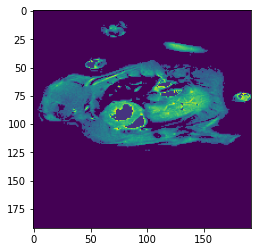

In [ ]:
#get one image and print it 4,15,1-3, 1-9
img = dataset1.image_list[0]
print(img.shape)
print(img.dtype)
plt.imshow(img/2500)
plt.show()


In [ ]:
#gradcam

model = trained_models[0]
last_conv_layer = list(model.children())[0][4]
target_layers = [last_conv_layer]
input_tensor = torch.from_numpy(img).float().unsqueeze(0)#.unsqueeze(0)
#input_tensor = torch.from_numpy(img.reshape(1, 1, 192, 192)).float() # Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!
print("input_tensor:", input_tensor.shape)

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available())

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.
targets = [ClassifierOutputTarget(1)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
img2 = np.zeros((192,192))
imgg = np.array([img2,img2,img2]).reshape(192, 192, 3)
visualization = show_cam_on_image(imgg, grayscale_cam, use_rgb=True)

plt.imshow(img)
plt.show()
Image.fromarray(visualization)

TypeError: ignored

--- OLD ---

# --- OLD ---



# [OLD]'Grid' search on agumentations

In [ ]:
torch.manual_seed(42)
criterion = nn.CrossEntropyLoss()

best_params = {  
    'learning_rate': [0.00000001],
    'batch_size': [4], 
    'dropout': [0.0],
    'num_epochs': [30],
    'number_of_linear_layers': [2], 
    'l1_regularization_lambda': [0.0], 
    'l2_regularization_lambda': [0.0],  
    'number_of_conv_layers': [2],
    'number_of_filers' : [4], 
    'pooling': [True],
    'batch_norm': [True],
    'shape_info': [False]
}

k = 4

seq = False
rgb = False 

if rgb:
  number_of_channels = 3
else:
  number_of_channels = 1

In [ ]:
#more parms 
grid_agumentations = {
    'RandomHorizontalFlipProb': [0.0, 0.2],
    'RandomRotation': [0, 10, 15],
    'RandomAffineScale': [0.0, 0.1, 0.2],
    'GaussianBlurProb': [0.0, 0.2],
    'RandomVerticalFlipProb': [0.0, 0.2]
}

In [ ]:
keys = list(grid_agumentations.keys())
shape = tuple(len(grid_agumentations[keys[i]]) for i in range(len(keys)))
grid = np.zeros((shape))

for idx in itertools.product(*[range(s) for s in shape]):
  current_agumentations = {k: grid_agumentations[k][idx[e]] for e,k in enumerate(keys)}
  print("  current_agumentations:", current_agumentations)

  train_transform = transforms.Compose([
    transforms.ToPILImage(),                                  
    transforms.RandomHorizontalFlip(p=current_agumentations['RandomHorizontalFlipProb']),
    transforms.RandomRotation(degrees=(-1*current_agumentations['RandomRotation'], current_agumentations['RandomRotation'])),
    transforms.RandomAffine(degrees=0, scale=(1.0-current_agumentations['RandomAffineScale'], 1.0+current_agumentations['RandomAffineScale']), shear=0),
    #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.RandomVerticalFlip(p=current_agumentations['RandomVerticalFlipProb']),
    transforms.ToTensor()
  ])

  dataset = PyTorchImageDataset(FAT_DIR0, FAT_DIR1, HEALTHY_DIR0, HEALTHY_DIR1, train_transform, rgb)

  splitter = StratifiedKFold(n_splits=k, shuffle=True, random_state=42) 
  splits = splitter.split(dataset, dataset.labels)

  current_params = {k: grid_param[k][0] for k in list(grid_param.keys())}

  def model_getter():
    return Net(best_params, 1, dataset.image_list[0].shape[0])
  def model_getter_resnet():
    return copy.deepcopy(finetune_model)

  results = folds_loop(model_getter, dataset, criterion, current_params, splits)
  grid[idx] = print_and_save_folds_results(results, current_params, SPREEDSHEET_NAME_FINAL, current_agumentations)

best_params = find_best_params_ndim(grid_agumentations, grid)
print("best params:", best_params)



In [ ]:
#grid on agu on cutted - old
torch.manual_seed(42)
criterion = nn.CrossEntropyLoss()

grid_param = {
    'learning_rate': [0.01],
    'batch_size': [4], 
    'dropout': [0.0],
    'num_epochs': [100],
    'number_of_linear_layers': [2], 
    'l1_regularization_lambda': [0.0], 
    'l2_regularization_lambda': [0.0],
    'number_of_conv_layers': [3], 
    'number_of_filers': [2], 
    'pooling': [False],
    'batch_norm': [True],
    'shape_info': [False] 
}

k = 4

seq = False #temp not supported  
rgb = False 


grid_agumentations = {
    'RandomHorizontalFlipProb': [0.0, 0.5],
    'RandomRotation': [0, 30, 90],
    'RandomAffineScale': [0.0, 0.1, 0.2, 0.3, 0.4],
    'GaussianBlurProb': [0.0, 0.5],
    'RandomVerticalFlipProb': [0.0, 0.5]
}

keys = list(grid_agumentations.keys())
shape = tuple(len(grid_agumentations[keys[i]]) for i in range(len(keys)))
grid = np.zeros((shape))

for idx in itertools.product(*[range(s) for s in shape]):
  current_agumentations = {k: grid_agumentations[k][idx[e]] for e,k in enumerate(keys)}
  print("  current_agumentations:", current_agumentations)

  train_transform = transforms.Compose([
    transforms.ToPILImage(),                                  
    transforms.RandomHorizontalFlip(p=current_agumentations['RandomHorizontalFlipProb']),
    transforms.RandomRotation(degrees=(-1*current_agumentations['RandomRotation'], current_agumentations['RandomRotation'])),
    transforms.RandomAffine(degrees=0, scale=(1.0-current_agumentations['RandomAffineScale'], 1.0+current_agumentations['RandomAffineScale']), shear=0),
    #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.RandomVerticalFlip(p=current_agumentations['RandomVerticalFlipProb']),
    transforms.ToTensor()
  ])

  dataset = HeartDataset(HEART_FAT_DIR0, HEART_FAT_DIR1, HEART_HEALTHY_DIR0, HEART_HEALTHY_DIR1, train_transform, rgb)

  splitter = StratifiedKFold(n_splits=k, shuffle=True, random_state=42) 
  splits = splitter.split(dataset, dataset.labels)

  current_params = {k: grid_param[k][0] for k in list(grid_param.keys())}

  def model_getter():
    return Net(current_params, 1, dataset.image_list[0].shape[0])

  results = folds_loop(model_getter, dataset, criterion, current_params, splits)
  grid[idx] = print_and_save_folds_results(results, current_params, SPREEDSHEET_NAME_FINAL, current_agumentations)

best_params = find_best_params_ndim(grid_agumentations, grid)
print("best params:", best_params)


# Resnet - old

In [ ]:
model_resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
criterion = nn.CrossEntropyLoss()

grid_param = {  
    'learning_rate': [0.00001, 0.00001, 0.000001],
    'batch_size': [2]  
}

num_epochs = 100
k=4

seq = False #parameter describing if we are learning on square at first or random

regularization_lambda = 0.001 

In [ ]:
#load data

resnet_transform = transforms.Compose([
    transforms.ToPILImage(),
    #transforms.Resize(256),
    #transforms.CenterCrop(224),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomAffine(degrees=0, scale=(.8, 1.2), shear=0),
    #transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset0 = PyTorchImageDataset(FAT_DIR0, HEALTHY_DIR0, resnet_transform, rgb = True)
dataset1 = PyTorchImageDataset(FAT_DIR1, HEALTHY_DIR1, resnet_transform, rgb = True)
joined_dataset = torch.utils.data.ConcatDataset([dataset0, dataset1])
print("Train dataset size:", len(dataset0), len(dataset1))

print("item shape", dataset0.image_list[0].shape, " label", dataset0.labels[0])

Train dataset size: 24 19
item shape (192, 192, 3)  label 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [ ]:
#train

splits = StratifiedKFold(n_splits=k, shuffle=True, random_state=42) 
results, results1 = {}, {}
trained_models = {}

splits0 = splits.split(dataset0, dataset0.labels)
splits1 = splits.split(dataset1, dataset1.labels)

for fold, ((train_idx, val_idx), (train_idx1, val_idx1)) in enumerate(zip(splits0, splits1)):
    print('Fold {}'.format(fold + 1))

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = copy.deepcopy(model_resnet)
    model.to(device)  
    optimizer = Adam(model.parameters(), lr=grid_param['learning_rate'][0])

    joined_ids = np.concatenate((val_idx, [x+(len(dataset0)) for x in val_idx1]))
    shapes_test = np.concatenate((np.zeros((len(val_idx), 1)), np.ones((len(val_idx1), 1))))
    test_loader = DataLoader(joined_dataset, batch_size=grid_param['batch_size'][0]) #, sampler=SubsetRandomSampler(joined_ids))

    if seq:
      train_loader = DataLoader(dataset0, batch_size=grid_param['batch_size'][0]) #, sampler=SubsetRandomSampler(train_idx))
      shapes_train = np.zeros((len(train_idx), 1))
      results[fold] = train_loop(model, device, num_epochs, train_loader, test_loader, criterion, optimizer, shapes_train, shapes_test)
      train_loader1 = DataLoader(dataset1, batch_size=grid_param['batch_size'][0]) #, sampler=SubsetRandomSampler(train_idx1))
      shapes_train1 = np.ones((len(train_idx1), 1))
      results1[fold] = train_loop(model, device, num_epochs, train_loader1, test_loader, criterion, optimizer, shapes_train1, shapes_test)
    else:
      joined_train_ids = np.concatenate((train_idx, [x+(len(dataset0)) for x in train_idx1]))
      shapes_train = np.concatenate((np.zeros((len(train_idx), 1)), np.ones((len(train_idx1), 1))))
      train_loader = DataLoader(joined_dataset, batch_size=grid_param['batch_size'][0]) #, sampler=SubsetRandomSampler(joined_train_ids))
      results[fold] = train_loop(model, device, num_epochs, train_loader, test_loader, criterion, optimizer, shapes_train, shapes_test)
    
    trained_models[fold] = model
      
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k} FOLDS')
print_folds_results(results)
if seq:
  print_folds_results(results1)

Fold 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:1/100 AVG Training Loss:242.095 AVG Test Loss:6.602 AVG Training Acc 0.00 % AVG Test Acc 0.00 %
Epoch:2/100 AVG Training Loss:240.928 AVG Test Loss:6.459 AVG Training Acc 0.00 % AVG Test Acc 0.00 %
Epoch:3/100 AVG Training Loss:239.760 AVG Test Loss:6.488 AVG Training Acc 0.00 % AVG Test Acc 0.00 %
Epoch:4/100 AVG Training Loss:238.580 AVG Test Loss:6.423 AVG Training Acc 0.00 % AVG Test Acc 18.18 %
Epoch:5/100 AVG Training Loss:237.379 AVG Test Loss:6.151 AVG Training Acc 40.62 % AVG Test Acc 18.18 %
Epoch:6/100 AVG Training Loss:236.217 AVG Test Loss:5.928 AVG Training Acc 75.00 % AVG Test Acc 18.18 %
Epoch:7/100 AVG Training Loss:235.077 AVG Test Loss:5.757 AVG Training Acc 84.38 % AVG Test Acc 27.27 %
Epoch:8/100 AVG Training Loss:233.954 AVG Test Loss:5.612 AVG Training Acc 90.62 % AVG Test Acc 45.45 %
Epoch:9/100 AVG Training Loss:232.709 AVG Test Loss:5.491 AVG Training Acc 84.38 % AVG Test Acc 45.45 %
Epoch:10/100 AVG Training Loss:231.706 AVG Test Loss:5.341 AVG Training

In [ ]:
#train - after refactor

splits = StratifiedKFold(n_splits=k, shuffle=True, random_state=42) 
results, results1 = {}, {}
trained_models = {}

splits0 = splits.split(dataset0, dataset0.labels)
splits1 = splits.split(dataset1, dataset1.labels)

for fold, ((train_idx, val_idx), (train_idx1, val_idx1)) in enumerate(zip(splits0, splits1)):
    print('Fold {}'.format(fold + 1))

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = copy.deepcopy(model_resnet)
    model.to(device)  
    optimizer = Adam(model.parameters(), lr=grid_param['learning_rate'][0])

    joined_ids = np.concatenate((val_idx, [x+(len(dataset0)) for x in val_idx1]))
    shapes_test = np.concatenate((np.zeros((len(val_idx), 1)), np.ones((len(val_idx1), 1))))
    test_loader = DataLoader(joined_dataset, batch_size=grid_param['batch_size'][0], sampler=SubsetRandomSampler(joined_ids))

    if seq:
      train_loader = DataLoader(dataset0, batch_size=grid_param['batch_size'][0], sampler=SubsetRandomSampler(train_idx))
      shapes_train = np.zeros((len(train_idx), 1))
      results[fold] = train_loop(model, device, num_epochs, train_loader, test_loader, criterion, optimizer, shapes_train, shapes_test)
      train_loader1 = DataLoader(dataset1, batch_size=grid_param['batch_size'][0], sampler=SubsetRandomSampler(train_idx1))
      shapes_train1 = np.ones((len(train_idx1), 1))
      results1[fold] = train_loop(model, device, num_epochs, train_loader1, test_loader, criterion, optimizer, shapes_train1, shapes_test)
    else:
      joined_train_ids = np.concatenate((train_idx, [x+(len(dataset0)) for x in train_idx1]))
      shapes_train = np.concatenate((np.zeros((len(train_idx), 1)), np.ones((len(train_idx1), 1))))
      train_loader = DataLoader(joined_dataset, batch_size=grid_param['batch_size'][0], sampler=SubsetRandomSampler(joined_train_ids))
      results[fold] = train_loop(model, device, num_epochs, train_loader, test_loader, criterion, optimizer, shapes_train, shapes_test)
    
    trained_models[fold] = model
      
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k} FOLDS')
print_folds_results(results)
if seq:
  print_folds_results(results1)

# Basic net

In [ ]:
class MousesDataset(Dataset):
    def __init__(self, x, y):
        self.samples = x 
        self.labels = y 

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]

In [ ]:
fat = [load_image(os.path.join(FAT_DIR, filename), 1, False, True) for filename in os.listdir(FAT_DIR)]
healthy = [load_image(os.path.join(HEALTHY_DIR, filename), 0, False, True) for filename in os.listdir(HEALTHY_DIR)]

In [ ]:
val_x = np.array([fat[0][0], fat[1][0], healthy[0][0], healthy[1][0]]).astype(np.double)
val_y = np.array([fat[0][1], fat[1][1], healthy[0][1], healthy[1][1]]).astype(np.double)

all = np.array(fat[2:] + healthy[2:])
#all = np.array(fat_a + healthy_a)
np.random.shuffle(all)

train_x = np.array([x[0] for x in all]).astype(np.double)
train_y = np.array([x[1] for x in all]).astype(np.double)

print("train size:", train_x.shape, train_y.shape, train_x.dtype)
print("test size:", val_x.shape, val_y.shape)

train size: (39, 192, 192) (39,) float64
test size: (4, 192, 192) (4,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


In [ ]:
# converting training images into torch format - for old only
train_x, train_y = conver_into_toarch(train_x, train_y)
val_x, val_y = conver_into_toarch(val_x, val_y)

In [ ]:
#prepare datasets

train_dataset = MousesDataset(train_x, train_y)
test_dataset = MousesDataset(val_x, val_y)
print("Train dataset size:", len(train_dataset), " test dataset size:", len(test_dataset))


Train dataset size: 39  test dataset size: 4


In [ ]:
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=LR)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

In [ ]:
def train(epoch):
    model.train()
    tr_loss = 0
    x_train, y_train = Variable(train_x), Variable(train_y)
    x_val, y_val = Variable(val_x), Variable(val_y)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train.float())
    output_val = model(x_val.float())

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        print('Epoch : ',epoch+1, '\t', 'loss tr :', loss_train, 'loss val:', loss_val)

In [ ]:
#normal train
n_epochs = 10
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    train(epoch)

In [ ]:
# prediction for training and val set

print("Prediction on test set:", predict_function(train_x, train_y), " prediction on val set:", predict_function(val_x, val_y))

Prediction on test set: 0.568075117370892  prediction on val set: 0.5


Cross validation

In [ ]:
LR = 0.01
BATCH_SIZE = 5

In [ ]:
def predict_function(x, y):
  with torch.no_grad():
    output = model(x.float())
    
  softmax = torch.nn.functional.softmax(output, 1)
  prob = list(softmax.numpy())
  predictions = np.argmax(prob, axis=1)

  return accuracy_score(y, predictions)

NORMAL shape: (192, 192, 3) min: 0.0  max: 2497.0985384544074


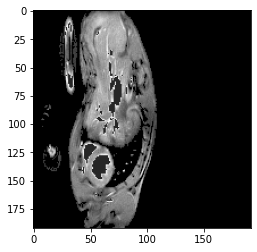

AFTER CAST shape: (192, 192, 3) min: 0  max: 249
AFTER TRANS shape: torch.Size([3, 192, 192]) min: 0.0  max: 0.9764706
AFTER TRANS shape: torch.Size([3, 192, 192]) min: 0.0  max: 0.9764706


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


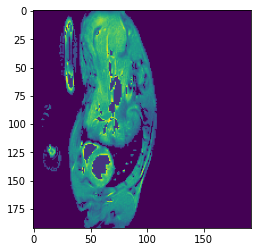

img shape: (192, 192, 3)
img shape po transpozyjci: (3, 192, 192)
AFTER TRANS shape: torch.Size([3, 192, 192]) min: 0.0  max: 249.0


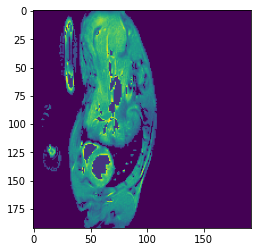

In [ ]:
#get one image and print it 4,15,1-3, 1-9

#image = self.image_list[i]    
#image = np.array(image/10).astype(np.uint8) 
#image = self.transforms(image) 
#image = image/2500 
#return (torch.tensor(image, dtype=torch.float), self.labels[i])
model = trained_models[0]
img = dataset1.image_list[0]
print("NORMAL shape:", img.shape, "min:", np.min(img), " max:", np.max(img))
plt.imshow(img/2500)
plt.show()

#like in net
img = np.array(img/10).astype(np.uint8)
print("AFTER CAST shape:", img.shape, "min:", np.min(img), " max:", np.max(img)) 
img = resnet_transform(img)
print("AFTER TRANS shape:", img.shape, "min:", np.min(img.numpy()), " max:", np.max(img.numpy())) 
img = torch.tensor(img, dtype=torch.float)
print("AFTER TRANS shape:", img.shape, "min:", np.min(img.numpy()), " max:", np.max(img.numpy())) 
plt.imshow(img.numpy()[1])
plt.show()

#transformed
img = dataset1.image_list[0]
img = np.array(img/10).astype(np.uint8)
print("img shape:", img.shape)
img = img.transpose((-1, 0, 1))
print("img shape po transpozyjci:", img.shape)
#img = resnet_transform(img)
img = torch.tensor(img, dtype=torch.float)
print("AFTER TRANS shape:", img.shape, "min:", np.min(img.numpy()), " max:", np.max(img.numpy())) 
plt.imshow(img.numpy()[1])
plt.show()


In [ ]:
print("LAYER4: ", model.layer4)

print("MODEL:", list(model.modules()))

label: 1
input_tensor shape: torch.Size([1, 3, 192, 192])


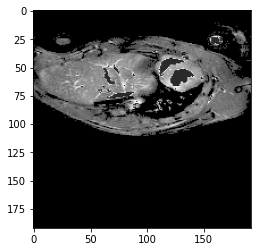

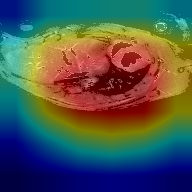

In [ ]:
#gradcam
i = 1
image = dataset1.image_list[i]
label = dataset1.labels[i]
print("label:", label)

last_conv_layer = list(model.children())[1]
target_layers = [model.layer4[0]]
input_tensor = torch.from_numpy(image.transpose((-1, 0, 1))).float().unsqueeze(0) #.unsqueeze(0)
print("input_tensor shape:", input_tensor.shape)

cam = GradCAM(model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available())
targets = [ClassifierOutputTarget(1)]
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
img = np.zeros((192,192))
#background_image = np.array([img,img,img]).reshape(192, 192, 3)
background_image = image/2500
visualization = show_cam_on_image(background_image, grayscale_cam, use_rgb=True)

plt.imshow(image/2500)
plt.show()
Image.fromarray(visualization)

# olds

In [ ]:
#[old] grid search (double cross validation)

splits = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
splits0, splits1 = splits.split(dataset_square, dataset_square.labels), splits.split(dataset_rectangle, dataset_rectangle.labels)



def folds_loop_double(criterion, grid_param, splits0, splits1):
  out_results = {}
  out_best_params = {}
  trained_models = {}
  keys = list(grid_param.keys())
  shape = tuple(len(grid_param[keys[i]]) for i in range(len(keys)))
  for fold, ((train_idx, val_idx), (train_idx1, val_idx1)) in enumerate(zip(splits0, splits1)):
      print('Fold {}. train_idx:{} val_idx:{} train_idx1:{} val_idx1:{}'.format(fold + 1, train_idx, val_idx, train_idx1, val_idx1))

      inner_splits = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
      grid = np.zeros((shape))

      for idx in itertools.product(*[range(s) for s in shape]):
        current_params = {k: grid_param[k][idx[e]] for e,k in enumerate(keys)}

        def model_getter():
          return prepare_train_model(current_params)

        inner_splits0 = inner_splits.split(train_idx, np.array(dataset0.labels)[train_idx])
        inner_splits1 = inner_splits.split(train_idx1, np.array(dataset1.labels)[train_idx1])

        results = {}
        for inner_fold, ((inner_train_idxx, inner_val_idxx), (inner_train_idxx1, inner_val_idxx1)) in enumerate(zip(inner_splits0, inner_splits1)):
          inner_train_idx = train_idx[inner_train_idxx]
          inner_val_idx = train_idx[inner_val_idxx]
          inner_train_idx1 = train_idx1[inner_train_idxx1]
          inner_val_idx1 = train_idx1[inner_val_idxx1]
          #print('  Inner Fold {}. inner_train_idxx:{} inner_val_idxx:{} inner_train_idxx1:{} inner_val_idxx1:{}'.format(inner_fold + 1, inner_train_idxx, inner_val_idxx, inner_train_idxx1, inner_val_idxx1))
          #print('   inner_train_idx:{} inner_val_idx:{} inner_train_idx1:{} inner_val_idx1:{}'.format(inner_fold + 1, inner_train_idx, inner_val_idx, inner_train_idx1, inner_val_idx1))

          model, optimizer, device = prepare_model(model_getter, current_params['learning_rate'])
          test_loader, shapes_test = prepare_test_loader(inner_val_idx, inner_val_idx1, current_params['batch_size'], len(train_idx), joined_dataset)

          joined_train_ids = np.concatenate((train_idx, [x+(len(train_idx)) for x in inner_train_idx1]))
          shapes_train = np.concatenate((np.zeros((len(train_idx), 1)), np.ones((len(train_idx1), 1))))
          train_loader = DataLoader(joined_dataset, batch_size=current_params['batch_size']) #, sampler=SubsetRandomSampler(joined_train_ids))
          results[inner_fold] = train_loop(model, device, current_params, train_loader, test_loader, criterion, optimizer, shapes_train, shapes_test)  

        grid[idx] = print_and_save_folds_results(results, current_params, SPREEDSHEET_NAME_INT)
      best_params = find_best_params_ndim(grid_param, grid)

      def model_getter():
        return prepare_train_model(best_params)
      model, optimizer, device = prepare_model(model_getter, best_params['learning_rate'])
      test_loader, shapes_test = prepare_test_loader(val_idx, val_idx1, best_params['batch_size'], len(dataset0), joined_dataset)

      joined_train_ids = np.concatenate((train_idx, [x+(len(dataset0)) for x in train_idx1]))
      shapes_train = np.concatenate((np.zeros((len(train_idx), 1)), np.ones((len(train_idx1), 1))))
      train_loader = DataLoader(joined_dataset, batch_size=best_params['batch_size']) #, sampler=SubsetRandomSampler(joined_train_ids))
      out_results[fold] = train_loop(model, device, current_params, train_loader, test_loader, criterion, optimizer, shapes_train, shapes_test)
      out_best_params[fold] = best_params
      trained_models[fold] = model
      #print("Out results for outer fold:", fold, " ", out_results[fold])
  return out_results, out_best_params, trained_models

print("---------")
out_results, out_best_params, trained_models = folds_loop_double(criterion, grid_param, splits0, splits1)
print_and_save_folds_results2(out_results, out_best_params, SPREEDSHEET_NAME_FINAL)
print("Final best params:", out_best_params)



---------
Fold 1. train_idx:[ 0  1  4  5  6  9 10 11 13 14 15 16 17 18 19 20 22 23] val_idx:[ 2  3  7  8 12 21] train_idx1:[ 0  2  3  6  7  8  9 11 13 14 15 16 17 18] val_idx1:[ 1  4  5 10 12]
Epoch:1/20 AVG Training Loss:10.440 AVG Test Loss:0.692 AVG Training Acc 85.19 % AVG Test Acc 45.45 %
Epoch:2/20 AVG Training Loss:10.450 AVG Test Loss:0.689 AVG Training Acc 66.67 % AVG Test Acc 36.36 %
Epoch:3/20 AVG Training Loss:10.454 AVG Test Loss:0.685 AVG Training Acc 70.37 % AVG Test Acc 45.45 %
Epoch:4/20 AVG Training Loss:10.404 AVG Test Loss:0.677 AVG Training Acc 70.37 % AVG Test Acc 54.55 %
Epoch:5/20 AVG Training Loss:10.420 AVG Test Loss:0.667 AVG Training Acc 66.67 % AVG Test Acc 63.64 %
Epoch:6/20 AVG Training Loss:10.410 AVG Test Loss:0.654 AVG Training Acc 62.96 % AVG Test Acc 63.64 %
Epoch:7/20 AVG Training Loss:10.379 AVG Test Loss:0.644 AVG Training Acc 74.07 % AVG Test Acc 63.64 %
Epoch:8/20 AVG Training Loss:10.387 AVG Test Loss:0.638 AVG Training Acc 70.37 % AVG Test Acc

RuntimeError: ignored

In [ ]:
#depricated should be removed
def prepare_test_loader(val_idx, val_idx1, batch_size, len_dataset0, dataset):
  joined_ids = np.concatenate((val_idx, [x+(len_dataset0) for x in val_idx1]))
  shapes_test = np.concatenate((np.zeros((len(val_idx), 1)), np.ones((len(val_idx1), 1))))
  #test_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(joined_ids))
  test_loader = DataLoader(dataset, batch_size=batch_size)
  return test_loader, shapes_test

#depricated should be removed
# def folds_loop_old(get_model, criterion, net_params, splits0, splits1):
#   results = {}
#   for fold, ((train_idx, val_idx), (train_idx1, val_idx1)) in enumerate(zip(splits0, splits1)):
#       print('Fold {}. train_idx:{} val_idx:{} train_idx1:{} val_idx1:{}'.format(fold + 1, train_idx, val_idx, train_idx1, val_idx1))

#       model, optimizer, device = prepare_model(get_model, net_params['learning_rate'])
#       test_loader, shapes_test = prepare_test_loader(val_idx, val_idx1, net_params['batch_size'], len(train_idx)+len(val_idx), joined_dataset)

#       joined_train_ids = np.concatenate((train_idx, [x+(len(train_idx)+len(val_idx)) for x in train_idx1]))
      
#       shapes_train = np.concatenate((np.zeros((len(train_idx), 1)), np.ones((len(train_idx1), 1))))
#       train_loader = DataLoader(joined_dataset, batch_size=net_params['batch_size'])#, sampler=SubsetRandomSampler(joined_train_ids))
#       results[fold] = train_loop(model, device, net_params, train_loader, test_loader, criterion, optimizer, shapes_train, shapes_test)
#   return results

  # def print_folds_results(conf_matrixes): #depricated
#   sum = 0.0
#   for key, conf_matrix in conf_matrixes.items():
#     print("key:", key, " conf_matrix:", conf_matrix)
#     v = (conf_matrix[0][0] + conf_matrix[1][1]) / np.sum(conf_matrix)
#     print(f'Fold {key} acc: {v} %')
#     sum += v
#   result = sum/len(conf_matrixes.items())
#   print(f' Average acc: {result} %')
#   return result

In [ ]:
def conver_into_toarch(x, y):
  # converting training images into torch format
  x = x.reshape(x.shape[0], 1, x.shape[1], x.shape[2])
  x  = torch.from_numpy(x)

  # converting the target into torch format
  y = y.astype(int);
  y = torch.from_numpy(y)

  # shape of training data
  print(x.shape, y.shape)

  return (x,y)

In [ ]:
#load data and evaluate on existing models

test_dataset_square = PyTorchImageDataset(TEST_FAT_DIR_SQUARE, TEST_HEALTHY_DIR_SQUARE, test_transform, rgb)
test_dataset_rectangle = PyTorchImageDataset(TEST_FAT_DIR_RECTANGLE, TEST_HEALTHY_DIR_RECTANGLE, test_transform, rgb)
test_joined_dataset = torch.utils.data.ConcatDataset([test_dataset_square, test_dataset_rectangle])
print("Test dataset size:", len(test_dataset_square), len(test_dataset_rectangle))

print("item shape", test_dataset_rectangle.image_list[0].shape, " label", test_dataset_rectangle.labels[0])

for i in range(len(trained_models)):
  model = trained_models[i]
  bs = out_best_params[i]['batch_size']

  test_loader, shapes_test = prepare_test_loader(list(range(len(test_dataset_square))), list(range(len(test_dataset_rectangle))), bs, len(test_dataset_square), test_joined_dataset)

  test_loss, test_correct, cf_matrix = valid_epoch(model, device, test_loader, criterion, shapes_test, bs)

  test_loss = test_loss / len(test_loader.sampler)
  test_acc = test_correct / len(test_loader.sampler) * 100

  print("[FINAL DATASET] Test acc:", test_acc, " for model with index:", i)


[FINAL DATASET] Test acc: 20.0  for model with index: 0
[FINAL DATASET] Test acc: 20.0  for model with index: 1
[FINAL DATASET] Test acc: 20.0  for model with index: 2
[FINAL DATASET] Test acc: 60.0  for model with index: 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
#old 
splits = StratifiedKFold(n_splits=k, shuffle=True, random_state=42) 
foldperf = {}
results = {}

dataset = dataset0

#for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):
for fold, (train_idx, val_idx) in enumerate(splits.split(dataset, [d[1] for d in dataset])):
    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model = Net()
    model.to(device)  
    optimizer = Adam(model.parameters(), lr=learning_rate)

    history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

    for epoch in range(num_epochs):
        train_loss, train_correct = train_epoch(model, device, train_loader, criterion, optimizer)
        test_loss, test_correct, cf_matrix = valid_epoch(model, device, test_loader, criterion)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100

        if True: #epoch+1 == num_epochs:
          print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                             num_epochs,
                                                                                                             train_loss,
                                                                                                             test_loss,
                                                                                                             train_acc,
                                                                                                             test_acc))
          results[fold] = test_acc
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

    foldperf['fold{}'.format(fold+1)] = history  

print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k} FOLDS')
sum = 0.0
for key, value in results.items():
  print(f'Fold {key}: {value} %')
  sum += value
print(f'Average: {sum/len(results.items())} %')

torch.save(model,'k_cross_CNN.pt') 

In [ ]:
#old cross val

# Configuration options
k_folds = 5
num_epochs = 10
LR = 0.0001

# defining the model
model = Net()
optimizer = Adam(model.parameters(), lr=LR)
criterion = CrossEntropyLoss()

print(train_x.shape, val_x.shape) 
print(torch.cat((train_x, val_x), 0).shape)
X = torch.cat((train_x, val_x), 0)
y = torch.cat((train_y, val_y), 0)

kf = KFold(n_splits=4, shuffle=True)
for train_index, test_index in kf.split(X):
  #print("TRAIN:", train_index, "TEST:", test_index)
  train_x, val_x = X[train_index], X[test_index]
  train_y, val_y = y[train_index], y[test_index]

  train_losses = []
  val_losses = []

  for epoch in range(num_epochs):
      train(epoch)

#podwojna walidacja krzyzowa
#agumentacja częścią treningu
#sprawdzic po kolei kazda agumentacje o ile poprawia wynik
#zbierać wyniki w tabeli
#seed ustalony zeby zbior byl tak samo dzielony
#stratify kflod 


torch.Size([323, 1, 192, 192]) torch.Size([107, 1, 192, 192])
torch.Size([430, 1, 192, 192])
Epoch :  1 	 loss tr : tensor(0.8066, grad_fn=<NllLossBackward0>) loss val: tensor(0.7530, grad_fn=<NllLossBackward0>)
Epoch :  3 	 loss tr : tensor(0.7729, grad_fn=<NllLossBackward0>) loss val: tensor(0.7687, grad_fn=<NllLossBackward0>)
Epoch :  5 	 loss tr : tensor(0.7016, grad_fn=<NllLossBackward0>) loss val: tensor(0.6913, grad_fn=<NllLossBackward0>)
Epoch :  7 	 loss tr : tensor(0.6795, grad_fn=<NllLossBackward0>) loss val: tensor(0.6748, grad_fn=<NllLossBackward0>)
Epoch :  9 	 loss tr : tensor(0.6268, grad_fn=<NllLossBackward0>) loss val: tensor(0.6455, grad_fn=<NllLossBackward0>)
Epoch :  1 	 loss tr : tensor(0.6230, grad_fn=<NllLossBackward0>) loss val: tensor(0.5658, grad_fn=<NllLossBackward0>)
Epoch :  3 	 loss tr : tensor(0.5814, grad_fn=<NllLossBackward0>) loss val: tensor(0.5402, grad_fn=<NllLossBackward0>)
Epoch :  5 	 loss tr : tensor(0.5481, grad_fn=<NllLossBackward0>) loss val

Random staff

ile obrazkow do validacji? (wszystkich 43)

wyniki:

post - 1.0 0.5/0.75 prze 100 epokach i lr 0.01

pre - 1.0 0.25 -''-

zwiekszenie lr nie

zwiekszenie batcha 1 -> 5 cos chyba daje bo na pre 0.75

zmniejszenie lr do 0.001 chyba pomaga -> trzeba zrobic greed

In [ ]:
# plotting the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


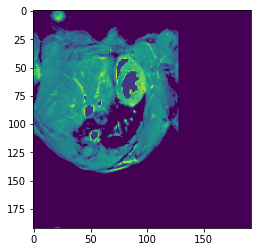

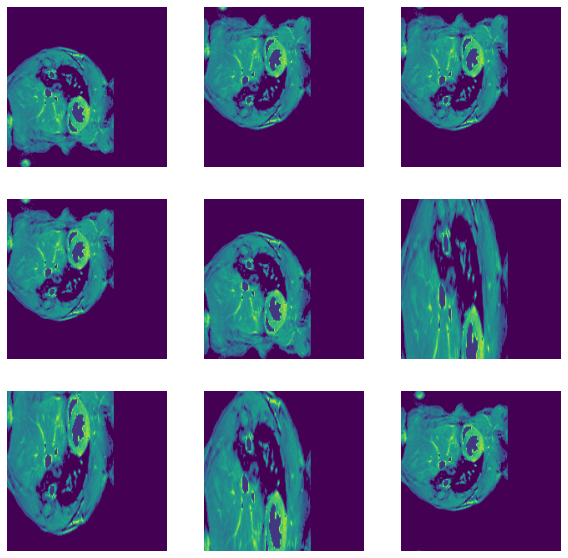

In [ ]:
#test agumentation

import tensorflow as tf

img = fat[0][0]
print(img)
plt.imshow(img)
plt.show()

data_augmentation = tf.keras.Sequential([
     tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
     tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)])

image = tf.expand_dims(img, 0)
plt.figure(figsize=(10, 10))

for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

false_positive_rate: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]  true_positive_rate: [0.         0.58823529 0.69747899 0.7394958  0.76470588 0.78151261
 0.78571429 0.79411765 0.79831933 0.80672269 0.81092437 0.82773109
 0.84453782 0.86134454 1.         1.        ]  thresholds: [2.0000000e+00 1.0000000e+00 9.9999988e-01 9.9999976e-01 9.9999964e-01
 9.9999952e-01 9.9999940e-01 9.9999928e-01 9.9999917e-01 9.9999905e-01
 9.9999893e-01 9.9999857e-01 9.9999774e-01 9.9999714e-01 9.9853837e-01
 1.0158911e-15]
1.0


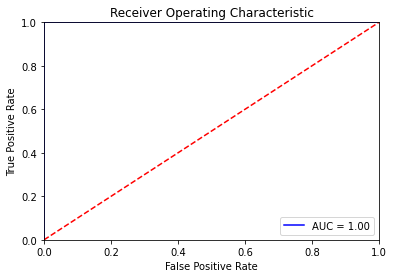

In [ ]:
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(predictions, [x[1] for x in prob])
roc_auc = auc(false_positive_rate, true_positive_rate)
print("false_positive_rate:", false_positive_rate, " true_positive_rate:", true_positive_rate, " thresholds:", thresholds)
print(roc_auc)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# define pytorch transforms
transform = transforms.Compose([
     transforms.ToPILImage(),
     transforms.Resize((300, 300)),
     transforms.CenterCrop((100, 100)),
     transforms.RandomCrop((80, 80)),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomRotation(degrees=(-90, 90)),
     transforms.RandomVerticalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])

In [ ]:
#old static but working
data_augmentation = tf.keras.Sequential([
     tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
     tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
     ])

fat_a = fat[2:]
healthy_a = healthy[2:]

for f in fat[2:]:
  for i in range(9):
    image = tf.expand_dims(f[0], 0)
    new = data_augmentation(image)[0]
    fat_a.append((new, f[1]))

for h in healthy[2:]:
  for i in range(9):
    imagee = tf.expand_dims(h[0], 0)
    new = data_augmentation(imagee)[0]
    healthy_a.append((new, h[1]))


dict_keys(['__header__', '__version__', '__globals__', 'postT1map', 'preT1map'])


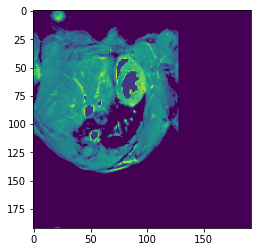

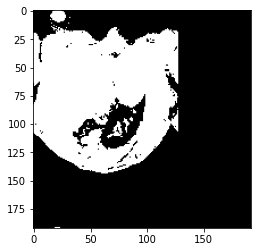

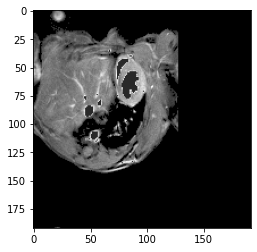

img shape: (192, 192, 3)  min: 0.0  max: 0.9994574952752239


In [ ]:
#temp

def toRGB(image):
  dim = np.zeros((image.shape[0], image.shape[1]))
  rgb_image = np.stack((image/2500, image/2500, image/2500), axis=2)
  return rgb_image

filename = os.listdir(FAT_DIR)[0]
filepath = os.path.join(FAT_DIR, filename)
maps = scipy.io.loadmat(filepath)
print(maps.keys())
img_pre = np.array(maps['preT1map'], np.double)
img_pre = fix_image(img_pre)
plt.imshow(img_pre)
plt.show()
img_pree = Image.fromarray(img_pre).convert('RGB')
plt.imshow(img_pree)
plt.show()
img_pre = toRGB(img_pre)
plt.imshow(img_pre)
plt.show()
print("img shape:", img_pre.shape, " min:", np.min(img_pre), " max:", np.max(img_pre))